In [1]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
import lightgbm as lgb
from hyperopt import hp, tpe, Trials, STATUS_OK, Trials, anneal
from functools import partial
from hyperopt.fmin import fmin
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve,auc, fbeta_score
from sklearn.metrics import mean_squared_error
%reload_ext autoreload
%load_ext autoreload
%autoreload 1

from feas_select import  calc_feas,get_drop
import numpy as np
import  matplotlib.pyplot as plt
%matplotlib inline
from tensorflow import random
import keras
from keras import regularizers
from keras.layers import Dense,Dropout,BatchNormalization,GaussianNoise
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping
from sklearn.metrics import  mean_squared_error

import gc

gc.enable()

import numpy as np
import  matplotlib.pyplot as plt
%matplotlib inline
from tensorflow import random
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import  mean_squared_error
import keras_tuner as kt  # pip install tf.keras_tuner 

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))  # 全屏展示
pd.set_option('display.max_columns', 600)
pd.set_option('display.max_rows', 200)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def read_train(file='./data/filter_feas_df32n_old.pkl',model='tree'):
    df = pd.read_pickle(file)
    df3 = pd.read_csv('./data/EXPERIAN_FEATURE_0327.csv',nrows=2) # 取旧模型特征列表
    print(df.shape)
    df.head()

    ##############################配置
    oot_dt ='20220200000000'
    nofeas = ['ID', 'report_timestamp','label','pan','label_y','order_id','label_pred']
    catefeas= list(pd.read_pickle('./data/catefeas.pkl').values)
    cbfeas = [col for col in df.columns if '_cb'in str(col)]
    vcount = [col for col in df.columns if 'vcount'in str(col)]
    old_feas = [col for col in df.columns if 'feature_'in str(col)]
    old_cols = list(df3.columns)
    sms_feas = [col for col in df3.columns if '_sms'in str(col)]
    nosms_feas = [col for col in df3.columns if '_sms' not in str(col) and col not in nofeas]
    drop_list=[]
    # try:
    #     upper1
    # except:
    #     print('first run')
    #     upper1,upper2,var_features,miss_features,sigle_rate = calc_feas(df,catefeas) ## 过滤法特征选择
    # drop_list = get_drop(upper1,upper2,var_features,miss_features,sigle_rate)

    drop_feas = nofeas+cbfeas+vcount+drop_list+catefeas                # 去除旧模型部分特征、类别特征等等
    final_feas = [col for col in df.columns if col not in drop_feas]
    


    ###########################
    # 强制类型转换
    def to_category_or_num(df, category_list, drop_list):
        if model == 'nn':  # 全数值型
            for ft in set(df.columns)-set(drop_list):
                df[ft] = pd.to_numeric(df[ft], errors='coerce').replace([np.inf, -np.inf], np.nan).fillna(0)
        else:
            for ft in set(df.columns)-set(drop_list):
                if ft in category_list:
                    df[ft] = df[ft].astype('category')
                else:
                    df[ft] = pd.to_numeric(df[ft], errors='coerce')

    to_category_or_num(df, catefeas, nofeas)
    df = df.reset_index(drop=True)
    ### 剔除特征 

    x = df[df['label'].notnull()&(df.report_timestamp<=oot_dt)][final_feas]
    y = df[df['label'].notnull()&(df.report_timestamp<=oot_dt)]['label']
    oot_x = df[df['label'].notnull()&(df.report_timestamp>oot_dt)][final_feas]
    oot_y = df[df['label'].notnull()&(df.report_timestamp>oot_dt)]['label']

    # ### 直接用旧模型的特征
    # x = df.loc[df['label'].notnull()&(df.report_timestamp<=oot_dt),old_fea]
    # y = df.loc[df['label'].notnull()&(df.report_timestamp<=oot_dt)]['label']
    # oot_x = df.loc[df['label'].notnull()&(df.report_timestamp>oot_dt),old_fea]
    # oot_y = df.loc[df['label'].notnull()&(df.report_timestamp>oot_dt)]['label']

    train_x, test_x, train_y, test_y = train_test_split(x, y,test_size=0.2,random_state=42)
    print(y.value_counts())
    print(oot_y.value_counts())
    display(train_x.head())
    print(train_x.shape)
    return train_x, test_x, train_y, test_y,oot_x,oot_y,df,final_feas

In [9]:
train_x, test_x, train_y, test_y,oot_x, oot_y,df,final_feas = read_train('./data/filter_feas_df_0403_n_old.pkl')

(9123, 1802)
1.0    5631
0.0    2040
Name: label, dtype: int64
1.0    1035
0.0     417
Name: label, dtype: int64


,BureauScore,MissingRate,Len_Name,Tel_nuniq,Email_nuniq,Len_of_addrs,City_nuniq,Current_State,CreditAccountActive,CreditAccountTotal,CreditAccountActivePor,Outstanding_Balance_Secured,Outstanding_Balance_UnSecured_Percentage,Outstanding_Balance_All,Outstanding_Balance_Secured_Percentage,Outstanding_Balance_UnSecured,Diff_dateBirth,State_nuniq,Birth_nuniq,TotalCAPSLast90Days,TotalCAPSLast7Days,TotalCAPSLast30Days,TotalCAPSLast180Days,CAPSLast30Days,CAPSLast7Days,CAPSLast180Days,NonCreditCAPSLast180Days,Pin_nuniq,Pan_nuniq,Ident_nuniq,Name_nuniq2,Tel_nuniq2,Email_nuniq2,Pan_nuniq2,Account_nuniq2,Ident_nuniq2,Gender_nuniq,Amount_Past_Due35_sum_30,Amount_Past_Due35_min_30,Amount_Past_Due35_sum_90,Amount_Past_Due35_mean_90,Amount_Past_Due35_max_90,Amount_Past_Due35_min_90,Amount_Past_Due35_std_90,Amount_Past_Due35_sum_360,Amount_Past_Due35_mean_360,Amount_Past_Due35_max_360,Amount_Past_Due35_std_360,Amount_Past_Due35_sum_9999,Amount_Past_Due35_max_9999,Amount_Past_Due35_min_9999,Amount_Past_Due35_std_9999,Highest_Credit_or_Original_Loan_Amount58_max_30,Highest_Credit_or_Original_Loan_Amount58_min_30,Highest_Credit_or_Original_Loan_Amount58_std_30,Highest_Credit_or_Original_Loan_Amount58_sum_90,Highest_Credit_or_Original_Loan_Amount58_mean_90,Highest_Credit_or_Original_Loan_Amount58_max_90,Highest_Credit_or_Original_Loan_Amount58_min_90,Highest_Credit_or_Original_Loan_Amount58_std_90,Highest_Credit_or_Original_Loan_Amount58_sum_360,Highest_Credit_or_Original_Loan_Amount58_max_360,Highest_Credit_or_Original_Loan_Amount58_std_360,Highest_Credit_or_Original_Loan_Amount58_sum_9999,Highest_Credit_or_Original_Loan_Amount58_mean_9999,Highest_Credit_or_Original_Loan_Amount58_max_9999,Highest_Credit_or_Original_Loan_Amount58_std_9999,Terms_Duration34_sum_30,Terms_Duration34_std_30,Terms_Duration34_sum_90,Terms_Duration34_std_90,Terms_Duration34_mean_360,Terms_Duration34_max_360,Terms_Duration34_min_360,Terms_Duration34_std_360,Terms_Duration34_sum_9999,Terms_Duration34_mean_9999,Terms_Duration34_max_9999,Terms_Duration34_min_9999,Terms_Duration34_std_9999,Payment_Rating34_sum_90,Payment_Rating34_mean_90,Payment_Rating34_max_90,Payment_Rating34_min_90,Payment_Rating34_std_90,Payment_Rating34_sum_360,Payment_Rating34_mean_360,Payment_Rating34_max_360,Payment_Rating34_min_360,Payment_Rating34_std_360,Payment_Rating34_sum_9999,Payment_Rating34_mean_9999,Payment_Rating34_max_9999,Payment_Rating34_min_9999,Payment_Rating34_std_9999,Current_Balance35_mean_30,Current_Balance35_min_30,Current_Balance35_std_30,Current_Balance35_sum_90,Current_Balance35_mean_90,Current_Balance35_max_90,Current_Balance35_std_90,Current_Balance35_sum_360,Current_Balance35_max_360,Current_Balance35_std_360,Current_Balance35_max_9999,Current_Balance35_std_9999,Settlement_Amount37_max_360,Settlement_Amount37_min_360,Settlement_Amount37_std_360,Settlement_Amount37_sum_9999,Settlement_Amount37_mean_9999,Settlement_Amount37_max_9999,Settlement_Amount37_min_9999,Settlement_Amount37_std_9999,Value_of_Collateral39_std_90,Value_of_Collateral39_std_360,Written_Off_Amt_Total41_sum_360,Written_Off_Amt_Total41_mean_360,Written_Off_Amt_Total41_min_360,Written_Off_Amt_Total41_std_360,Written_Off_Amt_Total41_sum_9999,Written_Off_Amt_Total41_mean_9999,Written_Off_Amt_Total41_max_9999,Written_Off_Amt_Total41_min_9999,Written_Off_Amt_Total41_std_9999,Written_Off_Amt_Principal45_sum_360,Written_Off_Amt_Principal45_mean_360,Written_Off_Amt_Principal45_min_360,Written_Off_Amt_Principal45_std_360,Written_Off_Amt_Principal45_max_9999,Written_Off_Amt_Principal45_min_9999,Rate_of_Interest36_sum_30,Rate_of_Interest36_std_30,Rate_of_Interest36_sum_90,Rate_of_Interest36_mean_90,Rate_of_Interest36_max_90,Rate_of_Interest36_std_90,Rate_of_Interest36_sum_360,Rate_of_Interest36_mean_360,Rate_of_Interest36_max_360,Rate_of_Interest36_min_360,Rate_of_Interest36_std_360,Rate_of_Interest36_sum_9999,Rate_of_Interest36_mean_9999,Rate_of_Interest36_max_9999,Rate_of_Interest36_min_9999,Rate_of_Interest36_std_9999

(6136, 1761)


In [11]:
# bayes超参数优化 


from scipy.misc import derivative

def custom_asymmetric_train(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual<0, -2*10.0*residual, -2*residual)
    hess = np.where(residual<0, 2*10.0, 2.0)
    return grad, hess

def f1_loss(y, pred):
    beta = 2
    p = 1. / (1 + np.exp(-pred))
    grad = p * ((beta - 1) * y + 1) - beta * y
    hess = ((beta - 1) * y + 1) * p * (1.0 - p)
 
    return grad, hess

def focal_loss_lgb(y_true, y_pred):
    a,g = 0.25, 1.0
    def fl(x,t):
        p = 1/(1+np.exp(-x))
        return -( a*t + (1-a)*(1-t) ) * (( 1 - ( t*p + (1-t)*(1-p)) )**g) * ( t*np.log(p)+(1-t)*np.log(1-p) )
    
    partial_fl = lambda x: fl(x, y_true)
    grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
    hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)
    return grad, hess
#https://towardsdatascience.com/custom-loss-functions-for-gradient-boosting_type-f79c1b40466d
# https://blog.csdn.net/u013714645/article/details/105285038
# https://towardsdatascience.com/lightgbm-with-the-focal-loss-for-imbalanced-datasets-9836a9ae00ca

def lgb_f2_score(y_true, y_pred):
    _,f2 = find_best_threshold(y_true, y_pred,bins_num=20)  #阈值精度20
    return 'f2', f2, True

# clf = LGBMClassifier(num_leaves=lvs,#300 #610
#                      boosting_type= 'goss',
#                      max_depth=-1,
#                      n_estimators=1000,  #200
#                      learning_rate=0.01, # 0.01
#                      verbose=-1,
#                      reg_alpha=1,
#                      reg_lambda=1, 
#                      class_weight=None,
#                      subsample=0.7,
#                      colsample_bytree=0.7,
#                      n_jobs=-1,
#                      random_state=2) 







def model_metrics(model, x, y,tp='auc'):
    """ 评估 """
    # 动态阈值评估 
    yprob = model.predict_proba(x)
    fpr,tpr,_ = roc_curve(y, yprob,pos_label=1)
    score = auc(fpr, tpr) 
    if tp=='ks':
        return auc(fpr, tpr),max(tpr-fpr)
    return score


def bayes_fmin(train_x, test_x, train_y, test_y, eval_iters):
    """
    bayes 优化超参数
    """
    
    def lgb_factory(params):
        """
        定义调参目标函数
        """
        fit_params = {
            "boosting_type":params["boosting_type"],
            'max_depth':int(params['max_depth']),
            'n_estimators':int(params['n_estimators']),
            "learning_rate":params["learning_rate"],
            "num_leaves": int(params["num_leaves"]),
            #"class_weight":{0:1,  1:float(params['class_weight'])}, 
            "class_weight": params['class_weight'],
            "reg_alpha":params["reg_alpha"],
            "reg_lambda":params["reg_lambda"],
            'subsample_for_bin':int(params['subsample_for_bin']),            
            'subsample':params['subsample'],
            "feature_fraction":params["feature_fraction"],
            "min_child_samples":int(params["min_child_samples"]),            
            'min_child_weight': params['min_child_weight'],
            "min_split_gain":params["min_split_gain"]
            }
        fit_params.update(base_params)
        # 模型训练
        model=lgb.LGBMClassifier(**fit_params)
        model.set_params(**{"objective": focal_loss_lgb})   #focal loss

        model.fit(train_x, train_y,
                  eval_set=[(test_x, test_y)],
                  eval_metric='auc',   # 'f1'
                  early_stopping_rounds=50, #  30round
                  verbose=-1)
        print('***\n',fit_params)
        # 测试集最小化为目标
        metric = model_metrics(model, test_x, test_y)
        print(metric)
        return {"loss": -metric, "status":STATUS_OK}

    ########start 参数空间1
    base_params = {
            "n_jobs":-1, 
            "verbose":-1,
            "random_state":0        
            }
    space = {
        'max_depth': hp.quniform('max_depth', 2, 22, 1),
        'n_estimators': hp.quniform('n_estimators', 10, 2424, 10),
        'boosting_type': hp.choice('boosting_type', ['gbdt','dart','goss']),
        #'class_weight':hp.uniform('class_weight', 0.005, 300) ,   # None
        'class_weight':hp.choice('class_weight', [None,'balanced']),
        'num_leaves': hp.quniform('num_leaves', 4, 2424, 8),
        'learning_rate': hp.uniform('learning_rate', 1e-4, 1),
        'subsample_for_bin': hp.quniform('subsample_for_bin', 10000, 350000, 20000),
        'feature_fraction': hp.uniform('feature_fraction', 0.1, 1),
        'subsample': hp.uniform('subsample', 0.1, 1), 
        'min_child_samples': hp.qloguniform('min_child_samples', 0, 10, 1),  
        'reg_alpha': hp.uniform('reg_alpha', 0, 10),
        'reg_lambda': hp.uniform('reg_lambda', 0, 10),
        'min_child_weight': hp.loguniform('min_child_weight', -16, 5), 
        'min_split_gain': hp.uniform('min_split_gain', 0, 10)
            }
    # 2、优化
    best_params = fmin(lgb_factory, space, algo=partial(anneal.suggest,), max_evals=eval_iters, trials=Trials(),return_argmin=True,verbose=-1)
    
    # 3、优化后取最优参数,规范格式
    best_params.update(base_params)
    best_params["boosting_type"] = ['gbdt','dart','goss'][int(best_params["boosting_type"])]
    best_params['class_weight'] =  [None,'balanced'][int(best_params['class_weight'])]
    best_params["n_estimators"] = int(best_params["n_estimators"])
    #best_params['class_weight'] = {0:1,  1:float(params['class_weight'])}
    best_params["min_child_samples"] = int(best_params["min_child_samples"])
    best_params["subsample_for_bin"] = int(best_params["subsample_for_bin"])
    best_params["num_leaves"] = int(best_params["num_leaves"])
    best_params["max_depth"] = int(best_params["max_depth"])

    
    return best_params

In [12]:



# 贝叶斯调参 
best_params = bayes_fmin(train_x, test_x , train_y, test_y ,50)  


print('------------best_params------------',best_params)


# 验证
clf = LGBMClassifier(**best_params)
clf.set_params(**{"objective": focal_loss_lgb})   #focal loss

clf.fit(train_x, train_y,
        eval_set=[(test_x,test_y)],
        eval_metric='auc',
        early_stopping_rounds=50,verbose=-1)

print('------------train------------\n',model_metrics(clf, train_x,train_y))


print('------------test------------\n',model_metrics(clf, test_x,test_y))

print('------------oot------------\n',model_metrics(clf, oot_x,oot_y))



  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                   

{'boosting_type': 'dart', 'max_depth': 5, 'n_estimators': 2410, 'learning_rate': 0.36100755502409587, 'num_leaves': 1096, 'class_weight': None, 'reg_alpha': 6.58555325488917, 'reg_lambda': 4.005371799954408, 'subsample_for_bin': 20000, 'subsample': 0.9238574696917753, 'feature_fraction': 0.4149593261945237, 'min_child_samples': 34, 'min_child_weight': 10.558352556785001, 'min_split_gain': 8.489887397429305, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.4001554519209416                                    
[LightGBM] [Warning] feature_fraction is set=0.5651595533012445, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5651595533012445
  2%|▏         | 1/50 [00:14<11:28, 14.04s/trial, best loss: -0.4001554519209416]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



***                                                                              

{'boosting_type': 'gbdt', 'max_depth': 15, 'n_estimators': 1300, 'learning_rate': 0.4895392876439481, 'num_leaves': 648, 'class_weight': 'balanced', 'reg_alpha': 4.475738074783454, 'reg_lambda': 2.0593359024600373, 'subsample_for_bin': 300000, 'subsample': 0.8827231985656736, 'feature_fraction': 0.5651595533012445, 'min_child_samples': 2, 'min_child_weight': 3.9288170435613086e-05, 'min_split_gain': 9.91188834183188, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.6665056628914058                                                               
[LightGBM] [Warning] feature_fraction is set=0.455946375781849, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.455946375781849
  4%|▍         | 2/50 [00:15<05:10,  6.46s/trial, best loss: -0.6665056628914058]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packa

***                                                                              

{'boosting_type': 'dart', 'max_depth': 17, 'n_estimators': 860, 'learning_rate': 0.7333508190216884, 'num_leaves': 1168, 'class_weight': None, 'reg_alpha': 6.076983816585323, 'reg_lambda': 5.157924511670449, 'subsample_for_bin': 120000, 'subsample': 0.7451822486100889, 'feature_fraction': 0.455946375781849, 'min_child_samples': 1, 'min_child_weight': 0.00397181871972156, 'min_split_gain': 6.0697711818367726, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.6560648456584499                                                               
[LightGBM] [Warning] feature_fraction is set=0.6376678442656547, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6376678442656547
  6%|▌         | 3/50 [00:21<04:57,  6.33s/trial, best loss: -0.6665056628914058]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packa

***                                                                              

{'boosting_type': 'dart', 'max_depth': 12, 'n_estimators': 1800, 'learning_rate': 0.4841218960099777, 'num_leaves': 520, 'class_weight': None, 'reg_alpha': 7.309425632663227, 'reg_lambda': 1.9674468334113384, 'subsample_for_bin': 40000, 'subsample': 0.9310509975977195, 'feature_fraction': 0.6376678442656547, 'min_child_samples': 137, 'min_child_weight': 0.19133623177280845, 'min_split_gain': 9.281289260892066, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.4602442815900511                                                               
[LightGBM] [Warning] feature_fraction is set=0.7486262518024793, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7486262518024793
  8%|▊         | 4/50 [00:30<05:46,  7.54s/trial, best loss: -0.6665056628914058]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packa

***                                                                              

{'boosting_type': 'dart', 'max_depth': 17, 'n_estimators': 1020, 'learning_rate': 0.7725371215382209, 'num_leaves': 1296, 'class_weight': None, 'reg_alpha': 4.6460801395087445, 'reg_lambda': 1.0000227916639142, 'subsample_for_bin': 280000, 'subsample': 0.4125860931416897, 'feature_fraction': 0.7486262518024793, 'min_child_samples': 57, 'min_child_weight': 0.008705904518455267, 'min_split_gain': 3.3590554007738596, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.641266933155674                                                                
[LightGBM] [Warning] feature_fraction is set=0.6238326792966125, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6238326792966125
 10%|█         | 5/50 [00:37<05:25,  7.23s/trial, best loss: -0.6665056628914058]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packa

***                                                                              

{'boosting_type': 'dart', 'max_depth': 10, 'n_estimators': 1090, 'learning_rate': 0.22710805642408333, 'num_leaves': 944, 'class_weight': None, 'reg_alpha': 1.4701766175131454, 'reg_lambda': 2.170410531324404, 'subsample_for_bin': 160000, 'subsample': 0.8162746919037949, 'feature_fraction': 0.6238326792966125, 'min_child_samples': 1, 'min_child_weight': 0.00051195215947707, 'min_split_gain': 4.229594827560254, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.7163202309571397                                                               
[LightGBM] [Warning] feature_fraction is set=0.568574038042482, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.568574038042482
 12%|█▏        | 6/50 [00:45<05:24,  7.36s/trial, best loss: -0.7163202309571397]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



***                                                                              

{'boosting_type': 'gbdt', 'max_depth': 19, 'n_estimators': 820, 'learning_rate': 0.7418471820702259, 'num_leaves': 792, 'class_weight': 'balanced', 'reg_alpha': 6.363657693456535, 'reg_lambda': 4.5365950138928675, 'subsample_for_bin': 160000, 'subsample': 0.7737134874633164, 'feature_fraction': 0.568574038042482, 'min_child_samples': 168, 'min_child_weight': 1.0735920189033408, 'min_split_gain': 6.279572839836265, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.646469020652898                                                                
[LightGBM] [Warning] feature_fraction is set=0.6582935311505391, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6582935311505391
 14%|█▍        | 7/50 [00:46<03:48,  5.31s/trial, best loss: -0.7163202309571397]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packa

***                                                                              

{'boosting_type': 'dart', 'max_depth': 10, 'n_estimators': 1780, 'learning_rate': 0.5402961627571652, 'num_leaves': 408, 'class_weight': 'balanced', 'reg_alpha': 4.864139120986852, 'reg_lambda': 4.534431276141474, 'subsample_for_bin': 140000, 'subsample': 0.8299997810198885, 'feature_fraction': 0.6582935311505391, 'min_child_samples': 3, 'min_child_weight': 1.3730004261263923e-05, 'min_split_gain': 1.5364064609286738, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.7202509438152342                                                               
[LightGBM] [Warning] feature_fraction is set=0.6958601655625982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6958601655625982
 16%|█▌        | 8/50 [00:58<05:10,  7.39s/trial, best loss: -0.7202509438152342]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



***                                                                              

{'boosting_type': 'gbdt', 'max_depth': 9, 'n_estimators': 1710, 'learning_rate': 0.43394701120623863, 'num_leaves': 656, 'class_weight': 'balanced', 'reg_alpha': 0.16350456437459038, 'reg_lambda': 4.450402668443272, 'subsample_for_bin': 140000, 'subsample': 0.7405254007097591, 'feature_fraction': 0.6958601655625982, 'min_child_samples': 77, 'min_child_weight': 0.11211234865459523, 'min_split_gain': 3.060881719954164, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.694046191427937                                                                
[LightGBM] [Warning] feature_fraction is set=0.5568605355028476, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5568605355028476
 18%|█▊        | 9/50 [00:59<03:40,  5.37s/trial, best loss: -0.7202509438152342]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



***                                                                              

{'boosting_type': 'goss', 'max_depth': 5, 'n_estimators': 2270, 'learning_rate': 0.3310361512877421, 'num_leaves': 1248, 'class_weight': 'balanced', 'reg_alpha': 3.8130041390157543, 'reg_lambda': 3.365545929901516, 'subsample_for_bin': 200000, 'subsample': 0.879781492430718, 'feature_fraction': 0.5568605355028476, 'min_child_samples': 78, 'min_child_weight': 0.0004900922045019515, 'min_split_gain': 4.349225072383552, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.6835842771485676                                                               
[LightGBM] [Warning] feature_fraction is set=0.5744820438029912, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5744820438029912
 20%|██        | 10/50 [00:59<02:39,  3.98s/trial, best loss: -0.7202509438152342]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



***                                                                               

{'boosting_type': 'gbdt', 'max_depth': 9, 'n_estimators': 1560, 'learning_rate': 0.17592152455533033, 'num_leaves': 1496, 'class_weight': None, 'reg_alpha': 2.2509397562030475, 'reg_lambda': 3.4473352834005673, 'subsample_for_bin': 180000, 'subsample': 0.8565832532083126, 'feature_fraction': 0.5744820438029912, 'min_child_samples': 2, 'min_child_weight': 0.06208907547250118, 'min_split_gain': 5.0002313336254565, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.6940139906728848                                                                
[LightGBM] [Warning] feature_fraction is set=0.4693325265997424, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4693325265997424
 22%|██▏       | 11/50 [01:00<01:59,  3.06s/trial, best loss: -0.7202509438152342]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packa

***                                                                               

{'boosting_type': 'dart', 'max_depth': 11, 'n_estimators': 760, 'learning_rate': 0.12276830274758896, 'num_leaves': 408, 'class_weight': 'balanced', 'reg_alpha': 2.5236309422202403, 'reg_lambda': 1.573542320792155, 'subsample_for_bin': 140000, 'subsample': 0.6114643882253535, 'feature_fraction': 0.4693325265997424, 'min_child_samples': 2, 'min_child_weight': 5.338903293621151e-06, 'min_split_gain': 4.840111351809295, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.7105385298689761                                                                
[LightGBM] [Warning] feature_fraction is set=0.5659775185266147, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5659775185266147
 24%|██▍       | 12/50 [01:06<02:26,  3.86s/trial, best loss: -0.7202509438152342]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



***                                                                               

{'boosting_type': 'goss', 'max_depth': 14, 'n_estimators': 2310, 'learning_rate': 0.5178749755595136, 'num_leaves': 792, 'class_weight': 'balanced', 'reg_alpha': 3.513080271994378, 'reg_lambda': 5.601005203212554, 'subsample_for_bin': 80000, 'subsample': 0.7355884982586757, 'feature_fraction': 0.5659775185266147, 'min_child_samples': 51, 'min_child_weight': 1.0454155808437335e-06, 'min_split_gain': 0.02222989020637263, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.6577059737952476                                                                
[LightGBM] [Warning] feature_fraction is set=0.5292002078997193, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5292002078997193
 26%|██▌       | 13/50 [01:08<01:59,  3.24s/trial, best loss: -0.7202509438152342]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



***                                                                               

{'boosting_type': 'gbdt', 'max_depth': 10, 'n_estimators': 1620, 'learning_rate': 0.4455151957380866, 'num_leaves': 408, 'class_weight': 'balanced', 'reg_alpha': 3.2838785803832016, 'reg_lambda': 5.77804596023739, 'subsample_for_bin': 140000, 'subsample': 0.8535731909775479, 'feature_fraction': 0.5292002078997193, 'min_child_samples': 11, 'min_child_weight': 4.578454388119294e-05, 'min_split_gain': 1.964826712175548, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.66836109260493                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7024568994457026, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7024568994457026
 28%|██▊       | 14/50 [01:09<01:31,  2.55s/trial, best loss: -0.7202509438152342]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



***                                                                               

{'boosting_type': 'goss', 'max_depth': 13, 'n_estimators': 2220, 'learning_rate': 0.4925235997601125, 'num_leaves': 984, 'class_weight': 'balanced', 'reg_alpha': 5.558074966518181, 'reg_lambda': 3.7995099729830937, 'subsample_for_bin': 140000, 'subsample': 0.7135778012387235, 'feature_fraction': 0.7024568994457026, 'min_child_samples': 4, 'min_child_weight': 4.923793904226836e-07, 'min_split_gain': 1.6195130108793345, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.6913557628247834                                                                
[LightGBM] [Warning] feature_fraction is set=0.641506530438924, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.641506530438924
 30%|███       | 15/50 [01:10<01:16,  2.20s/trial, best loss: -0.7202509438152342]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packa

***                                                                               

{'boosting_type': 'dart', 'max_depth': 7, 'n_estimators': 1810, 'learning_rate': 0.45390767507743657, 'num_leaves': 424, 'class_weight': 'balanced', 'reg_alpha': 3.56135305745173, 'reg_lambda': 3.741101887000232, 'subsample_for_bin': 140000, 'subsample': 0.9271617804869455, 'feature_fraction': 0.641506530438924, 'min_child_samples': 31, 'min_child_weight': 7.445558378558065e-06, 'min_split_gain': 0.455112132546291, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.7127470575172108                                                                
[LightGBM] [Warning] feature_fraction is set=0.7916962981778761, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7916962981778761
 32%|███▏      | 16/50 [01:25<03:22,  5.94s/trial, best loss: -0.7202509438152342]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packa

***                                                                               

{'boosting_type': 'dart', 'max_depth': 10, 'n_estimators': 2240, 'learning_rate': 0.5907567240971391, 'num_leaves': 64, 'class_weight': 'balanced', 'reg_alpha': 5.3498233579671055, 'reg_lambda': 2.510081386354608, 'subsample_for_bin': 180000, 'subsample': 0.7730512585850943, 'feature_fraction': 0.7916962981778761, 'min_child_samples': 19, 'min_child_weight': 0.00011512248659874883, 'min_split_gain': 1.484083870643673, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.7157650455252055                                                                
[LightGBM] [Warning] feature_fraction is set=0.5525787085465381, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5525787085465381
 34%|███▍      | 17/50 [01:40<04:48,  8.75s/trial, best loss: -0.7202509438152342]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packa

***                                                                               

{'boosting_type': 'dart', 'max_depth': 11, 'n_estimators': 820, 'learning_rate': 0.2706535874717825, 'num_leaves': 512, 'class_weight': 'balanced', 'reg_alpha': 2.253322184492225, 'reg_lambda': 3.859604427793261, 'subsample_for_bin': 180000, 'subsample': 0.8541324526335397, 'feature_fraction': 0.5525787085465381, 'min_child_samples': 4, 'min_child_weight': 0.017532985429450733, 'min_split_gain': 2.9143020704091995, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.7141594492560516                                                                
[LightGBM] [Warning] feature_fraction is set=0.6010244191402124, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6010244191402124
 36%|███▌      | 18/50 [01:52<05:05,  9.55s/trial, best loss: -0.7202509438152342]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packa

***                                                                               

{'boosting_type': 'dart', 'max_depth': 8, 'n_estimators': 700, 'learning_rate': 0.19237758382115389, 'num_leaves': 552, 'class_weight': None, 'reg_alpha': 2.8429369008794003, 'reg_lambda': 2.9291587672782278, 'subsample_for_bin': 180000, 'subsample': 0.9395139185746961, 'feature_fraction': 0.6010244191402124, 'min_child_samples': 5, 'min_child_weight': 2.436057476654143e-05, 'min_split_gain': 3.8918730918276516, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.716806573395514                                                                 
[LightGBM] [Warning] feature_fraction is set=0.6964658372292515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6964658372292515
 38%|███▊      | 19/50 [01:57<04:17,  8.32s/trial, best loss: -0.7202509438152342]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



***                                                                               

{'boosting_type': 'goss', 'max_depth': 11, 'n_estimators': 2170, 'learning_rate': 0.45595207609791366, 'num_leaves': 200, 'class_weight': 'balanced', 'reg_alpha': 6.68820262423184, 'reg_lambda': 2.466619532407754, 'subsample_for_bin': 240000, 'subsample': 0.8481308120280605, 'feature_fraction': 0.6964658372292515, 'min_child_samples': 14, 'min_child_weight': 0.00403758773174869, 'min_split_gain': 0.42844199579161246, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.6771952031978681                                                                
[LightGBM] [Warning] feature_fraction is set=0.5923114009697013, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5923114009697013
 40%|████      | 20/50 [01:58<03:06,  6.22s/trial, best loss: -0.7202509438152342]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



***                                                                               

{'boosting_type': 'goss', 'max_depth': 11, 'n_estimators': 1930, 'learning_rate': 0.5650264561600499, 'num_leaves': 72, 'class_weight': 'balanced', 'reg_alpha': 6.359747916885342, 'reg_lambda': 5.208304924157636, 'subsample_for_bin': 120000, 'subsample': 0.9297003591296235, 'feature_fraction': 0.5923114009697013, 'min_child_samples': 2, 'min_child_weight': 0.0002807543222549002, 'min_split_gain': 1.334456133163375, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.6746824339329337                                                                
[LightGBM] [Warning] feature_fraction is set=0.6681957628555846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6681957628555846
 42%|████▏     | 21/50 [01:59<02:14,  4.64s/trial, best loss: -0.7202509438152342]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packa

***                                                                               

{'boosting_type': 'dart', 'max_depth': 12, 'n_estimators': 1770, 'learning_rate': 0.49576383032235766, 'num_leaves': 752, 'class_weight': 'balanced', 'reg_alpha': 6.253173818363071, 'reg_lambda': 5.6656087147843, 'subsample_for_bin': 180000, 'subsample': 0.7290406983868768, 'feature_fraction': 0.6681957628555846, 'min_child_samples': 2, 'min_child_weight': 0.0003518031739179492, 'min_split_gain': 1.522120578961175, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.7124805685098823                                                                
[LightGBM] [Warning] feature_fraction is set=0.38671000375525444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38671000375525444
 44%|████▍     | 22/50 [02:15<03:40,  7.88s/trial, best loss: -0.7202509438152342]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packa

***                                                                               

{'boosting_type': 'dart', 'max_depth': 12, 'n_estimators': 770, 'learning_rate': 0.2039019399104105, 'num_leaves': 352, 'class_weight': 'balanced', 'reg_alpha': 1.347573976864266, 'reg_lambda': 1.8201645959387198, 'subsample_for_bin': 120000, 'subsample': 0.5000784360932472, 'feature_fraction': 0.38671000375525444, 'min_child_samples': 13, 'min_child_weight': 7.151032720907937e-07, 'min_split_gain': 5.849585530695945, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.4912713746391295                                                                
[LightGBM] [Warning] feature_fraction is set=0.5064313618457439, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5064313618457439
 46%|████▌     | 23/50 [02:20<03:09,  7.03s/trial, best loss: -0.7202509438152342]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packa

***                                                                               

{'boosting_type': 'dart', 'max_depth': 11, 'n_estimators': 390, 'learning_rate': 0.09430119029223433, 'num_leaves': 488, 'class_weight': None, 'reg_alpha': 3.977234358928891, 'reg_lambda': 4.050913248052344, 'subsample_for_bin': 140000, 'subsample': 0.7323321146146996, 'feature_fraction': 0.5064313618457439, 'min_child_samples': 2, 'min_child_weight': 4.322832751287136e-06, 'min_split_gain': 4.087287425689763, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.7164790139906729                                                                
[LightGBM] [Warning] feature_fraction is set=0.5750724058816586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5750724058816586
 48%|████▊     | 24/50 [02:23<02:33,  5.90s/trial, best loss: -0.7202509438152342]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packa

***                                                                               

{'boosting_type': 'dart', 'max_depth': 9, 'n_estimators': 1460, 'learning_rate': 0.6565950984775579, 'num_leaves': 360, 'class_weight': 'balanced', 'reg_alpha': 4.672554652268221, 'reg_lambda': 4.011304884047229, 'subsample_for_bin': 140000, 'subsample': 0.7245011327220492, 'feature_fraction': 0.5750724058816586, 'min_child_samples': 1, 'min_child_weight': 7.331063890475708e-07, 'min_split_gain': 1.8991440189293458, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.6162447257383966                                                                
[LightGBM] [Warning] feature_fraction is set=0.4787776558011141, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4787776558011141
 50%|█████     | 25/50 [02:34<03:06,  7.46s/trial, best loss: -0.7202509438152342]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packa

***                                                                               

{'boosting_type': 'dart', 'max_depth': 9, 'n_estimators': 620, 'learning_rate': 0.20132722617827548, 'num_leaves': 320, 'class_weight': None, 'reg_alpha': 4.284175762941921, 'reg_lambda': 4.3336542345237365, 'subsample_for_bin': 160000, 'subsample': 0.7747544457845511, 'feature_fraction': 0.4787776558011141, 'min_child_samples': 3, 'min_child_weight': 3.5053525783558293e-07, 'min_split_gain': 4.007324072789825, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.7152831445702864                                                                
[LightGBM] [Warning] feature_fraction is set=0.543868099392675, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.543868099392675
 52%|█████▏    | 26/50 [02:39<02:37,  6.58s/trial, best loss: -0.7202509438152342]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packa

***                                                                               

{'boosting_type': 'dart', 'max_depth': 12, 'n_estimators': 170, 'learning_rate': 0.023457805697898192, 'num_leaves': 584, 'class_weight': None, 'reg_alpha': 3.2507846329308476, 'reg_lambda': 3.260681540701365, 'subsample_for_bin': 160000, 'subsample': 0.7115127027739799, 'feature_fraction': 0.543868099392675, 'min_child_samples': 9, 'min_child_weight': 4.145547748355308e-06, 'min_split_gain': 3.5059273831714197, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.712170775038863                                                                 
[LightGBM] [Warning] feature_fraction is set=0.6343176673547846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6343176673547846
 54%|█████▍    | 27/50 [02:41<01:59,  5.19s/trial, best loss: -0.7202509438152342]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packa

***                                                                               

{'boosting_type': 'dart', 'max_depth': 9, 'n_estimators': 720, 'learning_rate': 0.09418507528420594, 'num_leaves': 456, 'class_weight': None, 'reg_alpha': 2.3456006333783987, 'reg_lambda': 3.627726550235802, 'subsample_for_bin': 180000, 'subsample': 0.9241834806047824, 'feature_fraction': 0.6343176673547846, 'min_child_samples': 1, 'min_child_weight': 2.8963864127925262e-05, 'min_split_gain': 3.4826123103354476, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.7183433266711081                                                                
[LightGBM] [Warning] feature_fraction is set=0.6501471461247089, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6501471461247089
 56%|█████▌    | 28/50 [02:46<01:53,  5.18s/trial, best loss: -0.7202509438152342]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packa

***                                                                               

{'boosting_type': 'dart', 'max_depth': 9, 'n_estimators': 2040, 'learning_rate': 0.42408656973835046, 'num_leaves': 408, 'class_weight': 'balanced', 'reg_alpha': 4.718859442856108, 'reg_lambda': 4.754143927531919, 'subsample_for_bin': 140000, 'subsample': 0.8211289798375264, 'feature_fraction': 0.6501471461247089, 'min_child_samples': 2, 'min_child_weight': 3.617429436956443e-05, 'min_split_gain': 0.9697533604656262, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.7189651343548745                                                                
[LightGBM] [Warning] feature_fraction is set=0.6162991121632312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6162991121632312
 58%|█████▊    | 29/50 [03:00<02:45,  7.88s/trial, best loss: -0.7202509438152342]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packa

***                                                                               

{'boosting_type': 'dart', 'max_depth': 11, 'n_estimators': 1670, 'learning_rate': 0.4239751624761775, 'num_leaves': 328, 'class_weight': 'balanced', 'reg_alpha': 4.199000030896185, 'reg_lambda': 3.4438052607357474, 'subsample_for_bin': 160000, 'subsample': 0.8998065601368488, 'feature_fraction': 0.6162991121632312, 'min_child_samples': 12, 'min_child_weight': 2.7180876252158356e-06, 'min_split_gain': 2.7290108157865003, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.712322895847213                                                                 
[LightGBM] [Warning] feature_fraction is set=0.6913143014078845, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6913143014078845
 60%|██████    | 30/50 [03:11<02:56,  8.81s/trial, best loss: -0.7202509438152342]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packa

***                                                                               

{'boosting_type': 'dart', 'max_depth': 10, 'n_estimators': 1610, 'learning_rate': 0.5268608397115941, 'num_leaves': 192, 'class_weight': 'balanced', 'reg_alpha': 5.144811415968386, 'reg_lambda': 5.728151469901638, 'subsample_for_bin': 140000, 'subsample': 0.7814205564645998, 'feature_fraction': 0.6913143014078845, 'min_child_samples': 11, 'min_child_weight': 5.614537728798622e-06, 'min_split_gain': 0.6314617263999631, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.7137197423939596                                                                
[LightGBM] [Warning] feature_fraction is set=0.6510626875639128, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6510626875639128
 62%|██████▏   | 31/50 [03:23<03:04,  9.70s/trial, best loss: -0.7202509438152342]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packa

***                                                                               

{'boosting_type': 'dart', 'max_depth': 9, 'n_estimators': 2220, 'learning_rate': 0.319809934721746, 'num_leaves': 176, 'class_weight': 'balanced', 'reg_alpha': 4.8912155815370255, 'reg_lambda': 5.536674684208199, 'subsample_for_bin': 180000, 'subsample': 0.841277397502937, 'feature_fraction': 0.6510626875639128, 'min_child_samples': 2, 'min_child_weight': 5.0215618602555044e-05, 'min_split_gain': 0.3416062243056172, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.7125893848545415                                                                
[LightGBM] [Warning] feature_fraction is set=0.5708670381128494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5708670381128494
 64%|██████▍   | 32/50 [03:41<03:38, 12.15s/trial, best loss: -0.7202509438152342]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packa

***                                                                               

{'boosting_type': 'dart', 'max_depth': 8, 'n_estimators': 2020, 'learning_rate': 0.5169005210399932, 'num_leaves': 408, 'class_weight': 'balanced', 'reg_alpha': 3.6937377204858026, 'reg_lambda': 4.072318132561168, 'subsample_for_bin': 180000, 'subsample': 0.7504298835594062, 'feature_fraction': 0.5708670381128494, 'min_child_samples': 2, 'min_child_weight': 0.00034730280685095954, 'min_split_gain': 0.34091525808954454, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.7160248723073506                                                                
[LightGBM] [Warning] feature_fraction is set=0.707038041425383, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.707038041425383
 66%|██████▌   | 33/50 [04:00<04:04, 14.36s/trial, best loss: -0.7202509438152342]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packa

***                                                                               

{'boosting_type': 'dart', 'max_depth': 8, 'n_estimators': 1770, 'learning_rate': 0.6036937063572995, 'num_leaves': 528, 'class_weight': 'balanced', 'reg_alpha': 4.335682523343763, 'reg_lambda': 3.661542903121776, 'subsample_for_bin': 140000, 'subsample': 0.8413308945706968, 'feature_fraction': 0.707038041425383, 'min_child_samples': 2, 'min_child_weight': 0.00012493944340603454, 'min_split_gain': 1.4407995967658291, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.7191250277592716                                                                
[LightGBM] [Warning] feature_fraction is set=0.635929250898449, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.635929250898449
 68%|██████▊   | 34/50 [04:12<03:37, 13.61s/trial, best loss: -0.7202509438152342]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



***                                                                               

{'boosting_type': 'goss', 'max_depth': 9, 'n_estimators': 1620, 'learning_rate': 0.631166819962551, 'num_leaves': 640, 'class_weight': 'balanced', 'reg_alpha': 5.141376352599227, 'reg_lambda': 5.28392376756015, 'subsample_for_bin': 140000, 'subsample': 0.8686039352810996, 'feature_fraction': 0.635929250898449, 'min_child_samples': 1, 'min_child_weight': 6.65533824463572e-05, 'min_split_gain': 1.302650035855305, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.6650521874306018                                                                
[LightGBM] [Warning] feature_fraction is set=0.6549349059022159, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6549349059022159
 70%|███████   | 35/50 [04:13<02:27,  9.85s/trial, best loss: -0.7202509438152342]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packa

***                                                                               

{'boosting_type': 'dart', 'max_depth': 11, 'n_estimators': 1990, 'learning_rate': 0.6488673404401857, 'num_leaves': 288, 'class_weight': 'balanced', 'reg_alpha': 3.9933513596894246, 'reg_lambda': 4.716200358709964, 'subsample_for_bin': 180000, 'subsample': 0.7856307738980252, 'feature_fraction': 0.6549349059022159, 'min_child_samples': 3, 'min_child_weight': 4.294199614458887e-05, 'min_split_gain': 0.45659167188453664, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.7146124805685099                                                                
[LightGBM] [Warning] feature_fraction is set=0.7471987570062519, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7471987570062519
 72%|███████▏  | 36/50 [04:28<02:41, 11.50s/trial, best loss: -0.7202509438152342]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packa

***                                                                               

{'boosting_type': 'dart', 'max_depth': 11, 'n_estimators': 1560, 'learning_rate': 0.6103720939552879, 'num_leaves': 264, 'class_weight': 'balanced', 'reg_alpha': 5.927276870758482, 'reg_lambda': 4.627412518112096, 'subsample_for_bin': 120000, 'subsample': 0.8587589999288514, 'feature_fraction': 0.7471987570062519, 'min_child_samples': 1, 'min_child_weight': 7.145780877728167e-05, 'min_split_gain': 0.8560226897805909, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.7176815456362424                                                                
[LightGBM] [Warning] feature_fraction is set=0.6056691480491021, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6056691480491021
 74%|███████▍  | 37/50 [04:42<02:37, 12.14s/trial, best loss: -0.7202509438152342]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packa

***                                                                               

{'boosting_type': 'dart', 'max_depth': 9, 'n_estimators': 1970, 'learning_rate': 0.5654428544188774, 'num_leaves': 328, 'class_weight': 'balanced', 'reg_alpha': 4.921750567278861, 'reg_lambda': 4.851959723429155, 'subsample_for_bin': 160000, 'subsample': 0.8469917890977433, 'feature_fraction': 0.6056691480491021, 'min_child_samples': 3, 'min_child_weight': 1.2912988775782239e-05, 'min_split_gain': 1.1975142641666583, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.7197801465689541                                                                
[LightGBM] [Warning] feature_fraction is set=0.5912028769859304, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5912028769859304
 76%|███████▌  | 38/50 [04:56<02:32, 12.74s/trial, best loss: -0.7202509438152342]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packa

***                                                                               

{'boosting_type': 'dart', 'max_depth': 10, 'n_estimators': 1880, 'learning_rate': 0.569522495997444, 'num_leaves': 224, 'class_weight': 'balanced', 'reg_alpha': 4.8900336191351474, 'reg_lambda': 3.552208485519925, 'subsample_for_bin': 160000, 'subsample': 0.811396891454309, 'feature_fraction': 0.5912028769859304, 'min_child_samples': 1, 'min_child_weight': 3.1566571967707914e-06, 'min_split_gain': 2.103864492901708, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.7052031978680879                                                                
[LightGBM] [Warning] feature_fraction is set=0.7402191951555392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7402191951555392
 78%|███████▊  | 39/50 [05:10<02:22, 12.94s/trial, best loss: -0.7202509438152342]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packa

***                                                                               

{'boosting_type': 'dart', 'max_depth': 7, 'n_estimators': 1920, 'learning_rate': 0.5915395046412429, 'num_leaves': 712, 'class_weight': 'balanced', 'reg_alpha': 3.3743706795384254, 'reg_lambda': 3.376493434477243, 'subsample_for_bin': 120000, 'subsample': 0.7982660247799438, 'feature_fraction': 0.7402191951555392, 'min_child_samples': 3, 'min_child_weight': 4.577060363790685e-05, 'min_split_gain': 1.2487060464543078, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.7211814345991561                                                                
[LightGBM] [Warning] feature_fraction is set=0.6628099542888857, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6628099542888857
 80%|████████  | 40/50 [05:23<02:10, 13.06s/trial, best loss: -0.7211814345991561]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packa

***                                                                               

{'boosting_type': 'dart', 'max_depth': 6, 'n_estimators': 2010, 'learning_rate': 0.6798595371406166, 'num_leaves': 888, 'class_weight': 'balanced', 'reg_alpha': 4.310960315544623, 'reg_lambda': 3.515142432048324, 'subsample_for_bin': 140000, 'subsample': 0.8264077029839001, 'feature_fraction': 0.6628099542888857, 'min_child_samples': 8, 'min_child_weight': 0.00010043860141343804, 'min_split_gain': 1.2537106589705294, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.7202220741727736                                                                
[LightGBM] [Warning] feature_fraction is set=0.719105799112862, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.719105799112862
 82%|████████▏ | 41/50 [05:36<01:58, 13.18s/trial, best loss: -0.7211814345991561]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packa

***                                                                               

{'boosting_type': 'dart', 'max_depth': 8, 'n_estimators': 1760, 'learning_rate': 0.6248781611113733, 'num_leaves': 688, 'class_weight': None, 'reg_alpha': 2.6461915814287793, 'reg_lambda': 3.69130827448475, 'subsample_for_bin': 100000, 'subsample': 0.7769479238041384, 'feature_fraction': 0.719105799112862, 'min_child_samples': 2, 'min_child_weight': 8.795614657110906e-05, 'min_split_gain': 1.801395266646712, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.493530979347102                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7405636125942159, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7405636125942159
 84%|████████▍ | 42/50 [05:47<01:40, 12.58s/trial, best loss: -0.7211814345991561]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packa

***                                                                               

{'boosting_type': 'dart', 'max_depth': 6, 'n_estimators': 2110, 'learning_rate': 0.5145273748229445, 'num_leaves': 880, 'class_weight': None, 'reg_alpha': 3.3754610358680157, 'reg_lambda': 2.6850442974828375, 'subsample_for_bin': 140000, 'subsample': 0.8564340763185345, 'feature_fraction': 0.7405636125942159, 'min_child_samples': 2, 'min_child_weight': 2.7290119114568135e-05, 'min_split_gain': 2.19393174899208, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.7140350877192982                                                                
[LightGBM] [Warning] feature_fraction is set=0.682947233989087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.682947233989087
 86%|████████▌ | 43/50 [06:03<01:34, 13.48s/trial, best loss: -0.7211814345991561]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packa

***                                                                               

{'boosting_type': 'dart', 'max_depth': 8, 'n_estimators': 1690, 'learning_rate': 0.6639275109501606, 'num_leaves': 520, 'class_weight': 'balanced', 'reg_alpha': 2.5256123100512675, 'reg_lambda': 2.538469330674682, 'subsample_for_bin': 160000, 'subsample': 0.767602472322798, 'feature_fraction': 0.682947233989087, 'min_child_samples': 3, 'min_child_weight': 9.723680735788575e-06, 'min_split_gain': 1.4673738431736998, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.7186808794137242                                                                
[LightGBM] [Warning] feature_fraction is set=0.8032991349589458, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8032991349589458
 88%|████████▊ | 44/50 [06:14<01:16, 12.83s/trial, best loss: -0.7211814345991561]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packa

***                                                                               

{'boosting_type': 'dart', 'max_depth': 7, 'n_estimators': 1960, 'learning_rate': 0.6174168267480264, 'num_leaves': 792, 'class_weight': 'balanced', 'reg_alpha': 3.701523068370313, 'reg_lambda': 4.018527676448826, 'subsample_for_bin': 140000, 'subsample': 0.8749011500386992, 'feature_fraction': 0.8032991349589458, 'min_child_samples': 5, 'min_child_weight': 6.915327050298391e-05, 'min_split_gain': 1.2196138917523693, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.7201932045303131                                                                
[LightGBM] [Warning] feature_fraction is set=0.8170296789495408, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8170296789495408
 90%|█████████ | 45/50 [06:28<01:05, 13.13s/trial, best loss: -0.7211814345991561]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packa

***                                                                               

{'boosting_type': 'dart', 'max_depth': 6, 'n_estimators': 2110, 'learning_rate': 0.5789087962603954, 'num_leaves': 680, 'class_weight': 'balanced', 'reg_alpha': 3.1134835727100474, 'reg_lambda': 2.7743473555647653, 'subsample_for_bin': 120000, 'subsample': 0.8542867013682378, 'feature_fraction': 0.8170296789495408, 'min_child_samples': 2, 'min_child_weight': 0.0001966005829109845, 'min_split_gain': 0.7562054774422633, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.7171840994892293                                                                
[LightGBM] [Warning] feature_fraction is set=0.7853233166599293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7853233166599293
 92%|█████████▏| 46/50 [06:45<00:56, 14.20s/trial, best loss: -0.7211814345991561]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



***                                                                               

{'boosting_type': 'goss', 'max_depth': 6, 'n_estimators': 1800, 'learning_rate': 0.5577641007037283, 'num_leaves': 664, 'class_weight': 'balanced', 'reg_alpha': 3.185385452827459, 'reg_lambda': 2.768839600470616, 'subsample_for_bin': 100000, 'subsample': 0.7835823786311781, 'feature_fraction': 0.7853233166599293, 'min_child_samples': 6, 'min_child_weight': 9.975122181184976e-05, 'min_split_gain': 1.4577868594257959, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.6753753053519875                                                                
[LightGBM] [Warning] feature_fraction is set=0.7832321416279471, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7832321416279471
 94%|█████████▍| 47/50 [06:46<00:30, 10.23s/trial, best loss: -0.7211814345991561]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packa

***                                                                               

{'boosting_type': 'dart', 'max_depth': 7, 'n_estimators': 1850, 'learning_rate': 0.6720315685489561, 'num_leaves': 744, 'class_weight': 'balanced', 'reg_alpha': 3.321991212607815, 'reg_lambda': 2.745902854349492, 'subsample_for_bin': 100000, 'subsample': 0.798257867472925, 'feature_fraction': 0.7832321416279471, 'min_child_samples': 3, 'min_child_weight': 1.4975496383317989e-05, 'min_split_gain': 0.5996488737103657, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.7179080612924718                                                                
[LightGBM] [Warning] feature_fraction is set=0.7852357498595781, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7852357498595781
 96%|█████████▌| 48/50 [07:00<00:22, 11.40s/trial, best loss: -0.7211814345991561]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packa

***                                                                               

{'boosting_type': 'dart', 'max_depth': 6, 'n_estimators': 1840, 'learning_rate': 0.6684473729439491, 'num_leaves': 808, 'class_weight': 'balanced', 'reg_alpha': 4.0983605140356945, 'reg_lambda': 3.5247813590046424, 'subsample_for_bin': 120000, 'subsample': 0.8386007593936433, 'feature_fraction': 0.7852357498595781, 'min_child_samples': 5, 'min_child_weight': 1.0844836049376398e-05, 'min_split_gain': 0.4090409714928712, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.7130957139684655                                                                
[LightGBM] [Warning] feature_fraction is set=0.6202069645637742, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6202069645637742
 98%|█████████▊| 49/50 [07:15<00:12, 12.38s/trial, best loss: -0.7211814345991561]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packa

***                                                                               

{'boosting_type': 'dart', 'max_depth': 8, 'n_estimators': 2000, 'learning_rate': 0.6924392633855037, 'num_leaves': 1032, 'class_weight': 'balanced', 'reg_alpha': 5.127443573835752, 'reg_lambda': 3.5677003400475678, 'subsample_for_bin': 120000, 'subsample': 0.810533198399399, 'feature_fraction': 0.6202069645637742, 'min_child_samples': 9, 'min_child_weight': 0.0002609056602337313, 'min_split_gain': 1.3126370333417618, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
0.7208683100155452                                                                
100%|██████████| 50/50 [07:28<00:00,  8.97s/trial, best loss: -0.7211814345991561]
------------best_params------------ {'boosting_type': 'dart', 'class_weight': 'balanced', 'feature_fraction': 0.7402191951555392, 'learning_rate': 0.5915395046412429, 'max_depth': 7, 'min_child_samples': 3, 'min_child_weight': 4.577060363790685e-05, 'min_split_gain': 1.24870604645

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.6/site-package

ValueError: y should be a 1d array, got an array of shape (6136, 2) instead.

In [14]:
# 验证
best_params={'boosting_type': 'dart', 'class_weight': 'balanced', 'feature_fraction': 0.7402191951555392, 'learning_rate': 0.5915395046412429, 'max_depth': 7, 'min_child_samples': 3, 'min_child_weight': 4.577060363790685e-05, 'min_split_gain': 1.2487060464543078, 'n_estimators': 1920, 'num_leaves': 712, 'reg_alpha': 3.3743706795384254, 'reg_lambda': 3.376493434477243, 'subsample': 0.7982660247799438, 'subsample_for_bin': 120000, 'n_jobs': -1, 'verbose': -1, 'random_state': 0}
clf = LGBMClassifier(**best_params)
clf.set_params(**{"objective": focal_loss_lgb})   #focal loss

clf.fit(train_x, train_y,
        eval_set=[(test_x,test_y)],
        eval_metric='auc',
        early_stopping_rounds=50,verbose=-1)

print('------------train------------\n',model_metrics(clf, train_x,train_y))


print('------------test------------\n',model_metrics(clf, test_x,test_y))

print('------------oot------------\n',model_metrics(clf, oot_x,oot_y))



/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.7402191951555392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7402191951555392


/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


------------train------------
 0.7811826286818826
------------test------------
 0.7211814345991561
------------oot------------
 0.7279370706333484


/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "
/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "
/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "


In [ ]:
import matplotlib.pyplot as plt
import graphviz
from lightgbm import plot_importance,plot_tree
def get_importance(model):
    plot_importance(model, max_num_features=100,figsize=(10,30),importance_type='gain')
    plt.show()
    feature_importance = pd.DataFrame({
        'feature': model.booster_.feature_name(),
        'gain': model.booster_.feature_importance('gain'),
        'split': model.booster_.feature_importance('split')

    }).sort_values('gain',ascending=False)
    
    return feature_importance


feature_importance = get_importance(clf)



ax = lgb.plot_tree(clf, tree_index=0, figsize=(10, 8), show_info=['split_gain'])
plt.show()

# graph = lgb.create_tree_digraph(clf, tree_index=0, name='Tree3')
# graph.render(view=True)
# clf.booster_.dump_model()
# feature_importance.to_pickle('./data/feature_importance.pkl')
print('------------oot------------\n',model_metrics(clf, oot_x,oot_y,tp='ks'))
feature_importance.head(200)

In [22]:
best_params={'boosting_type': 'dart', 'max_depth': 11, 'n_estimators': 1010, 'learning_rate': 0.2896725270248636, 'num_leaves': 1144, 'class_weight': None, 'reg_alpha': 4.215612812184543, 'reg_lambda': 0.44772383819316397, 'subsample_for_bin': 220000, 'subsample': 0.8562357844168368, 'feature_fraction': 0.4775606601751762, 'min_child_samples': 10, 'min_child_weight': 0.00011360202014521585, 'min_split_gain': 6.008916845569482, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}

clf = LGBMClassifier(**best_params)
clf.fit(train_x, train_y,
        eval_set=[(test_x,test_y)],
        eval_metric='auc',
        early_stopping_rounds=50,verbose=-1)

print('------------train------------\n',model_metrics(clf, train_x,train_y))


print('------------test------------\n',model_metrics(clf, test_x,test_y))

print('------------oot------------\n',model_metrics(clf, oot_x,oot_y))


import pickle

# pickle.dump(clf, open('./saved_models/SMS_ZX_NSMS.pkl', 'wb'))
# pickle.dump(clf, open('./saved_models/ZX_NSMS.pkl', 'wb'))
# pickle.dump(clf, open('./saved_models/SMS_NSMS.pkl', 'wb'))

 
# some time later...
 
# load the model from disk
# model = pickle.load(open('./saved_models/SMS_ZX_NSMS.pkl', 'rb'))

model.feature_name_

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.2947031809327042, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2947031809327042
------------train------------
 0.8057854987245683
------------test------------
 0.7137819231623364
------------oot------------
 0.7099665195379928


['BureauScore',
 'MissingRate',
 'Len_Name',
 'Tel_nuniq',
 'Email_nuniq',
 'Len_of_addrs',
 'City_nuniq',
 'Current_State',
 'CreditAccountActive',
 'CreditAccountTotal',
 'CreditAccountActivePor',
 'Outstanding_Balance_Secured',
 'Outstanding_Balance_UnSecured_Percentage',
 'Outstanding_Balance_All',
 'Outstanding_Balance_Secured_Percentage',
 'Outstanding_Balance_UnSecured',
 'Diff_dateBirth',
 'State_nuniq',
 'Birth_nuniq',
 'TotalCAPSLast90Days',
 'TotalCAPSLast7Days',
 'TotalCAPSLast30Days',
 'TotalCAPSLast180Days',
 'CAPSLast30Days',
 'CAPSLast7Days',
 'CAPSLast180Days',
 'NonCreditCAPSLast180Days',
 'Pin_nuniq',
 'Pan_nuniq',
 'Ident_nuniq',
 'Name_nuniq2',
 'Tel_nuniq2',
 'Email_nuniq2',
 'Pan_nuniq2',
 'Account_nuniq2',
 'Ident_nuniq2',
 'Gender_nuniq',
 'Amount_Past_Due35_sum_30',
 'Amount_Past_Due35_min_30',
 'Amount_Past_Due35_sum_90',
 'Amount_Past_Due35_mean_90',
 'Amount_Past_Due35_max_90',
 'Amount_Past_Due35_min_90',
 'Amount_Past_Due35_std_90',
 'Amount_Past_Due35_su

In [34]:
len(model.feature_name_)

1761

array([0])

In [ ]:
"""
0407######################################################################征信模型v2
#### 纯征信nocate
best_params= {'boosting_type': 'gbdt', 'max_depth': 11, 'n_estimators': 1730, 'learning_rate': 0.1291868482369266, 'num_leaves': 1584, 'class_weight': None, 'reg_alpha': 4.191420786845277, 'reg_lambda': 8.571864740877707, 'subsample_for_bin': 120000, 'subsample': 0.24917130389729128, 'feature_fraction': 0.2502338763355014, 'min_child_samples': 21, 'min_child_weight': 11.029313629457622, 'min_split_gain': 1.4021163489891033, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
------------oot------------
 0.5524426835343319
feature	gain	split
232	Date_of_Last_Payment40_min_9999	212.067219	13
279	Month50_mean_90	150.353552	14
398	Date_of_Request35_mode_9999	107.792249	25
394	Date_of_Request35_mode_90	94.797440	25
225	Date_of_Last_Payment40_max_360	91.386570	22

####纯非短信
{'boosting_type': 'dart', 'max_depth': 9, 'n_estimators': 180, 'learning_rate': 0.5743342145344562, 'num_leaves': 1688, 'class_weight': None, 'reg_alpha': 2.835217636179232, 'reg_lambda': 4.9760732788644075, 'subsample_for_bin': 220000, 'subsample': 0.2568609211119177, 'feature_fraction': 0.3896673716718368, 'min_child_samples': 35, 'min_child_weight': 2.459470973780215, 'min_split_gain': 4.0201798822125765, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
------------train------------
 0.7827683736266859
------------test------------
 0.7191583388851877
------------oot------------
 0.7104102225466005
feature	gain	split
1	feature_2	1818.608220	94
644	feature_645	112.530722	3
761	feature_762	111.568910	18
253	feature_254	92.183211	13
780	feature_781	82.409350	15
 
####全旧短信模型
{'boosting_type': 'dart', 'max_depth': 11, 'n_estimators': 1010, 'learning_rate': 0.2896725270248636, 'num_leaves': 1144, 'class_weight': None, 'reg_alpha': 4.215612812184543, 'reg_lambda': 0.44772383819316397, 'subsample_for_bin': 220000, 'subsample': 0.8562357844168368, 'feature_fraction': 0.4775606601751762, 'min_child_samples': 10, 'min_child_weight': 0.00011360202014521585, 'min_split_gain': 6.008916845569482, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
------------train------------
 0.7611966926084524
------------test------------
 0.7172573839662447
------------oot------------
 0.7184327899998841
feature	gain	split
1	feature_2	1017.962109	9
147	feature_148	63.685699	1
253	feature_254	40.906101	1
644	feature_645	33.428999	2
322	feature_323	26.262199	1

####纯短信模型
{'boosting_type': 'goss', 'max_depth': 21, 'n_estimators': 1490, 'learning_rate': 0.21930551278322413, 'num_leaves': 1800, 'class_weight': 'balanced', 'reg_alpha': 8.067758774301975, 'reg_lambda': 5.5502301875718985, 'subsample_for_bin': 120000, 'subsample': 0.45881373515492696, 'feature_fraction': 0.4266373931982871, 'min_child_samples': 380, 'min_child_weight': 0.07111103164297841, 'min_split_gain': 2.3939541961285906, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
------------oot------------
 0.5705453028881242
feature	gain	split
221	feature_1200_sms	67.078499	1
244	feature_1223_sms	63.761200	1
300	feature_1279_sms	56.925898	2
113	feature_1092_sms	55.080101	1
210	feature_1189_sms	42.302898	1
 
####征信+非短信
{'boosting_type': 'gbdt', 'max_depth': 8, 'n_estimators': 750, 'learning_rate': 0.1296823658012421, 'num_leaves': 688, 'class_weight': 'balanced', 'reg_alpha': 5.074138878618853, 'reg_lambda': 7.598729510431946, 'subsample_for_bin': 180000, 'subsample': 0.6760794529948264, 'feature_fraction': 0.2947031809327042, 'min_child_samples': 16, 'min_child_weight': 0.21358223805839294, 'min_split_gain': 3.873755769678977, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
best_params2={'boosting_type': 'dart', 'max_depth': 11, 'n_estimators': 1010, 'learning_rate': 0.2896725270248636, 'num_leaves': 1144, 'class_weight': None, 'reg_alpha': 4.215612812184543, 'reg_lambda': 0.44772383819316397, 'subsample_for_bin': 220000, 'subsample': 0.8562357844168368, 'feature_fraction': 0.4775606601751762, 'min_child_samples': 10, 'min_child_weight': 0.00011360202014521585, 'min_split_gain': 6.008916845569482, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
------------train------------
 (0.7757365457020085, 0.40966377198842124)
------------test------------
 (0.727230735065512, 0.35149900066622247)
------------oot------------
 (0.7249412064551257, 0.3437111180620721)
feature	gain	split
432	feature_2	13061.886389	717
91	Payment_Rating34_mean_9999	1377.554522	153
63	Highest_Credit_or_Original_Loan_Amount58_sum_9999	1009.247422	126
232	Date_of_Last_Payment40_min_9999	759.438452	81
684	feature_254	715.694582	76

 

 
####征信+非短信+删feature2
------------oot------------
 (0.6444050556656125, 0.23184930316616276)
###仅feature2
------------oot------------
 0.6585664801492139

####征信+旧模型全量特征
{'boosting_type': 'dart', 'class_weight': None, 'feature_fraction': 0.5292621851563598, 'learning_rate': 0.23938665909933876, 'max_depth': 14, 'min_child_samples': 91, 'min_child_weight': 0.13614638467767243, 'min_split_gain': 3.983261344288425, 'n_estimators': 2110, 'num_leaves': 736, 'reg_alpha': 6.683254293882608, 'reg_lambda': 9.003622043307438, 'subsample': 0.8646544005048526, 'subsample_for_bin': 340000, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
------------train------------
 0.7969966275001877
------------test------------
 0.7310259826782145
------------oot------------
 0.7241094081256734
    	feature	gain	split
432	feature_2	13278.014326	1026
91	Payment_Rating34_mean_9999	2055.987793	325
63	Highest_Credit_or_Original_Loan_Amount58_sum_9999	1120.851019	194
684	feature_254	1081.867901	151
434	feature_4	981.386679	162
1666	feature_1236_sms	924.502141	145
232	Date_of_Last_Payment40_min_9999	865.378960	122
--lgb +cate 0.71 firstnm过拟合
--lgb+孤立森林 0.7241719667744064
--autoglun 0.7300130909764941 0.3458033573141487
--DNN ['bestval, layer_nums, k, norm', 0.6400850334225374, 2, 16, 0.01]
--transformer(0.6019485860586893, 0.1655510374309248)
--tabnet 1 1 7 (0.6177689732272154, 0.18599381364473638)
0327######################################################################征信模型v1
------------train------------
 0.5955648848848103
------------test------------
 0.6020843981653152
------------oot------------
 0.5509538161177687   0.5572
 
 feature	gain	split
75	Payment_Rating34_mean_9999	49.402302	1
17	Outstanding_Balance_All	18.478901	1
288	Duesum51_max_360	17.084700	1
57	Highest_Credit_or_Original_Loan_Amount58_sum_9999	13.311400	1
201	Date_of_Last_Payment40_min_9999	13.146600	1

############原短信模型
------------train------------
 0.7120853595132949
------------test------------
 0.6249807618958398
------------oot------------
 0.5929736057969629
 
feature	gain	split
1091	feature_1092_sms	56.609210	4
637	feature_638	52.878950	3
1195	feature_1196_sms	52.133701	3
255	feature_256	50.603701	2
147	feature_148	39.322701	1

############## all feas 征信
------------train------------
 0.7853083217441518
------------test------------
 0.6151015121696859
------------oot------------
 0.5476976322696694
 
feature	gain	split
119	Highest_Credit_or_Original_Loan_Amount58_sum_9999	507.115121	115
121	Highest_Credit_or_Original_Loan_Amount58_max_9999	380.598070	94
1256	Duesum_days_mean	289.224108	77
689	Date_of_Last_Payment40_min_9999	287.205211	74
10	First_Name1	268.579750	54

#### no cate
------------train------------
 0.6136383342685391
------------test------------
 0.5851689136991731
------------oot------------
 0.5700932824995477  0.576

feature	gain	split
75	Payment_Rating34_mean_9999	58.121599	2  
286	Duesum51_sum_360	28.412300	1
57	Highest_Credit_or_Original_Loan_Amount58_sum_9999	26.575100	1
187	Date_Closed31_min_9999	14.249900	1
18	Outstanding_Balance_UnSecured	13.894300	1
201	Date_of_Last_Payment40_min_9999	13.299500	1
279	Duecount53_max_9999	8.855690	1
21	Birth_nuniq	7.208710	1
0	BureauScore	0.000000	0
{'boosting_type': 'gbdt', 'class_weight': 'balanced', 'feature_fraction': 0.8627221849600804, 'learning_rate': 0.34384893394376054, 'max_depth': 11, 'min_child_samples': 1198, 'min_child_weight': 0.003952236654749962, 'min_split_gain': 0.05949040934772148, 'n_estimators': 600, 'num_leaves': 688, 'reg_alpha': 3.5594821118603353, 'reg_lambda': 0.602149615246626, 'subsample': 0.8276897177180422, 'subsample_for_bin': 240000, 'n_jobs': -1, 'objective': 'binary', 'silent': True, 'verbose': -1, 'random_state': 0}
#### catst cat
------------train------------
 0.7142082720221239
------------test------------
 0.6097048242750667
------------oot------------
 0.5540017953382643
 	feature	gain	split
55	Highest_Credit_or_Original_Loan_Amount58_sum_9999	96.336401	4
73	Payment_Rating34_mean_9999	85.414260	6
374	First_Name1_cb	55.024140	7
72	Payment_Rating34_sum_9999	44.194199	1
268	Duecount53_std_90	43.439360	4
 ------------train------------
 0.6576732034576184
------------test------------
 0.596752167506254
------------oot------------
 0.5608230567852523
 55	Highest_Credit_or_Original_Loan_Amount58_sum_9999	390.087529	64
20	Outstanding_Balance_UnSecured	341.853791	59
73	Payment_Rating34_mean_9999	301.705399	53
276	Duecount53_max_9999	212.709760	39
72	Payment_Rating34_sum_9999	203.015642	3
 
###征信+全旧特征  
------------best_params------------ {'boosting_type': 'dart', 'class_weight': None, 'feature_fraction': 0.991392744378254, 'learning_rate': 0.4510972062848847, 'max_depth': 7, 'min_child_samples': 3, 'min_child_weight': 0.06580338317188161, 'min_split_gain': 3.521483184411901, 'n_estimators': 620, 'num_leaves': 536, 'reg_alpha': 3.7218762172324906, 'reg_lambda': 3.473122296406963, 'subsample': 0.47024140562740857, 'subsample_for_bin': 300000, 'n_jobs': -1, 'objective': 'binary', 'silent': True, 'verbose': -1, 'random_state': 0}
------------train------------
 0.8271731112970069
------------test------------
 0.612970887668147
------------oot------------2.2%提升
 0.6150194039886545

66	Payment_Rating34_mean_9999	874.495518	127
1552	feature_1196_sms	466.063108	78
49	Highest_Credit_or_Original_Loan_Amount58_max_9999	416.588179	71
364	feature_8	414.652489	60
178	Date_of_Last_Payment40_min_360	323.697860	54

####征信+非短信
{'boosting_type': 'dart', 'class_weight': 'balanced', 'feature_fraction': 0.17995978970954704, 'learning_rate': 0.07690886698935129, 'max_depth': 14, 'min_child_samples': 3, 'min_child_weight': 35.61164739586946, 'min_split_gain': 1.702474867184973, 'n_estimators': 120, 'num_leaves': 1904, 'reg_alpha': 6.286057155945472, 'reg_lambda': 5.4600895052199885, 'subsample': 0.2767001565456063, 'subsample_for_bin': 320000, 'n_jobs': -1, 'objective': 'binary', 'silent': True, 'verbose': -1, 'random_state': 0}
------------train------------
 0.7832807147506298
------------test------------
 0.6358589213031557
------------oot------------2.1%提升
 0.6114492066038413
 feature	gain	split
610	feature_254	275.991280	18
66	Payment_Rating34_mean_9999	246.923480	23
13	Outstanding_Balance_UnSecured	207.914050	16
502	feature_146	196.294701	14
358	feature_2	181.366581	17
{'boosting_type': 'dart', 'class_weight': 'balanced', 'feature_fraction': 0.6321724090841454, 'learning_rate': 0.35706456691656796, 'max_depth': 12, 'min_child_samples': 2, 'min_child_weight': 0.002290570255954292, 'min_split_gain': 1.23684757609968, 'n_estimators': 1700, 'num_leaves': 1640, 'reg_alpha': 8.94729123569297, 'reg_lambda': 7.85980599994622, 'subsample': 0.7809264483077517, 'subsample_for_bin': 20000, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
------------train------------
 0.8414409134323174
------------test------------
 0.6170694712311154
------------oot------------
 0.6172994153204474][base]
 
####纯非短信
------------train------------
 0.7256212490982487
------------test------------
 0.6035682530527892
------------oot------------
 0.6027984749864326
 
 ------------train------------
 0.6423776717894365
------------test------------
 0.6160434794366807
------------oot------------
 0.5935999262750826
 
 	feature	gain	split
252	feature_253	67.532101	2
255	feature_256	57.024399	2
7	feature_8	38.250450	4
1	feature_2	31.335800	2
3	feature_4	28.566200	2

####纯短信
------------train------------
 0.6513204252509733
------------test------------
 0.5819320469286919
------------oot------------
 0.5721036517726407
	feature	gain	split
113	feature_1092_sms	30.375099	2
34	feature_1013_sms	22.397099	2
265	feature_1244_sms	19.532010	2
257	feature_1236_sms	17.757660	2
189	feature_1168_sms	11.141960	2

######### 征信+非短信优化验证
###ft50-filtert
 0.6107017178588373
--- ft60-nofilt
 ------------train------------
 0.7776614271344713
------------test------------
 0.6380635077328068
------------oot------------
 0.6180195985405197
2464	feature_2_+_Payment_Rating34_mean_9999	71.528502	2
2259	Duesum51_sum_360_+_feature_254	66.058098	1
2260	Duesum51_sum_360_+_feature_322	58.763901	1
3492	BureauScore_/_feature_254	56.664170	2
3420	Birth_nuniq_/_Email_nuniq2	37.157701	2
--ft60-filter
 0.6087835047323888
### focal loss+lgb


### qcut4+oh + lgb
------------oot------------
 0.6169734556165758
feature	gain	split
66	Payment_Rating34_mean_9999	1414.136241	181
501	feature_145	998.096571	120
65	Payment_Rating34_sum_9999	925.031363	123
358	feature_2	854.604890	108
16	Birth_nuniq	550.947980	76
### 征信+旧特征+qcut4+DNN
隐藏层vs神经元数vs norm 1 60 0.01
验证集最优结果： 1.0151114463806152 1.0118298530578613
------------train------------
 (0.6183410050043374, 0.1792503681475925)
------------test------------
 (0.6012399560179311, 0.16452676985536663)
------------oot------------
 (0.6188490038603186, 0.17209307088172954)
 --qcut50 15847cols
 ['bestval, layer_nums, k, norm', 0.6226751905413662, 1, 22, 0.01]
### 征信+旧特征+ DNN
oot参与搜索参数： 隐藏层vs神经元数vs norm 1 12 0.01
验证集最优结果： 0.6594440937042236 0.6678001284599304
------------train------------
 (0.6623875104578614, 0.2434398723137574)
------------test------------
 (0.6166708957117484, 0.19025966336801153)
------------oot------------
 (0.6311501428420273, 0.21031397940480784)
 --pytorch_tabular-dnn-transformer纯oot: 0.60
 --AutoGluon 21models--纯oot:0.6290817493284547 0.21659425013908756
{'roc_auc': 0.6290817493284547, 'accuracy': 0.6513274336283186, 'balanced_accuracy': 0.5299661070171786, 'mcc': 0.1139253842762341, 'f1': 0.7786516853932586, 'precision': 0.6581196581196581, 'recall': 0.953232462173315}
### 征信+旧特征+LGB+DNN
base LGB 0.617 
--DNN oot参与搜索参数：['bestval, layer_nums, k, norm', 0.6285083333048902, 1, 40, 0.4]
--tabnet  oot参与搜索参数0.59：nd,nd,ns1, 1, 7






"""
pass

#### 评分卡分数分布 

In [ ]:
res_df = pd.DataFrame()
res_df['score'] = clf.predict_proba(x)[:,1]*100
res_df['y'] = y


#分数区间计算
score_bin = np.arange(10,100,10)
good_total = sum(res_df.y == 0)
bad_total = sum(res_df.y == 1)
bin_rate = []
bad_rate = []
ks = []
good_num = []
bad_num = []
for i in range(len(score_bin)-1):
    #取出分数区间的样本
    if score_bin[i+1] == 61:
        index_1 = (res_df.score >= score_bin[i]) & (res_df.score <= score_bin[i+1]) 
    else:
        index_1 = (res_df.score >= score_bin[i]) & (res_df.score < score_bin[i+1]) 
    res_df_temp = res_df.loc[index_1,['y','score']]
    #计算该分数区间的指标
    good_num.append(sum(res_df_temp.y==0))
    bad_num.append(sum(res_df_temp.y==1))
    #区间样本率
    bin_rate.append(res_df_temp.shape[0]/res_df.shape[0]*100)
    #坏样本率
    bad_rate.append(res_df_temp.y.sum()/res_df_temp.shape[0]*100)
    #以该分数为注入分数的ks值
    ks.append(sum(bad_num[0:i+1])/bad_total - sum(good_num[0:i+1])/good_total )
res_df_result = pd.DataFrame({'好信用数量':good_num,'坏信用数量':bad_num,'区间样本率':bin_rate,
                            '坏信用率':bad_rate,'KS值(真正率-假正率)':ks},index=zip( (score_bin[1:] -10 ),(score_bin[1:]  )) )
print('评分卡10个区间分数统计结果如下：')
res_df_result

#### 暴力加工ft top50


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
start3
['Account_Type32_mode_360vcount', 'Amount_Financed35_mean_90', 'Amount_Past_Due35_max_360', 'Amount_Past_Due35_mean_9999', 'Birth_nuniq', 'BureauScore', 'CAPSLast180Days_nocrt_por', 'Current_Balance35_sum_9999', 'Date_of_Last_Payment40_max_360', 'Date_of_Last_Payment40_mean_360', 'Date_of_Request35_mode_90', 'Date_of_Request35_mode_9999', 'Duecount53_sum_9999', 'Duesum51_max_360', 'Duration_Of_Agreement41_sum_9999', 'Email_nuniq', 'Email_nuniq2', 'Highest_Credit_or_Original_Loan_Amount58_max_9999', 'Highest_Credit_or_Original_Loan_Amount58_std_90', 'Highest_Credit_or_Original_Loan_Amount58_sum_9999', 'Name_nuniq2', 'Outstanding_Balance_UnSecured', 'Payment_Rating34_mean_9999', 'Rate_of_Interest36_min_9999', 'Tel_nuniq2', 'feature_2', 'feature_254', 'feature_322', 'feature_329', 'feature_4', 'feature_407', 'feature_409', 'feature_410', 'feature_638', 'feature_643', 'feature_669', 'feature_700'

feature_10     0.990317
feature_527    0.989702
feature_528    0.989702
feature_532    0.989702
feature_531    0.989702
feature_533    0.989548
feature_529    0.989548
feature_530    0.989394
feature_534    0.989394
feature_538    0.988933
feature_524    0.988933
feature_526    0.987396
feature_540    0.987396
feature_521    0.986474
feature_535    0.986474
feature_522    0.986013
feature_536    0.986013
feature_537    0.985706
feature_523    0.985706
feature_539    0.983861
dtype: float64

single [('feature_7', 1.0), ('feature_13', 1.0), ('feature_14', 1.0), ('feature_17', 1.0), ('feature_264', 1.0), ('feature_265', 1.0), ('feature_266', 1.0), ('feature_267', 1.0), ('feature_268', 1.0), ('feature_269', 1.0), ('feature_270', 1.0), ('feature_271', 1.0), ('feature_327', 1.0), ('feature_328', 1.0), ('feature_338', 1.0), ('feature_339', 1.0), ('feature_341', 1.0), ('feature_342', 1.0), ('feature_361', 1.0), ('feature_362', 1.0)]
varance feature_552                                0.0
feature_1300_sms                           0.0
feature_327                                0.0
feature_547                                0.0
feature_548                                0.0
                                          ... 
CAPSLast180Days_nocrt_por - feature_804    NaN
CAPSLast180Days_nocrt_por - feature_846    NaN
CAPSLast180Days_nocrt_por - feature_874    NaN
CAPSLast180Days_nocrt_por - feature_888    NaN
CAPSLast180Days_nocrt_por - feature_9      NaN
Length: 7822, dtype: float64
mis

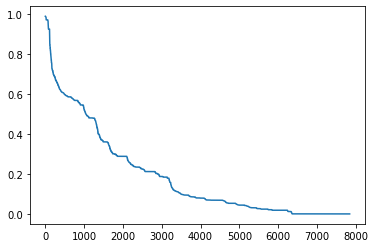

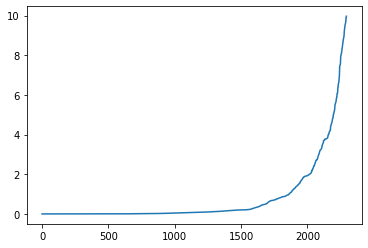

var_drop 409
single_drop 95
corr_drop1 3847


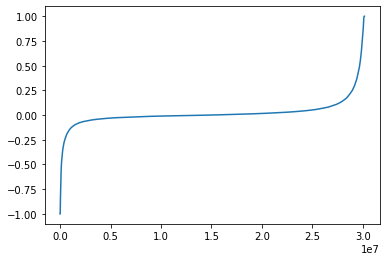

corr_drop2 0
4211 drop_list


,ID,report_timestamp,BureauScoreConfidLevel,MissingRate,Current_Finance_Purpose,Current_Amount_Financed,Current_Gender_Code,First_Name1,Len_Name,Name_nuniq,Tel_nuniq,IncomeTaxPAN_5,Len_of_addrs,City_nuniq,PinCode3,Current_State,Current_City,CreditAccountActive,CreditAccountActivePor,State_nuniq,TotalCAPSLast90Days,TotalCAPSLast7Days,TotalCAPSLast30Days,TotalCAPSLast180Days,CAPSLast7Days,CAPSLast180Days,Pin_nuniq,Pan_nuniq,Ident_nuniq,Pan_nuniq2,Account_nuniq2,Ident_nuniq2,Gender_nuniq,Amount_Past_Due35_max_30,Amount_Past_Due35_mean_90,Amount_Past_Due35_max_90,Amount_Past_Due35_min_90,Amount_Past_Due35_std_90,Amount_Past_Due35_max_9999,Amount_Past_Due35_min_9999,Highest_Credit_or_Original_Loan_Amount58_sum_360,Terms_Duration34_std_30,Terms_Duration34_std_90,Terms_Duration34_sum_360,Terms_Duration34_max_360,Terms_Duration34_mean_9999,Terms_Duration34_std_9999,Payment_Rating34_sum_90,Payment_Rating34_mean_90,Payment_Rating34_min_90,Payment_Rating34_std_90,Payment_Rating34_sum_360,Payment_Rating34_mean_360,Payment_Rating34_max_360,Payment_Rating34_min_360,Payment_Rating34_std_360,Payment_Rating34_sum_9999,Payment_Rating34_max_9999,Payment_Rating34_min_9999,Payment_Rating34_std_9999,Current_Balance35_sum_360,Current_Balance35_max_360,Current_Balance35_std_360,Current_Balance35_mean_9999,Settlement_Amount37_mean_360,Settlement_Amount37_std_360,Settlement_Amount37_mean_9999,Settlement_Amount37_max_9999,Settlement_Amount37_min_9999,Value_of_Collateral39_std_90,Value_of_Collateral39_std_360,Written_Off_Amt_Total41_sum_360,Written_Off_Amt_Total41_std_360,Written_Off_Amt_Total41_mean_9999,Written_Off_Amt_Total41_max_9999,Written_Off_Amt_Total41_min_9999,Written_Off_Amt_Total41_std_9999,Written_Off_Amt_Principal45_sum_360,Written_Off_Amt_Principal45_min_360,Written_Off_Amt_Principal45_std_360,Written_Off_Amt_Principal45_sum_9999,Written_Off_Amt_Principal45_mean_9999,Written_Off_Amt_Principal45_max_9999,Written_Off_Amt_Principal45_min_9999,Rate_of_Interest36_sum_30,Rate_of_Interest36_max_30,Rate_of_Interest36_min_30,Rate_of_Interest36_std_30,Rate_of_Interest36_sum_90,Rate_of_Interest36_mean_90,Rate_of_Interest36_max_90,Rate_of_Interest36_min_90,Rate_of_Interest36_std_90,Rate_of_Interest36_sum_360,Rate_of_Interest36_sum_9999,Rate_of_Interest36_mean_9999,Rate_of_Interest36_max_9999,Rate_of_Interest36_std_9999,Repayment_Tenure36_std_30,Repayment_Tenure36_std_90,Repayment_Tenure36_mean_360,Repayment_Tenure36_min_360,Repayment_Tenure36_std_360,Repayment_Tenure36_sum_9999,Repayment_Tenure36_mean_9999,Repayment_Tenure36_max_9999,Repayment_Tenure36_min_9999,Repayment_Tenure36_std_9999,Income26_count_30,Income26_min_9999,Income26_std_9999,Open_Date29_max_30,Open_Date29_mean_30,Open_Date29_mode_30,Open_Date29_nuniq_30,Open_Date29_maxcount_30,Open_Date29_mode_90,Open_Date29_nuniq_90,Open_Date29_max_360,Open_Date29_mode_360,Open_Date29_maxcount_360,Open_Date29_max_9999,Open_Date29_mean_9999,Open_Date29_mode_9999,Open_Date29_maxcount_9999,Portfolio_Type34_nuniq_30,Portfolio_Type34_nuniq_90,Portfolio_Type34_nuniq_360,Portfolio_Type34_mode_9999,Portfolio_Type34_nuniq_9999,Account_Type32_mode_30,Account_Type32_nuniq_30,Account_Type32_mode_90,Account_Type32_nuniq_90,Account_Type32_mode_360,Account_Type32_nuniq_360,Account_Type32_mode_9999,Account_Type32_nuniq_9999,Occupation_Code35_nuniq_30,Occupation_Code35_nuniq_90,Occupation_Code35_nuniq_360,CurrencyCode32_mode_360,CurrencyCode32_mode_9999,AccountHoldertypeCode41_mode_90,AccountHoldertypeCode41_nuniq_90,AccountHoldertypeCode41_nuniq_360,AccountHoldertypeCode41_nuniq_9999,Payment_History_Profile43_mode_30,Payment_History_Profile43_mode_90,Payment_History_Profile43_nuniq_90,Payment_History_Profile43_mode_360,Payment_History_Profile43_nuniq_360,Payment_History_Profile43_mode_9999,Payment_History_Profile43_nuniq_9999,Date_Closed31_mode_30,Date_Closed31_nuniq_30,Date_Closed31_maxcount_30,Date_Closed31_max_90,Date_Closed31_min_90,Date_Closed31_mean_90,Date_Closed31_mode_90,Date_Closed31_nuniq_90,Date_Closed31

./data/top30_tofeaturetools.pkl ok


In [3]:
%load_ext autoreload
%autoreload 1
%reload_ext autoreload
import feas_ft
import imp
imp.reload(feas_ft)


feas_ft.featuretools_topfeas(basedf_file='./data/filter_feas_df32n_old.pkl', importance_file='./data/feature_importance.pkl', catefeas=[],join_key='ID',final_file='./data/top30_tofeaturetools.pkl',topn=1)


### 原特征+ 等频4分箱onehot+  lgb特征--》3DNN or tabnet




,ID,report_timestamp,BureauScore,BureauScoreConfidLevel,MissingRate,Current_Finance_Purpose,Current_Amount_Financed,Current_Gender_Code,First_Name1,Len_Name,Name_nuniq,Tel_nuniq,Email_nuniq,IncomeTaxPAN_5,Len_of_addrs,City_nuniq,PinCode3,Current_State,Current_City,CreditAccountActive,CreditAccountActivePor,Outstanding_Balance_UnSecured_Percentage,Outstanding_Balance_UnSecured,Diff_dateBirth,State_nuniq,Birth_nuniq,TotalCAPSLast90Days,TotalCAPSLast7Days,TotalCAPSLast30Days,TotalCAPSLast180Days,CAPSLast7Days,CAPSLast180Days,Pin_nuniq,Pan_nuniq,Ident_nuniq,Name_nuniq2,Tel_nuniq2,Email_nuniq2,Pan_nuniq2,Account_nuniq2,Ident_nuniq2,Gender_nuniq,Amount_Past_Due35_max_30,Amount_Past_Due35_mean_90,Amount_Past_Due35_max_90,Amount_Past_Due35_min_90,Amount_Past_Due35_std_90,Amount_Past_Due35_sum_360,Amount_Past_Due35_max_360,Amount_Past_Due35_min_360,Amount_Past_Due35_std_360,Amount_Past_Due35_mean_9999,Amount_Past_Due35_max_9999,Amount_Past_Due35_min_9999,Amount_Past_Due35_std_9999,Highest_Credit_or_Original_Loan_Amount58_std_90,Highest_Credit_or_Original_Loan_Amount58_sum_360,Highest_Credit_or_Original_Loan_Amount58_sum_9999,Highest_Credit_or_Original_Loan_Amount58_max_9999,Terms_Duration34_std_30,Terms_Duration34_std_90,Terms_Duration34_sum_360,Terms_Duration34_max_360,Terms_Duration34_mean_9999,Terms_Duration34_std_9999,Payment_Rating34_sum_90,Payment_Rating34_mean_90,Payment_Rating34_min_90,Payment_Rating34_std_90,Payment_Rating34_sum_360,Payment_Rating34_mean_360,Payment_Rating34_max_360,Payment_Rating34_min_360,Payment_Rating34_std_360,Payment_Rating34_sum_9999,Payment_Rating34_mean_9999,Payment_Rating34_max_9999,Payment_Rating34_min_9999,Payment_Rating34_std_9999,Current_Balance35_sum_360,Current_Balance35_max_360,Current_Balance35_std_360,Current_Balance35_sum_9999,Current_Balance35_mean_9999,Settlement_Amount37_mean_360,Settlement_Amount37_std_360,Settlement_Amount37_mean_9999,Settlement_Amount37_max_9999,Settlement_Amount37_min_9999,Value_of_Collateral39_std_90,Value_of_Collateral39_std_360,Written_Off_Amt_Total41_sum_360,Written_Off_Amt_Total41_std_360,Written_Off_Amt_Total41_mean_9999,Written_Off_Amt_Total41_max_9999,Written_Off_Amt_Total41_min_9999,Written_Off_Amt_Total41_std_9999,Written_Off_Amt_Principal45_sum_360,Written_Off_Amt_Principal45_min_360,Written_Off_Amt_Principal45_std_360,Written_Off_Amt_Principal45_sum_9999,Written_Off_Amt_Principal45_mean_9999,Written_Off_Amt_Principal45_max_9999,Written_Off_Amt_Principal45_min_9999,Rate_of_Interest36_sum_30,Rate_of_Interest36_max_30,Rate_of_Interest36_min_30,Rate_of_Interest36_std_30,Rate_of_Interest36_sum_90,Rate_of_Interest36_mean_90,Rate_of_Interest36_max_90,Rate_of_Interest36_min_90,Rate_of_Interest36_std_90,Rate_of_Interest36_sum_360,Rate_of_Interest36_sum_9999,Rate_of_Interest36_mean_9999,Rate_of_Interest36_max_9999,Rate_of_Interest36_min_9999,Rate_of_Interest36_std_9999,Repayment_Tenure36_std_30,Repayment_Tenure36_std_90,Repayment_Tenure36_mean_360,Repayment_Tenure36_min_360,Repayment_Tenure36_std_360,Repayment_Tenure36_sum_9999,Repayment_Tenure36_mean_9999,Repayment_Tenure36_max_9999,Repayment_Tenure36_min_9999,Repayment_Tenure36_std_9999,Income26_count_30,Income26_std_90,Income26_min_9999,Income26_std_9999,Open_Date29_max_30,Open_Date29_mean_30,Open_Date29_mode_30,Open_Date29_nuniq_30,Open_Date29_maxcount_30,Open_Date29_mode_90,Open_Date29_nuniq_90,Open_Date29_max_360,Open_Date29_mode_360,Open_Date29_maxcount_360,Open_Date29_max_9999,Open_Date29_mean_9999,Open_Date29_mode_9999,Open_Date29_maxcount_9999,Portfolio_Type34_nuniq_30,Portfolio_Type34_nuniq_90,Portfolio_Type34_nuniq_360,Portfolio_Type34_mode_9999,Portfolio_Type34_nuniq_9999,Account_Type32_mode_30,Account_Type32_nuniq_30,Account_Type32_mode_90,Account_Type32_nuniq_90,Account_Type32_mode_360,Account_Type32_nuniq_360,Account_Type32_mode_9999,Account_Type32_nuniq_9999,Occupation_Code35_nuniq_30,Occupation_Code35_nuniq_90,Occupation_Code35_nuniq_360,CurrencyCode32_mode_360,CurrencyCode32_mode_9999,AccountHold

##### 验证神经网络模型，取开头代码的逻辑 加工出trainx ootx，如下训练神经网络

In [6]:
#  './data/filter_feas_df32n_old_qcut_oh.pkl' 
train_x, test_x, train_y, test_y,oot_x, oot_y,df,final_feas = read_train('./data/filter_feas_df_0403_n_old.pkl',model='nn')

(9123, 1802)
1.0    5631
0.0    2040
Name: label, dtype: int64
1.0    1035
0.0     417
Name: label, dtype: int64


,BureauScore,MissingRate,Len_Name,Tel_nuniq,Email_nuniq,Len_of_addrs,City_nuniq,Current_State,CreditAccountActive,CreditAccountTotal,CreditAccountActivePor,Outstanding_Balance_Secured,Outstanding_Balance_UnSecured_Percentage,Outstanding_Balance_All,Outstanding_Balance_Secured_Percentage,Outstanding_Balance_UnSecured,Diff_dateBirth,State_nuniq,Birth_nuniq,TotalCAPSLast90Days,TotalCAPSLast7Days,TotalCAPSLast30Days,TotalCAPSLast180Days,CAPSLast30Days,CAPSLast7Days,CAPSLast180Days,NonCreditCAPSLast180Days,Pin_nuniq,Pan_nuniq,Ident_nuniq,Name_nuniq2,Tel_nuniq2,Email_nuniq2,Pan_nuniq2,Account_nuniq2,Ident_nuniq2,Gender_nuniq,Amount_Past_Due35_sum_30,Amount_Past_Due35_min_30,Amount_Past_Due35_sum_90,Amount_Past_Due35_mean_90,Amount_Past_Due35_max_90,Amount_Past_Due35_min_90,Amount_Past_Due35_std_90,Amount_Past_Due35_sum_360,Amount_Past_Due35_mean_360,Amount_Past_Due35_max_360,Amount_Past_Due35_std_360,Amount_Past_Due35_sum_9999,Amount_Past_Due35_max_9999,Amount_Past_Due35_min_9999,Amount_Past_Due35_std_9999,Highest_Credit_or_Original_Loan_Amount58_max_30,Highest_Credit_or_Original_Loan_Amount58_min_30,Highest_Credit_or_Original_Loan_Amount58_std_30,Highest_Credit_or_Original_Loan_Amount58_sum_90,Highest_Credit_or_Original_Loan_Amount58_mean_90,Highest_Credit_or_Original_Loan_Amount58_max_90,Highest_Credit_or_Original_Loan_Amount58_min_90,Highest_Credit_or_Original_Loan_Amount58_std_90,Highest_Credit_or_Original_Loan_Amount58_sum_360,Highest_Credit_or_Original_Loan_Amount58_max_360,Highest_Credit_or_Original_Loan_Amount58_std_360,Highest_Credit_or_Original_Loan_Amount58_sum_9999,Highest_Credit_or_Original_Loan_Amount58_mean_9999,Highest_Credit_or_Original_Loan_Amount58_max_9999,Highest_Credit_or_Original_Loan_Amount58_std_9999,Terms_Duration34_sum_30,Terms_Duration34_std_30,Terms_Duration34_sum_90,Terms_Duration34_std_90,Terms_Duration34_mean_360,Terms_Duration34_max_360,Terms_Duration34_min_360,Terms_Duration34_std_360,Terms_Duration34_sum_9999,Terms_Duration34_mean_9999,Terms_Duration34_max_9999,Terms_Duration34_min_9999,Terms_Duration34_std_9999,Payment_Rating34_sum_90,Payment_Rating34_mean_90,Payment_Rating34_max_90,Payment_Rating34_min_90,Payment_Rating34_std_90,Payment_Rating34_sum_360,Payment_Rating34_mean_360,Payment_Rating34_max_360,Payment_Rating34_min_360,Payment_Rating34_std_360,Payment_Rating34_sum_9999,Payment_Rating34_mean_9999,Payment_Rating34_max_9999,Payment_Rating34_min_9999,Payment_Rating34_std_9999,Current_Balance35_mean_30,Current_Balance35_min_30,Current_Balance35_std_30,Current_Balance35_sum_90,Current_Balance35_mean_90,Current_Balance35_max_90,Current_Balance35_std_90,Current_Balance35_sum_360,Current_Balance35_max_360,Current_Balance35_std_360,Current_Balance35_max_9999,Current_Balance35_std_9999,Settlement_Amount37_max_360,Settlement_Amount37_min_360,Settlement_Amount37_std_360,Settlement_Amount37_sum_9999,Settlement_Amount37_mean_9999,Settlement_Amount37_max_9999,Settlement_Amount37_min_9999,Settlement_Amount37_std_9999,Value_of_Collateral39_std_90,Value_of_Collateral39_std_360,Written_Off_Amt_Total41_sum_360,Written_Off_Amt_Total41_mean_360,Written_Off_Amt_Total41_min_360,Written_Off_Amt_Total41_std_360,Written_Off_Amt_Total41_sum_9999,Written_Off_Amt_Total41_mean_9999,Written_Off_Amt_Total41_max_9999,Written_Off_Amt_Total41_min_9999,Written_Off_Amt_Total41_std_9999,Written_Off_Amt_Principal45_sum_360,Written_Off_Amt_Principal45_mean_360,Written_Off_Amt_Principal45_min_360,Written_Off_Amt_Principal45_std_360,Written_Off_Amt_Principal45_max_9999,Written_Off_Amt_Principal45_min_9999,Rate_of_Interest36_sum_30,Rate_of_Interest36_std_30,Rate_of_Interest36_sum_90,Rate_of_Interest36_mean_90,Rate_of_Interest36_max_90,Rate_of_Interest36_std_90,Rate_of_Interest36_sum_360,Rate_of_Interest36_mean_360,Rate_of_Interest36_max_360,Rate_of_Interest36_min_360,Rate_of_Interest36_std_360,Rate_of_Interest36_sum_9999,Rate_of_Interest36_mean_9999,Rate_of_Interest36_max_9999,Rate_of_Interest36_min_9999,Rate_of_Interest36_std_9999

(6136, 1761)


In [6]:
def model_metrics2(nnmodel, x, y):
    yprob = nnmodel.predict(x.replace([np.inf, -np.inf], np.nan).fillna(0))[:,0]
    fpr,tpr,_ = roc_curve(y, yprob,pos_label=1)
    return auc(fpr, tpr),max(tpr-fpr)

np.random.seed(1) # 固定随机种子，使每次运行结果固定
random.set_seed(1)

bestval = 0
# 创建模型结构：输入层的特征维数为13；1层k个神经元的relu隐藏层；线性的输出层；
for layer_nums in range(1,4):
    for k in list(range(1,20,1)) + list(range(20,100,2)) + list(range(100,1000,30)):  # 网格搜索超参数：神经元数,5,10,100
        for norm in [0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.8]:
            print("隐藏层vs神经元数vs norm",layer_nums,k,norm)
            model = Sequential()
            model.add(BatchNormalization())  # 输入层 批标准化  input_dim=train_x.shape
            for _ in range(layer_nums):
                model.add(Dense(k,  
                                kernel_initializer='random_uniform',   # 均匀初始化
                                activation='relu',                     # relu激活函数
                                kernel_regularizer=regularizers.l1_l2(l1=norm, l2=norm),  # L1及L2 正则项
                                use_bias=True))   # 隐藏层1
                model.add(Dropout(norm)) # dropout正则
            model.add(Dense(1,use_bias=True,activation='sigmoid'))  # 输出层



            # 编译模型：优化目标为回归预测损失mse，优化算法为adam
            model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy) 

            # 训练模型
            history = model.fit(train_x.replace([np.inf, -np.inf], np.nan).fillna(0), 
                                train_y, 
                                epochs=1000,              # 训练迭代次数
                                batch_size=1000,           # 每epoch采样的batch大小
                                validation_data=(test_x.replace([np.inf, -np.inf], np.nan).fillna(0),test_y),   # 从训练集再拆分验证集，作为早停的衡量指标
                                callbacks=[EarlyStopping(monitor='val_loss', patience=10)],    #早停法
                                verbose=False)  # 不输出过程  
            print("验证集最优结果：",min(history.history['loss']),min(history.history['val_loss']))
            print('------------train------------\n',model_metrics2(model, train_x,train_y))

            print('------------test------------\n',model_metrics2(model, test_x,test_y))

            print('------------oot------------\n',model_metrics2(model, oot_x,oot_y))
            if model_metrics2(model, test_x,test_y)[0] > bestval: # 仅以test调参
                bestval = model_metrics2(model, oot_x,oot_y)[0]
                best_paras = ['bestval, layer_nums, k, norm',bestval, layer_nums, k, norm]

# 模型评估：拟合效果
plt.plot(history.history['loss'],c='blue')    # 蓝色线训练集损失
plt.plot(history.history['val_loss'],c='red') # 红色线验证集损失
plt.show()
model.summary()   #模型概述信息
print(best_paras)
    

隐藏层vs神经元数vs norm 1 1 0.01
验证集最优结果： 0.5632795691490173 0.5629227161407471
------------train------------
 (0.6999401031038774, 0.2912448334697088)
------------test------------
 (0.6653864090606263, 0.24184987785920498)
------------oot------------
 (0.6427333495522423, 0.20558857262016472)
隐藏层vs神经元数vs norm 1 1 0.05
验证集最优结果： 0.5918880105018616 0.5820297002792358
------------train------------
 (0.49988866622133155, 0.0)
------------test------------
 (0.49956140350877193, 0.0)
------------oot------------
 (0.5007171074734416, 0.0023980815347721673)
隐藏层vs神经元数vs norm 1 1 0.1
验证集最优结果： 0.6019687056541443 0.5919893383979797
------------train------------
 (0.5, 0.0)
------------test------------
 (0.4986842105263158, 0.0)
------------oot------------
 (0.5031128720212236, 0.006228061029437293)
隐藏层vs神经元数vs norm 1 1 0.2
验证集最优结果： 0.6225577592849731 0.6120771765708923
------------train------------
 (0.5, 0.0)
------------test------------
 (0.5, 0.0)
------------oot------------
 (0.5019149897473325, 0.00

------------oot------------
 (0.5945933108585595, 0.14171619226358045)
隐藏层vs神经元数vs norm 1 4 0.5
验证集最优结果： 1.0289721488952637 1.0122432708740234
------------train------------
 (0.5246064570884423, 0.04504842173370721)
------------test------------
 (0.5375971574505884, 0.08112369531423502)
------------oot------------
 (0.5260116544445603, 0.06216244395787718)
隐藏层vs神经元数vs norm 1 4 0.8
验证集最优结果： 1.2710920572280884 1.2460967302322388
------------train------------
 (0.5605371499500182, 0.09602345521844097)
------------test------------
 (0.5377315123251165, 0.07061958694203863)
------------oot------------
 (0.5379418204566782, 0.09604837868835364)
隐藏层vs神经元数vs norm 1 5 0.01
验证集最优结果： 0.5756060481071472 0.577660083770752
------------train------------
 (0.7081079416516247, 0.3099076234197541)
------------test------------
 (0.6582656007106373, 0.24309349322673768)
------------oot------------
 (0.6420255100267611, 0.21160810482049142)
隐藏层vs神经元数vs norm 1 5 0.05
验证集最优结果： 0.643292248249054 0.62943589687

------------test------------
 (0.5820286475682878, 0.1517543859649123)
------------oot------------
 (0.6094058086863842, 0.15808570534876443)
隐藏层vs神经元数vs norm 1 8 0.2
验证集最优结果： 0.9278296828269958 0.9122298359870911
------------train------------
 (0.5522772664545572, 0.08075198015077772)
------------test------------
 (0.5212103042416167, 0.07297357317343994)
------------oot------------
 (0.5731125244731751, 0.1336947833037918)
隐藏层vs神经元数vs norm 1 8 0.3
验证集最优结果： 1.1024572849273682 1.0837979316711426
------------train------------
 (0.5738381186554128, 0.1197415432012286)
------------test------------
 (0.5632778147901399, 0.10167666000444148)
------------oot------------
 (0.5977061828797832, 0.16599589893302746)
隐藏层vs神经元数vs norm 1 8 0.4
验证集最优结果： 1.2668726444244385 1.2472553253173828
------------train------------
 (0.5551349913606342, 0.0771656111953728)
------------test------------
 (0.5120164334887852, 0.051565622918054665)
------------oot------------
 (0.5280332255934383, 0.072005004691898

验证集最优结果： 2.4401729106903076 2.413257598876953
------------train------------
 (0.5350573487400332, 0.053217004762649234)
------------test------------
 (0.5205984898956252, 0.06231401288030203)
------------oot------------
 (0.5577149874303456, 0.11042296597504603)
隐藏层vs神经元数vs norm 1 12 0.01
验证集最优结果： 0.600651741027832 0.6008598804473877
------------train------------
 (0.6952782295425026, 0.28307909300532846)
------------test------------
 (0.6585409726848768, 0.2350322007550522)
------------oot------------
 (0.6457465911328908, 0.21659194383623537)
隐藏层vs神经元数vs norm 1 12 0.05
验证集最优结果： 0.717868983745575 0.7086804509162903
------------train------------
 (0.6599501603680173, 0.22633243521829205)
------------test------------
 (0.6292493892960249, 0.20848323339995561)
------------oot------------
 (0.6315921176102596, 0.19938136447363847)
隐藏层vs神经元数vs norm 1 12 0.1
验证集最优结果： 0.8477657437324524 0.8381556868553162
------------train------------
 (0.5872985416966997, 0.12002728861979273)
------------te

------------oot------------
 (0.5930015407963484, 0.1422583672192681)
隐藏层vs神经元数vs norm 1 15 0.3
验证集最优结果： 1.5481128692626953 1.5303761959075928
------------train------------
 (0.5675218725191009, 0.10462762742641651)
------------test------------
 (0.5506906506773261, 0.08457694870086607)
------------oot------------
 (0.5666168514463791, 0.11523303096653104)
隐藏层vs神经元数vs norm 1 15 0.4
验证集最优结果： 1.8410825729370117 1.8218938112258911
------------train------------
 (0.5575197676677233, 0.09379759180637537)
------------test------------
 (0.5420164334887853, 0.0861092604930046)
------------oot------------
 (0.5801051912093513, 0.11842352205192369)
隐藏层vs神经元数vs norm 1 15 0.5
验证集最优结果： 2.1789653301239014 2.1437530517578125
------------train------------
 (0.5443147016762333, 0.06975761722702417)
------------test------------
 (0.5401754385964912, 0.10300910504108374)
------------oot------------
 (0.5655834752487865, 0.11257776387585583)
隐藏层vs神经元数vs norm 1 15 0.8
验证集最优结果： 3.069934606552124 3.035814285

------------train------------
 (0.6966335237174788, 0.29068823225647517)
------------test------------
 (0.6553320008882968, 0.2369753497668221)
------------oot------------
 (0.6382175419085021, 0.21785701873283986)
隐藏层vs神经元数vs norm 1 19 0.05
验证集最优结果： 0.7881994843482971 0.7775835394859314
------------train------------
 (0.600956184574485, 0.14696221216495808)
------------test------------
 (0.5655796135909394, 0.11028203419942262)
------------oot------------
 (0.6057414937615124, 0.18069023042435617)
隐藏层vs神经元数vs norm 1 19 0.1
验证集最优结果： 0.991708517074585 0.9796768426895142
------------train------------
 (0.6121225226542243, 0.15909847388123083)
------------test------------
 (0.5870508549855652, 0.14904508105707304)
------------oot------------
 (0.6128106210683628, 0.17430924825357108)
隐藏层vs神经元数vs norm 1 19 0.2
验证集最优结果： 1.4057468175888062 1.3929623365402222
------------train------------
 (0.6020538205759712, 0.1426664203110713)
------------test------------
 (0.566528980679547, 0.10427492782

隐藏层vs神经元数vs norm 1 24 0.4
验证集最优结果： 2.586402654647827 2.559246301651001
------------train------------
 (0.5504634395437278, 0.09295835845957368)
------------test------------
 (0.540649566955363, 0.07793693093493226)
------------oot------------
 (0.5692385222256977, 0.1206339276404963)
隐藏层vs神经元数vs norm 1 24 0.5
验证集最优结果： 3.1326842308044434 3.1106321811676025
------------train------------
 (0.5306027116712316, 0.05385252098252569)
------------test------------
 (0.5320131023761936, 0.07075283144570277)
------------oot------------
 (0.5031707966959765, 0.031925763736836615)
隐藏层vs神经元数vs norm 1 24 0.8
验证集最优结果： 4.529725551605225 4.502154350280762
------------train------------
 (0.5120559254273491, 0.03599052207758979)
------------test------------
 (0.5058061292471685, 0.04196091494559173)
------------oot------------
 (0.5194012905617535, 0.05209745247280437)
隐藏层vs神经元数vs norm 1 26 0.01
验证集最优结果： 0.6397935152053833 0.6356943845748901
------------train------------
 (0.6818035936784071, 0.2699771714

------------test------------
 (0.5816366866533422, 0.14612480568509878)
------------oot------------
 (0.6129681761836907, 0.1789733430646787)
隐藏层vs神经元数vs norm 1 32 0.1
验证集最优结果： 1.2668054103851318 1.2552183866500854
------------train------------
 (0.6037117125165562, 0.15365509810570144)
------------test------------
 (0.5600244281590051, 0.12244059515878303)
------------oot------------
 (0.595876921651085, 0.14470510548083276)
隐藏层vs神经元数vs norm 1 32 0.2
验证集最优结果： 1.947908639907837 1.9304907321929932
------------train------------
 (0.5519201185214062, 0.09050806780734721)
------------test------------
 (0.536554519209416, 0.07873639795691756)
------------oot------------
 (0.5456376927443553, 0.09087686372641018)
隐藏层vs神经元数vs norm 1 32 0.3
验证集最优结果： 2.6143252849578857 2.592398166656494
------------train------------
 (0.5901888207350195, 0.13426109226220084)
------------test------------
 (0.563514323784144, 0.11522318454363756)
------------oot------------
 (0.5995991612507096, 0.141507663434469

隐藏层vs神经元数vs norm 1 38 0.5
验证集最优结果： 4.536813259124756 4.504776477813721
------------train------------
 (0.5161025868014313, 0.04020252595701368)
------------test------------
 (0.5341083721963136, 0.08310015545192095)
------------oot------------
 (0.5125348996165386, 0.046856427901157294)
隐藏层vs神经元数vs norm 1 38 0.8
验证集最优结果： 6.866541862487793 6.8228840827941895
------------train------------
 (0.5238948684264849, 0.046784281159414354)
------------test------------
 (0.5121385742838107, 0.058394403730846145)
------------oot------------
 (0.5403595963808663, 0.08949362249330972)
隐藏层vs神经元数vs norm 1 40 0.01
验证集最优结果： 0.670731782913208 0.6771456003189087
------------train------------
 (0.6761463487596605, 0.25855913109569356)
------------test------------
 (0.6557317343992893, 0.22780368643126797)
------------oot------------
 (0.637055572932958, 0.20910575887116395)
隐藏层vs神经元数vs norm 1 40 0.05
验证集最优结果： 1.0237762928009033 1.0121856927871704
------------train------------
 (0.6156624630551207, 0.168286

------------test------------
 (0.5864401510104376, 0.1524095047745947)
------------oot------------
 (0.6119174225836722, 0.18123935634101418)
隐藏层vs神经元数vs norm 1 46 0.2
验证集最优结果： 2.518087387084961 2.500412940979004
------------train------------
 (0.5723777849518693, 0.11943102686291196)
------------test------------
 (0.5413890739506996, 0.07459471463468798)
------------oot------------
 (0.5619214773109049, 0.10348590692663262)
隐藏层vs神经元数vs norm 1 46 0.3
验证集最优结果： 3.508509635925293 3.489976167678833
------------train------------
 (0.577218401680091, 0.11792663340866127)
------------test------------
 (0.5593471019320453, 0.10695092160781705)
------------oot------------
 (0.6000996304405751, 0.14639418899662876)
隐藏层vs神经元数vs norm 1 46 0.4
验证集最优结果： 4.41191291809082 4.380073070526123
------------train------------
 (0.563691719812472, 0.10583260408016304)
------------test------------
 (0.5641427936930935, 0.10084388185654009)
------------oot------------
 (0.5832342821395058, 0.14036075487436134)


验证集最优结果： 9.162543296813965 9.123723983764648
------------train------------
 (0.5056822865589334, 0.018425638849465242)
------------test------------
 (0.5046169220519654, 0.03580946035976018)
------------oot------------
 (0.48013299505323276, 0.012351857644319342)
隐藏层vs神经元数vs norm 1 54 0.01
验证集最优结果： 0.7009040713310242 0.6965077519416809
------------train------------
 (0.6668502828013338, 0.22708503802606905)
------------test------------
 (0.6529469242727071, 0.23040195425272048)
------------oot------------
 (0.6213023783871454, 0.17668647690543215)
隐藏层vs神经元数vs norm 1 54 0.05
验证集最优结果： 1.1730318069458008 1.1627293825149536
------------train------------
 (0.6054509559476942, 0.147740533414008)
------------test------------
 (0.5812247390628471, 0.12910282034199427)
------------oot------------
 (0.5928914839143178, 0.1459423765335558)
隐藏层vs神经元数vs norm 1 54 0.1
验证集最优结果： 1.7488681077957153 1.7423279285430908
------------train------------
 (0.5884712349386378, 0.1405776767990557)
------------te

------------oot------------
 (0.59342554941554, 0.16783790359017137)
隐藏层vs神经元数vs norm 1 60 0.3
验证集最优结果： 4.373645782470703 4.350134372711182
------------train------------
 (0.578394614287677, 0.12107849606677046)
------------test------------
 (0.5696324672440595, 0.12385076615589607)
------------oot------------
 (0.5880756264553575, 0.16113022625377965)
隐藏层vs神经元数vs norm 1 60 0.4
验证集最优结果： 5.545334815979004 5.5138702392578125
------------train------------
 (0.568404082734872, 0.10354691145208345)
------------test------------
 (0.5790350877192982, 0.15741727737064176)
------------oot------------
 (0.5909278374401927, 0.1382059569735516)
隐藏层vs神经元数vs norm 1 60 0.5
验证集最优结果： 6.752451419830322 6.714202404022217
------------train------------
 (0.523384289687108, 0.044361333271067616)
------------test------------
 (0.5359515878303354, 0.07401732178547638)
------------oot------------
 (0.5425920133458451, 0.0974524728043652)
隐藏层vs神经元数vs norm 1 60 0.8
验证集最优结果： 10.344383239746094 10.290135383605957


------------train------------
 (0.6634940938953218, 0.22311045596765972)
------------test------------
 (0.6498667554963358, 0.22679324894514769)
------------oot------------
 (0.6182358461057242, 0.16885274389184304)
隐藏层vs神经元数vs norm 1 68 0.05
验证集最优结果： 1.3133299350738525 1.3027199506759644
------------train------------
 (0.6163367599772325, 0.18178308660549736)
------------test------------
 (0.5961447923606484, 0.15765045525205412)
------------oot------------
 (0.6312665809381479, 0.21093386160636707)
隐藏层vs神经元数vs norm 1 68 0.1
验证集最优结果： 2.0439541339874268 2.0324361324310303
------------train------------
 (0.6024980051287987, 0.1523525267353349)
------------test------------
 (0.5777825893848545, 0.13136797690428603)
------------oot------------
 (0.6224747738041452, 0.19637854933444548)
隐藏层vs神经元数vs norm 1 68 0.2
验证集最优结果： 3.4275870323181152 3.408886432647705
------------train------------
 (0.5764802824155573, 0.11831295146862453)
------------test------------
 (0.571512325116589, 0.142205196

------------oot------------
 (0.5961758129728101, 0.14767316581517398)
隐藏层vs神经元数vs norm 1 74 0.4
验证集最优结果： 6.747620582580566 6.700944900512695
------------train------------
 (0.534795900480461, 0.07193380343936784)
------------test------------
 (0.5459904508105707, 0.08949589162780369)
------------oot------------
 (0.5588665299644342, 0.12554825704653672)
隐藏层vs神经元数vs norm 1 74 0.5
验证集最优结果： 8.204301834106445 8.175688743591309
------------train------------
 (0.5225749032682048, 0.04098396049105979)
------------test------------
 (0.5043892960248723, 0.027948034643570957)
------------oot------------
 (0.5164807284607097, 0.05222256977027073)
隐藏层vs神经元数vs norm 1 74 0.8
验证集最优结果： 12.65319538116455 12.563420295715332
------------train------------
 (0.5525760064539751, 0.08835502819214924)
------------test------------
 (0.5733144570286476, 0.12841439040639568)
------------oot------------
 (0.57870573106732, 0.12700795885031102)
隐藏层vs神经元数vs norm 1 76 0.01
验证集最优结果： 0.750947117805481 0.7466071844100

------------train------------
 (0.6053962704199347, 0.15759611083023867)
------------test------------
 (0.58320897179658, 0.1404286031534533)
------------oot------------
 (0.6021559563943049, 0.15114864630035107)
隐藏层vs神经元数vs norm 1 82 0.1
验证集最优结果： 2.3198933601379395 2.305149793624878
------------train------------
 (0.6088701550348248, 0.16045911478478742)
------------test------------
 (0.602483899622474, 0.15256495669553638)
------------oot------------
 (0.6214379221260673, 0.20528273033746913)
隐藏层vs神经元数vs norm 1 82 0.2
验证集最优结果： 4.006129741668701 3.9959449768066406
------------train------------
 (0.5846104231428071, 0.11722600892429902)
------------test------------
 (0.5824950033311126, 0.13896291361314683)
------------oot------------
 (0.5734589140281978, 0.10833072672296945)
隐藏层vs神经元数vs norm 1 82 0.3
验证集最优结果： 5.665934085845947 5.622910022735596
------------train------------
 (0.5000393898232127, 0.024105488924488716)
------------test------------
 (0.5014168332222964, 0.03353320008882

隐藏层vs神经元数vs norm 1 88 0.5
验证集最优结果： 9.552407264709473 9.511798858642578
------------train------------
 (0.4664295155660866, 0.0013360053440213762)
------------test------------
 (0.4717177437264046, 0.011669997779258257)
------------oot------------
 (0.4304776468680128, 0.005192367844854551)
隐藏层vs神经元数vs norm 1 88 0.8
验证集最优结果： 14.975366592407227 14.867401123046875
------------train------------
 (0.5018292579755932, 0.021743994574762504)
------------test------------
 (0.49859093937375076, 0.03498778592049745)
------------oot------------
 (0.5073077769668323, 0.030236680221040563)
隐藏层vs神经元数vs norm 1 90 0.01
验证集最优结果： 0.7856626510620117 0.7814663052558899
------------train------------
 (0.6603131964706177, 0.21701071849880105)
------------test------------
 (0.6436442371752165, 0.20451920941594492)
------------oot------------
 (0.61972335175338, 0.16864421506273242)
隐藏层vs神经元数vs norm 1 90 0.05
验证集最优结果： 1.5590448379516602 1.5486067533493042
------------train------------
 (0.6112704300867862, 0.1

------------test------------
 (0.5688718632023095, 0.11480124361536753)
------------oot------------
 (0.6055063195820156, 0.17731206339276406)
隐藏层vs神经元数vs norm 1 96 0.2
验证集最优结果： 4.584980487823486 4.568702697753906
------------train------------
 (0.5869974328934804, 0.1335103844974651)
------------test------------
 (0.5924483677548301, 0.14115034421496775)
------------oot------------
 (0.6013948261680511, 0.15669551315469366)
隐藏层vs神经元数vs norm 1 96 0.3
验证集最优结果： 6.520782947540283 6.492185115814209
------------train------------
 (0.5404660046198442, 0.07015043257741427)
------------test------------
 (0.5509327115256495, 0.08684210526315789)
------------oot------------
 (0.5757805349922961, 0.12568727626594378)
隐藏层vs神经元数vs norm 1 96 0.4
验证集最优结果： 8.4330415725708 8.391386985778809
------------train------------
 (0.49803084723990365, 0.009675006886451037)
------------test------------
 (0.494290473017988, 0.025049966688874048)
------------oot------------
 (0.5073182034082879, 0.0435338685573280

隐藏层vs神经元数vs norm 1 130 0.8
验证集最优结果： 21.766048431396484 21.739280700683594
------------train------------
 (0.46074465716302576, 0.0029015816164581487)
------------test------------
 (0.47607705973795245, 0.005029980013324449)
------------oot------------
 (0.45928474611615056, 0.008751259861675909)
隐藏层vs神经元数vs norm 1 160 0.01
验证集最优结果： 0.9444729089736938 0.9422115087509155
------------train------------
 (0.6486775645177556, 0.2051788819110697)
------------test------------
 (0.6309360426382411, 0.19713524317121917)
------------oot------------
 (0.6152967481087593, 0.1750182462725472)
隐藏层vs神经元数vs norm 1 160 0.05
验证集最优结果： 2.316082715988159 2.306077480316162
------------train------------
 (0.6099025474116082, 0.16623764245816858)
------------test------------
 (0.5985198756384633, 0.15107705973795243)
------------oot------------
 (0.6151507779283819, 0.1702707399297953)
隐藏层vs神经元数vs norm 1 160 0.1
验证集最优结果： 4.000120162963867 3.9866297245025635
------------train------------
 (0.5786775171416795, 0

------------test------------
 (0.5634754608039085, 0.09951143681989794)
------------oot------------
 (0.5958595442486591, 0.1582247245681715)
隐藏层vs神经元数vs norm 1 250 0.3
验证集最优结果： 15.851775169372559 15.778907775878906
------------train------------
 (0.5221606333233844, 0.05876406646457383)
------------test------------
 (0.5198578725294248, 0.05156562291805461)
------------oot------------
 (0.5377784728738748, 0.07802453689222538)
隐藏层vs神经元数vs norm 1 250 0.4
验证集最优结果： 20.897586822509766 20.769439697265625
------------train------------
 (0.46308665964147133, 0.0022089433849122875)
------------test------------
 (0.4682656007106374, 0.009193870752831457)
------------oot------------
 (0.40053059002073704, 0.0)
隐藏层vs神经元数vs norm 1 250 0.5
验证集最优结果： 25.891611099243164 25.72259521484375
------------train------------
 (0.4949908598013318, 0.012512021679292329)
------------test------------
 (0.47331556739951136, 0.011492338441039252)
------------oot------------
 (0.46155655185996136, 0.007590449379626

隐藏层vs神经元数vs norm 1 370 0.01
验证集最优结果： 1.3971515893936157 1.3902980089187622
------------train------------
 (0.6456260714607194, 0.2166078864923362)
------------test------------
 (0.6306018210082167, 0.1906284699089496)
------------oot------------
 (0.6322061191626409, 0.19580161957390607)
隐藏层vs神经元数vs norm 1 370 0.05
验证集最优结果： 4.551682949066162 4.536683082580566
------------train------------
 (0.6120087523916458, 0.16890681058164964)
------------test------------
 (0.5945558516544527, 0.1548412169664668)
------------oot------------
 (0.6268631471634287, 0.18950404893476525)
隐藏层vs神经元数vs norm 1 370 0.1
验证集最优结果： 8.272765159606934 8.238869667053223
------------train------------
 (0.5869009210585981, 0.1320483587912062)
------------test------------
 (0.5751709971130358, 0.12373972906950925)
------------oot------------
 (0.5614464949779308, 0.11017968234108366)
隐藏层vs神经元数vs norm 1 370 0.2
验证集最优结果： 15.830379486083984 15.730233192443848
------------train------------
 (0.5394140526916718, 0.07776160

------------test------------
 (0.5242727070841662, 0.051565622918054554)
------------oot------------
 (0.5388408114088439, 0.06953046258645257)
隐藏层vs神经元数vs norm 1 460 0.4
验证集最优结果： 37.77125930786133 37.606712341308594
------------train------------
 (0.5047943235339305, 0.024911694378287164)
------------test------------
 (0.49804352653786366, 0.02965800577392852)
------------oot------------
 (0.48729827732017283, 0.008104820491433018)
隐藏层vs神经元数vs norm 1 460 0.5
验证集最优结果： 47.58600997924805 47.24610137939453
------------train------------
 (0.5421153688667439, 0.07674612988218926)
------------test------------
 (0.5507550521874307, 0.09925605152120809)
------------oot------------
 (0.5288395370659994, 0.0612657699927015)
隐藏层vs神经元数vs norm 1 460 0.8
验证集最优结果： 74.57430267333984 74.11957550048828
------------train------------
 (0.49388740331050485, 0.00989686228248459)
------------test------------
 (0.46557850322007543, 0.004086164779036228)
------------oot------------
 (0.48340226369628936, 0.007

隐藏层vs神经元数vs norm 1 580 0.05
验证集最优结果： 6.696259021759033 6.673657417297363
------------train------------
 (0.5968869180441261, 0.14836806338106812)
------------test------------
 (0.5845103264490339, 0.1571729957805908)
------------oot------------
 (0.5791946153222349, 0.14990442428665757)
隐藏层vs神经元数vs norm 1 580 0.1
验证集最优结果： 12.670464515686035 12.63931655883789
------------train------------
 (0.5893278620733531, 0.13801002883849423)
------------test------------
 (0.5786364645791695, 0.1380524095047746)
------------oot------------
 (0.6041369802708558, 0.15867653703124457)
隐藏层vs神经元数vs norm 1 580 0.2
验证集最优结果： 24.383312225341797 24.26953125
------------train------------
 (0.5554982305035603, 0.10138114797646625)
------------test------------
 (0.5578147901399068, 0.09957805907172995)
------------oot------------
 (0.579216626698641, 0.15055781461787088)
隐藏层vs神经元数vs norm 1 580 0.3
验证集最优结果： 36.385826110839844 36.304744720458984
------------train------------
 (0.5360385072745965, 0.05715706996566

------------test------------
 (0.513664223850766, 0.058338885187652734)
------------oot------------
 (0.513916982356144, 0.04949779306989194)
隐藏层vs神经元数vs norm 1 670 0.5
验证集最优结果： 69.34452819824219 68.83586883544922
------------train------------
 (0.5337593796170524, 0.0537105281146556)
------------test------------
 (0.5377836997557184, 0.06590051077059744)
------------oot------------
 (0.5494166985252378, 0.08227157404511173)
隐藏层vs神经元数vs norm 1 670 0.8
验证集最优结果： 109.93346405029297 109.04301452636719
------------train------------
 (0.5336323440531857, 0.06858296126193619)
------------test------------
 (0.5168110148789695, 0.06337996890961584)
------------oot------------
 (0.5581760678413791, 0.10913008723456019)
隐藏层vs神经元数vs norm 1 700 0.01
验证集最优结果： 2.113158941268921 2.107915163040161
------------train------------
 (0.6148364273294986, 0.17065742427103447)
------------test------------
 (0.6059427048634245, 0.16351321341328)
------------oot------------
 (0.6243677521750715, 0.18294234177875

隐藏层vs神经元数vs norm 1 790 0.1
验证集最优结果： 16.840370178222656 16.77278709411621
------------train------------
 (0.5978355224464464, 0.13978757921110707)
------------test------------
 (0.5829868976238064, 0.16088163446591158)
------------oot------------
 (0.5969890754063416, 0.15226080005560766)
隐藏层vs神经元数vs norm 1 790 0.2
验证集最优结果： 32.75845718383789 32.62289047241211
------------train------------
 (0.46434652486330313, 0.004654361069318602)
------------test------------
 (0.4579991117033089, 0.008971796580057739)
------------oot------------
 (0.43188637495800464, 0.0014318979598929582)
隐藏层vs神经元数vs norm 1 790 0.3
验证集最优结果： 48.86310958862305 48.58615493774414
------------train------------
 (0.5150528683168432, 0.03447083291879266)
------------test------------
 (0.4933422163002442, 0.031045969353764136)
------------oot------------
 (0.4982321389265399, 0.04064226879366073)
隐藏层vs神经元数vs norm 1 790 0.4
验证集最优结果： 64.9920883178711 64.52021789550781
------------train------------
 (0.5209589729949599, 0.039

------------test------------
 (0.5285964912280701, 0.0705973795247612)
------------oot------------
 (0.5278756704781102, 0.07629374761060714)
隐藏层vs神经元数vs norm 1 880 0.8
验证集最优结果： 145.0255889892578 144.01722717285156
------------train------------
 (0.5603596927052349, 0.09394648804532402)
------------test------------
 (0.521646679991117, 0.05928270042194095)
------------oot------------
 (0.548145831161158, 0.11376637820178637)
隐藏层vs神经元数vs norm 1 910 0.01
验证集最优结果： 2.533703327178955 2.528846025466919
------------train------------
 (0.6261438107555874, 0.18852321326205262)
------------test------------
 (0.5894936708860758, 0.13758605374194988)
------------oot------------
 (0.6211297628563816, 0.16961039863761168)
隐藏层vs神经元数vs norm 1 910 0.05
验证集最优结果： 10.113536834716797 10.073140144348145
------------train------------
 (0.592311878062102, 0.14925480816411607)
------------test------------
 (0.5896313568731957, 0.14753497668221188)
------------oot------------
 (0.5730777696683234, 0.13625273694

------------train------------
 (0.5078253095180567, 0.022733071682033423)
------------test------------
 (0.518335554075061, 0.07355096602265154)
------------oot------------
 (0.5179670756148703, 0.0579432106488722)
隐藏层vs神经元数vs norm 2 1 0.3
验证集最优结果： 0.6524369120597839 0.6360489130020142
------------train------------
 (0.512963177283307, 0.029927331867382168)
------------test------------
 (0.5038729735731734, 0.045103264490339745)
------------oot------------
 (0.5244279938368146, 0.060091057588711694)
隐藏层vs神经元数vs norm 2 1 0.4
验证集最优结果： 0.6714451909065247 0.663343608379364
------------train------------
 (0.5, 0.0)
------------test------------
 (0.5, 0.0)
------------oot------------
 (0.5, 0.0)
隐藏层vs神经元数vs norm 2 1 0.5
验证集最优结果： 0.6990454196929932 0.6903670430183411
------------train------------
 (0.5, 0.0)
------------test------------
 (0.5, 0.0)
------------oot------------
 (0.5, 0.0)
隐藏层vs神经元数vs norm 2 1 0.8
验证集最优结果： 0.7569366097450256 0.7490699887275696
------------train------------
 (0.

隐藏层vs神经元数vs norm 2 5 0.1
验证集最优结果： 0.6912214756011963 0.6782083511352539
------------train------------
 (0.5235503766736446, 0.043097610283044985)
------------test------------
 (0.5029702420608484, 0.023484343770819427)
------------oot------------
 (0.4916692732770306, 0.017412157230737135)
隐藏层vs神经元数vs norm 2 5 0.2
验证集最优结果： 0.7958901524543762 0.7805889844894409
------------train------------
 (0.48714971313785965, 0.006760836769790779)
------------test------------
 (0.5116411281367977, 0.03990672884743507)
------------oot------------
 (0.4816459875577798, 0.006228061029437293)
隐藏层vs神经元数vs norm 2 5 0.3
验证集最优结果： 0.9065665006637573 0.8882678747177124
------------train------------
 (0.5344781423705229, 0.06153543155206054)
------------test------------
 (0.5279491450144348, 0.08105707306240284)
------------oot------------
 (0.5528736431144939, 0.10331213290237373)
隐藏层vs神经元数vs norm 2 5 0.4
验证集最优结果： 1.0302189588546753 1.0063692331314087
------------train------------
 (0.4893170332559749, 0.0060

------------test------------
 (0.5118809682433934, 0.062258494337108505)
------------oot------------
 (0.5222604525075591, 0.06125186807076077)
隐藏层vs神经元数vs norm 2 8 0.8
验证集最优结果： 2.0011327266693115 1.9772677421569824
------------train------------
 (0.49312715265045454, 0.003679902865508119)
------------test------------
 (0.4917876970908284, 0.01745502998001333)
------------oot------------
 (0.48473337272211214, 0.03004205331387065)
隐藏层vs神经元数vs norm 2 9 0.01
验证集最优结果： 0.5989565849304199 0.5882320404052734
------------train------------
 (0.5123861366772722, 0.032533692850070295)
------------test------------
 (0.5066677770375306, 0.03339995558516545)
------------oot------------
 (0.52767409260997, 0.0628992458207347)
隐藏层vs神经元数vs norm 2 9 0.05
验证集最优结果： 0.6785396337509155 0.6654368042945862
------------train------------
 (0.5468098642404702, 0.06940189057615404)
------------test------------
 (0.5315467466133688, 0.07244059515878304)
------------oot------------
 (0.5177933015906115, 0.04543843

------------oot------------
 (0.5375548836293284, 0.07119869321933758)
隐藏层vs神经元数vs norm 2 12 0.2
验证集最优结果： 1.1166062355041504 1.1053763628005981
------------train------------
 (0.5017557573776394, 0.01464110253604134)
------------test------------
 (0.51293915167666, 0.034465911614479317)
------------oot------------
 (0.49438130654896373, 0.012282348034615809)
隐藏层vs神经元数vs norm 2 12 0.3
验证集最优结果： 1.381953239440918 1.3589918613433838
------------train------------
 (0.5165663985857565, 0.03551811491947082)
------------test------------
 (0.5104319342660447, 0.03427714856762154)
------------oot------------
 (0.5106650911155134, 0.026733395891982092)
隐藏层vs神经元数vs norm 2 12 0.4
验证集最优结果： 1.6295584440231323 1.599900484085083
------------train------------
 (0.45951680463256805, 0.0008552058524343709)
------------test------------
 (0.4623051299133911, 0.008971796580057739)
------------oot------------
 (0.46389555022648554, 0.005261877454558084)
隐藏层vs神经元数vs norm 2 12 0.5
验证集最优结果： 1.892435073852539 1.8

隐藏层vs神经元数vs norm 2 15 0.8
验证集最优结果： 3.246650218963623 3.2142279148101807
------------train------------
 (0.4857088036254881, 0.01203595979530836)
------------test------------
 (0.49305463024650237, 0.028758605374195056)
------------oot------------
 (0.5039944855709635, 0.02954158412400515)
隐藏层vs神经元数vs norm 2 16 0.01
验证集最优结果： 0.6066508293151855 0.6007049679756165
------------train------------
 (0.6818039997590588, 0.27491037461616913)
------------test------------
 (0.6645003331112591, 0.24556962025316453)
------------oot------------
 (0.6400850334225374, 0.21568136794911902)
隐藏层vs神经元数vs norm 2 16 0.05
验证集最优结果： 0.7563672065734863 0.7439347505569458
------------train------------
 (0.4968272241883293, 0.019991891922988225)
------------test------------
 (0.49442926937597154, 0.018565400843881856)
------------oot------------
 (0.4834729317994879, 0.03262781079484239)
隐藏层vs神经元数vs norm 2 16 0.1
验证集最优结果： 0.9335818886756897 0.9213960766792297
------------train------------
 (0.5089480548398384, 0.

------------test------------
 (0.48666555629580277, 0.02904730179880083)
------------oot------------
 (0.5005016276833606, 0.028366871720015292)
隐藏层vs神经元数vs norm 2 19 0.3
验证集最优结果： 1.8458664417266846 1.8270790576934814
------------train------------
 (0.5142696064198644, 0.029062380079307615)
------------test------------
 (0.5077159671330225, 0.0223961803242283)
------------oot------------
 (0.5032368308251949, 0.03009071004066316)
隐藏层vs神经元数vs norm 2 19 0.4
验证集最优结果： 2.2628486156463623 2.2408950328826904
------------train------------
 (0.48599813608980874, 0.002162650190621007)
------------test------------
 (0.49770153231179215, 0.05608483233399958)
------------oot------------
 (0.4880721509748723, 0.01700900149445661)
隐藏层vs神经元数vs norm 2 19 0.5
验证集最优结果： 2.690120220184326 2.684339761734009
------------train------------
 (0.5313610672882407, 0.05317950998247756)
------------test------------
 (0.5242982456140352, 0.05614035087719299)
------------oot------------
 (0.5211900045181247, 0.047669

隐藏层vs神经元数vs norm 2 26 0.01
验证集最优结果： 0.6342704892158508 0.6234913468360901
------------train------------
 (0.5178831150988231, 0.033873623640391204)
------------test------------
 (0.5073328891849879, 0.03474350433044637)
------------oot------------
 (0.5254324076970308, 0.05459979842213189)
隐藏层vs神经元数vs norm 2 26 0.05
验证集最优结果： 0.8619185090065002 0.8486661911010742
------------train------------
 (0.4913136641401682, 0.004498696819508652)
------------test------------
 (0.4857994670219854, 0.01567843659782367)
------------oot------------
 (0.4747158794703368, 0.010489000104264457)
隐藏层vs神经元数vs norm 2 26 0.1
验证集最优结果： 1.1481820344924927 1.1287521123886108
------------train------------
 (0.520053480821826, 0.03692599653883927)
------------test------------
 (0.5545813901843215, 0.09063957361758834)
------------oot------------
 (0.557545847380067, 0.10532791158377647)
隐藏层vs神经元数vs norm 2 26 0.2
验证集最优结果： 1.723750114440918 1.7047396898269653
------------train------------
 (0.571795059216711, 0.10368

------------train------------
 (0.4716025093077069, 0.01014227035631543)
------------test------------
 (0.4900322007550522, 0.014779036198090068)
------------oot------------
 (0.4484296620674475, 0.004260939074827164)
隐藏层vs神经元数vs norm 2 32 0.4
验证集最优结果： 3.4418728351593018 3.4155540466308594
------------train------------
 (0.48599461672416094, 0.00267891405912124)
------------test------------
 (0.4836364645791695, 0.00510770597379525)
------------oot------------
 (0.5244013484864283, 0.07192854412122474)
隐藏层vs神经元数vs norm 2 32 0.5
验证集最优结果： 4.174686908721924 4.148560523986816
------------train------------
 (0.5220201294179038, 0.032408620009353406)
------------test------------
 (0.4906628914057295, 0.010726182544970021)
------------oot------------
 (0.522591781647146, 0.06811246654850023)
隐藏层vs神经元数vs norm 2 32 0.8
验证集最优结果： 6.301677703857422 6.238352298736572
------------train------------
 (0.46090465293978705, 0.0021981145675342706)
------------test------------
 (0.4721141461248057, 0.0167

------------oot------------
 (0.5570836084755384, 0.09661835748792275)
隐藏层vs神经元数vs norm 2 40 0.05
验证集最优结果： 1.0169895887374878 0.9994750022888184
------------train------------
 (0.5000732298775192, 0.020585717195958947)
------------test------------
 (0.5044692427270708, 0.02703753053519875)
------------oot------------
 (0.48953185277864664, 0.007986654154936823)
隐藏层vs神经元数vs norm 2 40 0.1
验证集最优结果： 1.4774994850158691 1.459977149963379
------------train------------
 (0.49448738747335946, 0.008969780154703288)
------------test------------
 (0.49158560959360426, 0.024095047745947173)
------------oot------------
 (0.5071085160856821, 0.035498557675598646)
隐藏层vs神经元数vs norm 2 40 0.2
验证集最优结果： 2.3660590648651123 2.3508365154266357
------------train------------
 (0.4613932356438646, 0.0003852351782254182)
------------test------------
 (0.46115256495669554, 0.015833888518765264)
------------oot------------
 (0.4554883629328422, 0.010078893407013512)
隐藏层vs神经元数vs norm 2 40 0.3
验证集最优结果： 3.256633520126

隐藏层vs神经元数vs norm 2 46 0.4
验证集最优结果： 4.657676696777344 4.577500820159912
------------train------------
 (0.5350998518482423, 0.06466184648933121)
------------test------------
 (0.5438307794803464, 0.08136797690428604)
------------oot------------
 (0.5536648941716191, 0.08519097765266048)
隐藏层vs神经元数vs norm 2 46 0.5
验证集最优结果： 5.764523506164551 5.725671768188477
------------train------------
 (0.5294103911977959, 0.05114423375626631)
------------test------------
 (0.5136420164334887, 0.039351543415500845)
------------oot------------
 (0.5199423070239461, 0.0602926354568519)
隐藏层vs神经元数vs norm 2 46 0.8
验证集最优结果： 8.829113960266113 8.784261703491211
------------train------------
 (0.521625689744907, 0.038817384854139214)
------------test------------
 (0.512407284032867, 0.028858538751943108)
------------oot------------
 (0.5093536764791066, 0.040899454349563824)
隐藏层vs神经元数vs norm 2 48 0.01
验证集最优结果： 0.6844276189804077 0.673397958278656
------------train------------
 (0.5461250769015233, 0.08023084331

------------train------------
 (0.481855910402365, 0.009156983335126823)
------------test------------
 (0.4814512547190762, 0.008238951809904527)
------------oot------------
 (0.4351544851075661, 0.0)
隐藏层vs神经元数vs norm 2 54 0.1
验证集最优结果： 1.7994074821472168 1.7787182331085205
------------train------------
 (0.5503171151489064, 0.08109782550579037)
------------test------------
 (0.5449211636686654, 0.08525427492782589)
------------oot------------
 (0.5592766366616851, 0.10260313488339767)
隐藏层vs神经元数vs norm 2 54 0.2
验证集最优结果： 3.009901285171509 2.9932284355163574
------------train------------
 (0.4672821495743936, 0.0008798414119695064)
------------test------------
 (0.46511658894070623, 0.008949589162780325)
------------oot------------
 (0.46090316152874805, 0.005261877454558084)
隐藏层vs神经元数vs norm 2 54 0.3
验证集最优结果： 4.223016738891602 4.207387924194336
------------train------------
 (0.49321669343414953, 0.013397548220385413)
------------test------------
 (0.5030701754385964, 0.02387297357317341

------------oot------------
 (0.5186123564916183, 0.05581621659194386)
隐藏层vs神经元数vs norm 2 60 0.5
验证集最优结果： 7.274902820587158 7.153940677642822
------------train------------
 (0.5029437463241241, 0.014435084285423283)
------------test------------
 (0.5217199644681324, 0.056073728625360864)
------------oot------------
 (0.5488953764524612, 0.10256838007854585)
隐藏层vs神经元数vs norm 2 60 0.8
验证集最优结果： 11.441972732543945 11.365143775939941
------------train------------
 (0.5013458189597703, 0.01965416818100918)
------------test------------
 (0.4706850988230069, 0.012536087053075712)
------------oot------------
 (0.4916889676664466, 0.01676571786049419)
隐藏层vs神经元数vs norm 2 62 0.01
验证集最优结果： 0.7200490236282349 0.7086277604103088
------------train------------
 (0.5171934547920563, 0.032251060716502244)
------------test------------
 (0.5206950921607816, 0.045591827670441926)
------------oot------------
 (0.5434075927663666, 0.08272338650818478)
隐藏层vs神经元数vs norm 2 62 0.05
验证集最优结果： 1.2818045616149902 1.2

验证集最优结果： 2.116293430328369 2.107830286026001
------------train------------
 (0.46661096593727813, 0.0005724383586490633)
------------test------------
 (0.45992449478125697, 0.010748389962247393)
------------oot------------
 (0.447380066960924, 0.004295693879678875)
隐藏层vs神经元数vs norm 2 68 0.2
验证集最优结果： 3.6779634952545166 3.6484577655792236
------------train------------
 (0.516991294307629, 0.04321253110746992)
------------test------------
 (0.4985343104596935, 0.03194536975349771)
------------oot------------
 (0.516271041138104, 0.04413860216174892)
隐藏层vs神经元数vs norm 2 68 0.3
验证集最优结果： 5.219150543212891 5.182362079620361
------------train------------
 (0.48405328048870444, 0.0011764156479119325)
------------test------------
 (0.48940262047523875, 0.011270264268265606)
------------oot------------
 (0.48348335824094346, 0.022993778889931538)
隐藏层vs神经元数vs norm 2 68 0.4
验证集最优结果： 6.653946876525879 6.56801700592041
------------train------------
 (0.49905965257093043, 0.01326259408381103)
---------

------------test------------
 (0.5237041972018655, 0.05123251165889409)
------------oot------------
 (0.5220055839386462, 0.047919924929621494)
隐藏层vs神经元数vs norm 2 74 0.8
验证集最优结果： 13.785175323486328 13.601162910461426
------------train------------
 (0.4879877282427063, 0.011414250317588914)
------------test------------
 (0.4739029535864979, 0.007517210748389963)
------------oot------------
 (0.5216128546438212, 0.050484829527682185)
隐藏层vs神经元数vs norm 2 76 0.01
验证集最优结果： 0.7522872686386108 0.7411430478096008
------------train------------
 (0.5104391829928008, 0.03718981360221285)
------------test------------
 (0.4912391738840773, 0.026160337552742614)
------------oot------------
 (0.46585572122012536, 0.010266569353213083)
隐藏层vs神经元数vs norm 2 76 0.05
验证集最优结果： 1.4448617696762085 1.429220199584961
------------train------------
 (0.48397788484770954, 0.0158489217543496)
------------test------------
 (0.4752298467688208, 0.006362425049966692)
------------oot------------
 (0.47155203373533056, 0

------------oot------------
 (0.4791505925694227, 0.014124352691759656)
隐藏层vs神经元数vs norm 2 82 0.2
验证集最优结果： 4.336811065673828 4.310375690460205
------------train------------
 (0.49285054404655304, 0.015790716860942466)
------------test------------
 (0.4976315789473685, 0.02969131689984461)
------------oot------------
 (0.5232891947311716, 0.044228964654363434)
隐藏层vs神经元数vs norm 2 82 0.3
验证集最优结果： 6.209153652191162 6.1971869468688965
------------train------------
 (0.47495010283992506, 0.001547844083980232)
------------test------------
 (0.46383411059293805, 0.005740617366200351)
------------oot------------
 (0.46097614661893677, 0.005261877454558084)
隐藏层vs神经元数vs norm 2 82 0.4
验证集最优结果： 8.09310531616211 8.04996395111084
------------train------------
 (0.4928411365114559, 0.011821143130570588)
------------test------------
 (0.5150977126360203, 0.0478014656895403)
------------oot------------
 (0.4922137652197083, 0.019970110867827462)
隐藏层vs神经元数vs norm 2 82 0.5
验证集最优结果： 9.89193344116211 9.8149

验证集最优结果： 16.809043884277344 16.726037979125977
------------train------------
 (0.5051924179327923, 0.016125462678142494)
------------test------------
 (0.4982611592271819, 0.022573839662447248)
------------oot------------
 (0.5055572932957981, 0.04360337816703158)
隐藏层vs神经元数vs norm 2 90 0.01
验证集最优结果： 0.7863993048667908 0.7747431993484497
------------train------------
 (0.48626296835481164, 0.0037282264630578155)
------------test------------
 (0.5404263824117255, 0.08022429491450145)
------------oot------------
 (0.4865962302621671, 0.006513050429221845)
隐藏层vs神经元数vs norm 2 90 0.05
验证集最优结果： 1.6113876104354858 1.5918736457824707
------------train------------
 (0.5162700950702486, 0.03957201806517452)
------------test------------
 (0.5014823451032645, 0.02602709304907838)
------------oot------------
 (0.5208551998980526, 0.05259097070169949)
隐藏层vs神经元数vs norm 2 90 0.1
验证集最优结果： 2.6502630710601807 2.6278250217437744
------------train------------
 (0.5009928671933532, 0.014657887202977338)
----

------------test------------
 (0.5028358871863202, 0.02705973795247607)
------------oot------------
 (0.4866611058978903, 0.011197998123240538)
隐藏层vs神经元数vs norm 2 96 0.3
验证集最优结果： 7.256013870239258 7.219299793243408
------------train------------
 (0.5143286911546836, 0.027049709009373035)
------------test------------
 (0.5150088829669108, 0.04954474794581387)
------------oot------------
 (0.5332325443992632, 0.0749730650262399)
隐藏层vs神经元数vs norm 2 96 0.4
验证集最优结果： 9.370698928833008 9.286466598510742
------------train------------
 (0.48171648937862216, 0.004516429007965339)
------------test------------
 (0.4581012658227849, 0.00624028425494115)
------------oot------------
 (0.4580996072707052, 0.004260939074827164)
隐藏层vs神经元数vs norm 2 96 0.5
验证集最优结果： 11.651822090148926 11.640456199645996
------------train------------
 (0.5566858133693933, 0.09146560598400444)
------------test------------
 (0.5417810348656451, 0.07264046191427942)
------------oot------------
 (0.5753820132299957, 0.137635978

隐藏层vs神经元数vs norm 2 160 0.01
验证集最优结果： 0.9604288339614868 0.9467761516571045
------------train------------
 (0.579690823727834, 0.11349507525689678)
------------test------------
 (0.5253930712858095, 0.05369753497668217)
------------oot------------
 (0.5346899292160474, 0.05629583289889828)
隐藏层vs神经元数vs norm 2 160 0.05
验证集最优结果： 2.4844439029693604 2.464092493057251
------------train------------
 (0.5469967967004594, 0.07296538365484773)
------------test------------
 (0.5179913391072618, 0.04565844992227408)
------------oot------------
 (0.5589175036782168, 0.09058492336565532)
隐藏层vs神经元数vs norm 2 160 0.1
验证集最优结果： 4.395481586456299 4.361231327056885
------------train------------
 (0.5089463628371231, 0.01902839789677291)
------------test------------
 (0.5216933155673995, 0.05012214079502553)
------------oot------------
 (0.5393621334816205, 0.06481076008758219)
隐藏层vs神经元数vs norm 2 160 0.2
验证集最优结果： 8.219779014587402 8.171850204467773
------------train------------
 (0.5305805125956066, 0.060098

------------train------------
 (0.5270656815150058, 0.05756193237538909)
------------test------------
 (0.5233044636908728, 0.058760826115922704)
------------oot------------
 (0.48856219372328225, 0.025496124839259116)
隐藏层vs神经元数vs norm 2 250 0.4
验证集最优结果： 25.491472244262695 25.44393539428711
------------train------------
 (0.5027103176295177, 0.01588898837864855)
------------test------------
 (0.5169864534754608, 0.050444148345547446)
------------oot------------
 (0.5023054020551675, 0.018559065790845652)
隐藏层vs神经元数vs norm 2 250 0.5
验证集最优结果： 31.504514694213867 31.297042846679688
------------train------------
 (0.46669962687956124, 0.002739013995569639)
------------test------------
 (0.48084388185654003, 0.005474128358871844)
------------oot------------
 (0.5122823480346157, 0.047259583637437874)
隐藏层vs神经元数vs norm 2 250 0.8
验证集最优结果： 50.44898986816406 50.367794036865234
------------train------------
 (0.5447287685807278, 0.07158701056283456)
------------test------------
 (0.5432134132800357

------------oot------------
 (0.6280737728657654, 0.1945226427553609)
隐藏层vs神经元数vs norm 2 370 0.05
验证集最优结果： 5.464423656463623 5.422749042510986
------------train------------
 (0.5069359252107728, 0.030357100557074967)
------------test------------
 (0.4945169886742171, 0.023717521652231843)
------------oot------------
 (0.5152909556412841, 0.035303930768428735)
隐藏层vs神经元数vs norm 2 370 0.1
验证集最优结果： 10.368494033813477 10.30611801147461
------------train------------
 (0.49743939077073435, 0.01079402980225902)
------------test------------
 (0.502559404841217, 0.032511658894070594)
------------oot------------
 (0.4856404731287434, 0.017870920654780575)
隐藏层vs神经元数vs norm 2 370 0.2
验证集最优结果： 20.17475700378418 20.08026695251465
------------train------------
 (0.4671136937840558, 0.007856442368018746)
------------test------------
 (0.455793915167666, 0.0)
------------oot------------
 (0.4374100719424461, 0.007159489799464791)
隐藏层vs神经元数vs norm 2 370 0.3
验证集最优结果： 29.936321258544922 29.892789840698242


验证集最优结果： 51.52360916137695 51.367305755615234
------------train------------
 (0.45728281960746886, 0.0018128793893088524)
------------test------------
 (0.47799689096158116, 0.014123917388407792)
------------oot------------
 (0.46998111655603053, 0.01135091926458831)
隐藏层vs神经元数vs norm 2 460 0.5
验证集最优结果： 64.26425170898438 64.02303314208984
------------train------------
 (0.44926320049758417, 0.001360640903556476)
------------test------------
 (0.4735454141683322, 0.011159227181878784)
------------oot------------
 (0.4538062303780165, 0.0038299794946651256)
隐藏层vs神经元数vs norm 2 460 0.8
验证集最优结果： 102.02040100097656 102.0076675415039
------------train------------
 (0.4952195508883353, 0.01190980407285358)
------------test------------
 (0.4846735509660227, 0.02432822562735948)
------------oot------------
 (0.47188915534239273, 0.017043756299308432)
隐藏层vs神经元数vs norm 2 490 0.01
验证集最优结果： 1.9407826662063599 1.9226027727127075
------------train------------
 (0.5174932099931034, 0.03184091925830723)


------------train------------
 (0.5379455296949861, 0.06532781875808352)
------------test------------
 (0.5089129469242727, 0.04701310237619363)
------------oot------------
 (0.5153732086794333, 0.050088624752372024)
隐藏层vs神经元数vs norm 2 580 0.1
验证集最优结果： 17.423095703125 17.338224411010742
------------train------------
 (0.4924356649807552, 0.01191169911589474)
------------test------------
 (0.5067710415278702, 0.028736397956917625)
------------oot------------
 (0.4720745143016022, 0.0023980815347721673)
隐藏层vs神经元数vs norm 2 580 0.2
验证集最优结果： 34.339473724365234 34.17087173461914
------------train------------
 (0.5185932147983912, 0.04283717722510205)
------------test------------
 (0.509442593826338, 0.05022207417277369)
------------oot------------
 (0.5405797101449276, 0.07170611337017341)
隐藏层vs神经元数vs norm 2 580 0.3
验证集最优结果： 51.136531829833984 51.04372787475586
------------train------------
 (0.5119278746618533, 0.026774657047969663)
------------test------------
 (0.5274095047745947, 0.05884

------------oot------------
 (0.5546276022660133, 0.09559656622528068)
隐藏层vs神经元数vs norm 2 670 0.5
验证集最优结果： 101.76231384277344 101.6220474243164
------------train------------
 (0.5369995648169016, 0.06883933351336241)
------------test------------
 (0.5052254052853653, 0.03236731068176768)
------------oot------------
 (0.5319686279961537, 0.08802001876759458)
隐藏层vs神经元数vs norm 2 670 0.8
验证集最优结果： 162.42054748535156 162.3579559326172
------------train------------
 (0.544329591300128, 0.06601950946810886)
------------test------------
 (0.5478147901399066, 0.0958916278036864)
------------oot------------
 (0.5637414705916426, 0.1239078302575331)
隐藏层vs神经元数vs norm 2 700 0.01
验证集最优结果： 2.7065019607543945 2.684418201446533
------------train------------
 (0.5443384573943564, 0.07421570598136495)
------------test------------
 (0.5046069287141906, 0.03003553186764374)
------------oot------------
 (0.5485281340145275, 0.08526743822333438)
隐藏层vs神经元数vs norm 2 700 0.05
验证集最优结果： 11.248069763183594 11.16430

隐藏层vs神经元数vs norm 2 790 0.1
验证集最优结果： 25.59402847290039 25.46230125427246
------------train------------
 (0.47087636942239763, 0.001353737532477992)
------------test------------
 (0.48764490339773486, 0.02019764601376861)
------------oot------------
 (0.5126889792513815, 0.0466270461891356)
隐藏层vs神经元数vs norm 2 790 0.2
验证集最优结果： 50.46372985839844 50.39793395996094
------------train------------
 (0.48405294208816146, 0.001926175891127091)
------------test------------
 (0.47333000222074173, 0.0035864978902953037)
------------oot------------
 (0.46883073251543694, 0.013888020018767655)
隐藏层vs神经元数vs norm 2 790 0.3
验证集最优结果： 75.54784393310547 75.43434143066406
------------train------------
 (0.4902101399692327, 0.0076998305966882175)
------------test------------
 (0.4830990450810571, 0.01370197646013771)
------------oot------------
 (0.4836779851481134, 0.009995481875369278)
隐藏层vs神经元数vs norm 2 790 0.4
验证集最优结果： 100.69023132324219 100.6042251586914
------------train------------
 (0.5058809953578214,

------------train------------
 (0.5023359112686704, 0.033204267366208295)
------------test------------
 (0.4814279369309349, 0.007894736842105263)
------------oot------------
 (0.47520360523175664, 0.030966531122927687)
隐藏层vs神经元数vs norm 2 880 0.8
验证集最优结果： 232.28187561035156 231.42645263671875
------------train------------
 (0.5107723721675028, 0.02635192708957257)
------------test------------
 (0.48855651787697085, 0.01946480124361538)
------------oot------------
 (0.5176287955143132, 0.05019984012789769)
隐藏层vs神经元数vs norm 2 910 0.01
验证集最优结果： 3.5797321796417236 3.5568392276763916
------------train------------
 (0.5493025226406884, 0.07904657677394639)
------------test------------
 (0.5125538529868976, 0.04499222740395292)
------------oot------------
 (0.5512575446888865, 0.08616411218851006)
隐藏层vs神经元数vs norm 2 910 0.05
验证集最优结果： 15.625767707824707 15.514500617980957
------------train------------
 (0.47386708574189923, 0.008460419657281504)
------------test------------
 (0.466118143459915

------------oot------------
 (0.5, 0.0)
隐藏层vs神经元数vs norm 3 1 0.3
验证集最优结果： 0.6514132022857666 0.6359977722167969
------------train------------
 (0.5, 0.0)
------------test------------
 (0.5, 0.0)
------------oot------------
 (0.5, 0.0)
隐藏层vs神经元数vs norm 3 1 0.4
验证集最优结果： 0.6699650287628174 0.6595215797424316
------------train------------
 (0.5, 0.0)
------------test------------
 (0.5, 0.0)
------------oot------------
 (0.5, 0.0)
隐藏层vs神经元数vs norm 3 1 0.5
验证集最优结果： 0.6922516822814941 0.6818181872367859
------------train------------
 (0.5, 0.0)
------------test------------
 (0.5, 0.0)
------------oot------------
 (0.5, 0.0)
隐藏层vs神经元数vs norm 3 1 0.8
验证集最优结果： 0.7625880241394043 0.7503935694694519
------------train------------
 (0.5, 0.0)
------------test------------
 (0.5, 0.0)
------------oot------------
 (0.5, 0.0)
隐藏层vs神经元数vs norm 3 2 0.01
验证集最优结果： 0.5850410461425781 0.5749129056930542
------------train------------
 (0.5, 0.0)
------------test------------
 (0.5, 0.0)
------------oot---------

------------train------------
 (0.5, 0.0)
------------test------------
 (0.500438596491228, 0.0008771929824561404)
------------oot------------
 (0.4980850102526675, 0.0)
隐藏层vs神经元数vs norm 3 8 0.2
验证集最优结果： 0.9341036677360535 0.9164601564407349
------------train------------
 (0.5, 0.0)
------------test------------
 (0.49956140350877193, 0.0)
------------oot------------
 (0.4995192251995505, 0.0023980815347721673)
隐藏层vs神经元数vs norm 3 8 0.3
验证集最优结果： 1.1038670539855957 1.0863033533096313
------------train------------
 (0.5, 0.0)
------------test------------
 (0.5, 0.0)
------------oot------------
 (0.4992840510200536, 0.0)
隐藏层vs神经元数vs norm 3 8 0.4
验证集最优结果： 1.2856196165084839 1.2670565843582153
------------train------------
 (0.5, 0.0)
------------test------------
 (0.5, 0.0)
------------oot------------
 (0.5, 0.0)
隐藏层vs神经元数vs norm 3 8 0.5
验证集最优结果： 1.4649044275283813 1.4404869079589844
------------train------------
 (0.5, 0.0)
------------test------------
 (0.5, 0.0)
------------oot-----------

------------test------------
 (0.49956140350877193, 0.0)
------------oot------------
 (0.4995192251995505, 0.0023980815347721673)
隐藏层vs神经元数vs norm 3 12 0.5
验证集最优结果： 1.8936415910720825 1.855184555053711
------------train------------
 (0.4990191798659799, 0.0)
------------test------------
 (0.49912280701754386, 0.0008771929824561404)
------------oot------------
 (0.5021513224203247, 0.006693775414451153)
隐藏层vs神经元数vs norm 3 12 0.8
验证集最优结果： 2.7402896881103516 2.698748826980591
------------train------------
 (0.5, 0.0)
------------test------------
 (0.49956140350877193, 0.0)
------------oot------------
 (0.4995192251995505, 0.0023980815347721673)
隐藏层vs神经元数vs norm 3 13 0.01
验证集最优结果： 0.609581708908081 0.5985584855079651
------------train------------
 (0.5, 0.0)
------------test------------
 (0.49956140350877193, 0.0)
------------oot------------
 (0.5019173067343227, 0.004796163069544335)
隐藏层vs神经元数vs norm 3 13 0.05
验证集最优结果： 0.7251975536346436 0.7120552062988281
------------train------------
 (

------------train------------
 (0.5003039513677812, 0.0006079027355623268)
------------test------------
 (0.5017033089051743, 0.0025316455696202667)
------------oot------------
 (0.5019161482408276, 0.0038299794946651256)
隐藏层vs神经元数vs norm 3 17 0.01
验证集最优结果： 0.6184722185134888 0.6076685786247253
------------train------------
 (0.5, 0.0)
------------test------------
 (0.500438596491228, 0.0008771929824561404)
------------oot------------
 (0.5004807748004496, 0.0023980815347721673)
隐藏层vs神经元数vs norm 3 17 0.05
验证集最优结果： 0.7681159973144531 0.7554075717926025
------------train------------
 (0.5, 0.0)
------------test------------
 (0.5, 0.0)
------------oot------------
 (0.5004807748004496, 0.0023980815347721673)
隐藏层vs神经元数vs norm 3 17 0.1
验证集最优结果： 0.9552199840545654 0.9385843873023987
------------train------------
 (0.5, 0.0)
------------test------------
 (0.5, 0.0)
------------oot------------
 (0.5019161482408276, 0.0038299794946651256)
隐藏层vs神经元数vs norm 3 17 0.2
验证集最优结果： 1.333790898323059 1.31

------------oot------------
 (0.49243503747726464, 0.0038299794946651256)
隐藏层vs神经元数vs norm 3 22 0.05
验证集最优结果： 0.8250673413276672 0.8123409748077393
------------train------------
 (0.4998374323791115, 0.0)
------------test------------
 (0.5, 0.0)
------------oot------------
 (0.4968871279787765, 0.0)
隐藏层vs神经元数vs norm 3 22 0.1
验证集最优结果： 1.0748372077941895 1.0573601722717285
------------train------------
 (0.5, 0.0)
------------test------------
 (0.500438596491228, 0.0008771929824561404)
------------oot------------
 (0.4980850102526675, 0.0)
隐藏层vs神经元数vs norm 3 22 0.2
验证集最优结果： 1.5681723356246948 1.5574473142623901
------------train------------
 (0.5, 0.0)
------------test------------
 (0.49956140350877193, 0.0)
------------oot------------
 (0.5019149897473325, 0.0038299794946651256)
隐藏层vs神经元数vs norm 3 22 0.3
验证集最优结果： 2.0552215576171875 2.041412353515625
------------train------------
 (0.5, 0.0)
------------test------------
 (0.500438596491228, 0.0008771929824561404)
------------oot---------

隐藏层vs神经元数vs norm 3 30 0.1
验证集最优结果： 1.2565330266952515 1.2446223497390747
------------train------------
 (0.5002226675573369, 0.00044533511467379205)
------------test------------
 (0.49917388407728175, 0.0008771929824561404)
------------oot------------
 (0.49951922519955055, 0.0038299794946651256)
隐藏层vs神经元数vs norm 3 30 0.2
验证集最优结果： 1.9425990581512451 1.9283069372177124
------------train------------
 (0.5, 0.0)
------------test------------
 (0.5, 0.0)
------------oot------------
 (0.5004807748004496, 0.0023980815347721673)
隐藏层vs神经元数vs norm 3 30 0.3
验证集最优结果： 2.614433765411377 2.5884273052215576
------------train------------
 (0.5250237726381504, 0.050047545276300676)
------------test------------
 (0.53206084832334, 0.06375749500333111)
------------oot------------
 (0.5259398278478666, 0.05268133319431406)
隐藏层vs神经元数vs norm 3 30 0.4
验证集最优结果： 3.303792953491211 3.293020248413086
------------train------------
 (0.5, 0.0)
------------test------------
 (0.5008771929824561, 0.0017543859649122807)

------------oot------------
 (0.5019149897473325, 0.0038299794946651256)
隐藏层vs神经元数vs norm 3 38 0.2
验证集最优结果： 2.3006186485290527 2.2789134979248047
------------train------------
 (0.5, 0.0)
------------test------------
 (0.500438596491228, 0.0017543859649122807)
------------oot------------
 (0.5004807748004496, 0.0023980815347721673)
隐藏层vs神经元数vs norm 3 38 0.3
验证集最优结果： 3.1815478801727295 3.166421413421631
------------train------------
 (0.5, 0.0)
------------test------------
 (0.500438596491228, 0.0008771929824561404)
------------oot------------
 (0.5019149897473325, 0.0038299794946651256)
隐藏层vs神经元数vs norm 3 38 0.4
验证集最优结果： 4.064458847045898 4.0400071144104
------------train------------
 (0.5012103910624356, 0.002420782124871179)
------------test------------
 (0.49546080390850544, 0.0008771929824561404)
------------oot------------
 (0.4975764316083365, 0.0)
隐藏层vs神经元数vs norm 3 38 0.5
验证集最优结果： 4.920172214508057 4.895131587982178
------------train------------
 (0.5, 0.0)
------------test----

------------oot------------
 (0.5019149897473325, 0.0038299794946651256)
隐藏层vs神经元数vs norm 3 46 0.2
验证集最优结果： 2.7046821117401123 2.681272029876709
------------train------------
 (0.5, 0.0)
------------test------------
 (0.500438596491228, 0.0008771929824561404)
------------oot------------
 (0.49808385175917247, 0.0)
隐藏层vs神经元数vs norm 3 46 0.3
验证集最优结果： 3.702125310897827 3.6476807594299316
------------train------------
 (0.5, 0.0)
------------test------------
 (0.49956140350877193, 0.0)
------------oot------------
 (0.5019173067343227, 0.004796163069544335)
隐藏层vs神经元数vs norm 3 46 0.4
验证集最优结果： 4.780871391296387 4.749337196350098
------------train------------
 (0.5, 0.0)
------------test------------
 (0.5, 0.0)
------------oot------------
 (0.5019149897473325, 0.0038299794946651256)
隐藏层vs神经元数vs norm 3 46 0.5
验证集最优结果： 5.874570369720459 5.838680744171143
------------train------------
 (0.5006133171442514, 0.0012266342885027051)
------------test------------
 (0.4950866089273817, 0.0)
------------

------------oot------------
 (0.4980850102526675, 0.0)
隐藏层vs神经元数vs norm 3 54 0.3
验证集最优结果： 4.3642964363098145 4.346658706665039
------------train------------
 (0.5, 0.0)
------------test------------
 (0.500438596491228, 0.0008771929824561404)
------------oot------------
 (0.4980850102526675, 0.0)
隐藏层vs神经元数vs norm 3 54 0.4
验证集最优结果： 5.599676132202148 5.578058242797852
------------train------------
 (0.48685110849865887, 0.0)
------------test------------
 (0.4939418165667333, 0.0)
------------oot------------
 (0.4880756264553574, 0.0038299794946651256)
隐藏层vs神经元数vs norm 3 54 0.5
验证集最优结果： 6.888045310974121 6.847425937652588
------------train------------
 (0.5, 0.0)
------------test------------
 (0.49912280701754386, 0.0)
------------oot------------
 (0.4980850102526675, 0.0)
隐藏层vs神经元数vs norm 3 54 0.8
验证集最优结果： 10.62837028503418 10.616272926330566
------------train------------
 (0.5, 0.0)
------------test------------
 (0.49956140350877193, 0.0)
------------oot------------
 (0.5023980815347722,

验证集最优结果： 4.948806285858154 4.919157981872559
------------train------------
 (0.49988866622133155, 0.0)
------------test------------
 (0.49912280701754386, 0.0)
------------oot------------
 (0.5031128720212236, 0.006228061029437293)
隐藏层vs神经元数vs norm 3 62 0.4
验证集最优结果： 6.394952774047852 6.378284454345703
------------train------------
 (0.5, 0.0)
------------test------------
 (0.500438596491228, 0.0008771929824561404)
------------oot------------
 (0.5004807748004496, 0.0023980815347721673)
隐藏层vs神经元数vs norm 3 62 0.5
验证集最优结果： 7.856071472167969 7.855896472930908
------------train------------
 (0.49685652967535887, 0.0)
------------test------------
 (0.4925349766822119, 0.0)
------------oot------------
 (0.5067470661152238, 0.011197998123240538)
隐藏层vs神经元数vs norm 3 62 0.8
验证集最优结果： 12.208755493164062 12.15941333770752
------------train------------
 (0.4987758021954074, 0.0)
------------test------------
 (0.509721296913169, 0.019420386409060627)
------------oot------------
 (0.4959881370266106, 0

------------test------------
 (0.5027337330668443, 0.0054630246502331775)
------------oot------------
 (0.4973679027792259, 0.0023980815347721673)
隐藏层vs神经元数vs norm 3 70 0.3
验证集最优结果： 5.5408148765563965 5.527397632598877
------------train------------
 (0.4978129172901697, 0.0)
------------test------------
 (0.5003864090606263, 0.0008771929824561404)
------------oot------------
 (0.4785307985495661, 0.0038299794946651256)
隐藏层vs神经元数vs norm 3 70 0.4
验证集最优结果： 7.167417526245117 7.126997470855713
------------train------------
 (0.5, 0.0)
------------test------------
 (0.500438596491228, 0.0008771929824561404)
------------oot------------
 (0.5016809740613306, 0.0023980815347721673)
隐藏层vs神经元数vs norm 3 70 0.5
验证集最优结果： 8.850004196166992 8.819908142089844
------------train------------
 (0.49969604863221884, 0.0)
------------test------------
 (0.500438596491228, 0.0008771929824561404)
------------oot------------
 (0.5004807748004496, 0.0023980815347721673)
隐藏层vs神经元数vs norm 3 70 0.8
验证集最优结果： 13.83780

------------oot------------
 (0.5038380889491305, 0.003864734299516908)
隐藏层vs神经元数vs norm 3 78 0.2
验证集最优结果： 4.319129467010498 4.290152072906494
------------train------------
 (0.5022636289126717, 0.004527257825343356)
------------test------------
 (0.49940817232955803, 0.0008771929824561404)
------------oot------------
 (0.4971072417428376, 0.0038299794946651256)
隐藏层vs神经元数vs norm 3 78 0.3
验证集最优结果： 6.152756214141846 6.126825332641602
------------train------------
 (0.5142909256540775, 0.028581851308154993)
------------test------------
 (0.49638241172551634, 0.0017543859649122807)
------------oot------------
 (0.5125047787856671, 0.026782052618774532)
隐藏层vs神经元数vs norm 3 78 0.4
验证集最优结果： 8.013418197631836 7.973225116729736
------------train------------
 (0.5, 0.0)
------------test------------
 (0.500438596491228, 0.0008771929824561404)
------------oot------------
 (0.5004807748004496, 0.0023980815347721673)
隐藏层vs神经元数vs norm 3 78 0.5
验证集最优结果： 9.888482093811035 9.84739875793457
------------tr

------------oot------------
 (0.4989816842178431, 0.0023980815347721673)
隐藏层vs神经元数vs norm 3 86 0.1
验证集最优结果： 2.6405582427978516 2.6240410804748535
------------train------------
 (0.5, 0.0)
------------test------------
 (0.500438596491228, 0.0008771929824561404)
------------oot------------
 (0.5019138312538375, 0.0038299794946651256)
隐藏层vs神经元数vs norm 3 86 0.2
验证集最优结果： 4.66929292678833 4.630545616149902
------------train------------
 (0.5023140505935884, 0.004628101187176714)
------------test------------
 (0.4990195425272041, 0.0)
------------oot------------
 (0.4967515842398545, 0.0038299794946651256)
隐藏层vs神经元数vs norm 3 86 0.3
验证集最优结果： 6.6396260261535645 6.55553674697876
------------train------------
 (0.4990088248093621, 0.0)
------------test------------
 (0.4978791916500111, 0.0)
------------oot------------
 (0.4997937881578795, 0.0)
隐藏层vs神经元数vs norm 3 86 0.4
验证集最优结果： 8.843441009521484 8.784064292907715
------------train------------
 (0.5, 0.0)
------------test------------
 (0.50043859

隐藏层vs神经元数vs norm 3 94 0.05
验证集最优结果： 1.7178106307983398 1.705693006515503
------------train------------
 (0.4954683429675968, 0.0)
------------test------------
 (0.5024361536753276, 0.0049189429269375085)
------------oot------------
 (0.4932042771579837, 0.0023980815347721673)
隐藏层vs神经元数vs norm 3 94 0.1
验证集最优结果： 2.8576292991638184 2.8487496376037598
------------train------------
 (0.5, 0.0)
------------test------------
 (0.500438596491228, 0.0008771929824561404)
------------oot------------
 (0.5019149897473325, 0.0038299794946651256)
隐藏层vs神经元数vs norm 3 94 0.2
验证集最优结果： 5.1356611251831055 5.1225714683532715
------------train------------
 (0.5, 0.0)
------------test------------
 (0.500438596491228, 0.0008771929824561404)
------------oot------------
 (0.5019173067343227, 0.004796163069544335)
隐藏层vs神经元数vs norm 3 94 0.3
验证集最优结果： 7.426336288452148 7.394654750823975
------------train------------
 (0.5, 0.0)
------------test------------
 (0.49956140350877193, 0.0)
------------oot------------
 (0.

------------oot------------
 (0.5043026448406492, 0.00859138775935775)
隐藏层vs神经元数vs norm 3 130 0.05
验证集最优结果： 2.2159881591796875 2.199915647506714
------------train------------
 (0.5, 0.0)
------------test------------
 (0.49956140350877193, 0.0)
------------oot------------
 (0.5019173067343227, 0.004796163069544335)
隐藏层vs神经元数vs norm 3 130 0.1
验证集最优结果： 3.85155987739563 3.8276402950286865
------------train------------
 (0.5, 0.0)
------------test------------
 (0.49956140350877193, 0.0)
------------oot------------
 (0.5019149897473325, 0.0038299794946651256)
隐藏层vs神经元数vs norm 3 130 0.2
验证集最优结果： 7.113237380981445 7.0809407234191895
------------train------------
 (0.49695310919034963, 0.0)
------------test------------
 (0.4962824783477682, 0.0)
------------oot------------
 (0.4966021385789919, 0.0023980815347721673)
隐藏层vs神经元数vs norm 3 130 0.3
验证集最优结果： 10.391087532043457 10.36337661743164
------------train------------
 (0.4995034310431061, 0.0)
------------test------------
 (0.500438596491228, 

------------oot------------
 (0.4980850102526675, 0.0)
隐藏层vs神经元数vs norm 3 250 0.01
验证集最优结果： 1.2805962562561035 1.2652474641799927
------------train------------
 (0.5, 0.0)
------------test------------
 (0.49956140350877193, 0.0)
------------oot------------
 (0.4983190259386694, 0.0014318979598929582)
隐藏层vs神经元数vs norm 3 250 0.05
验证集最优结果： 4.0909810066223145 4.064965724945068
------------train------------
 (0.4998251145993439, 0.0)
------------test------------
 (0.49878858538751936, 0.0)
------------oot------------
 (0.499763667327008, 0.0038299794946651256)
隐藏层vs神经元数vs norm 3 250 0.1
验证集最优结果： 7.6120781898498535 7.57620096206665
------------train------------
 (0.4948175987232824, 6.0099936448378024e-05)
------------test------------
 (0.507677104152787, 0.013846324672440624)
------------oot------------
 (0.5096247639569503, 0.01723143224550794)
隐藏层vs神经元数vs norm 3 250 0.2
验证集最优结果： 14.672524452209473 14.617083549499512
------------train------------
 (0.4980119644896006, 0.0)
------------test

------------test------------
 (0.45819564734621365, 0.0008771929824561404)
------------oot------------
 (0.48760064412238313, 0.0)
隐藏层vs神经元数vs norm 3 340 0.5
验证集最优结果： 52.10426330566406 52.10869216918945
------------train------------
 (0.5005986305606823, 0.0009754057253310577)
------------test------------
 (0.49956140350877193, 0.0008771929824561404)
------------oot------------
 (0.4985576755986515, 0.0023980815347721673)
隐藏层vs神经元数vs norm 3 340 0.8
验证集最优结果： 83.13232421875 83.06993865966797
------------train------------
 (0.5169633424227719, 0.03392668484554384)
------------test------------
 (0.48235287586053743, 0.0)
------------oot------------
 (0.5238000903624926, 0.046182184687032946)
隐藏层vs神经元数vs norm 3 370 0.01
验证集最优结果： 1.7239820957183838 1.7064768075942993
------------train------------
 (0.49901396849761664, 0.0)
------------test------------
 (0.5027370641794359, 0.002909171663335486)
------------oot------------
 (0.4992782585525783, 0.004726653459840802)
隐藏层vs神经元数vs norm 3 370 0.

隐藏层vs神经元数vs norm 3 460 0.2
验证集最优结果： 30.93290138244629 30.71453857421875
------------train------------
 (0.4985200390649587, 0.0)
------------test------------
 (0.4988507661558961, 0.0035087719298245615)
------------oot------------
 (0.49244430542522505, 0.0023980815347721673)
隐藏层vs神经元数vs norm 3 460 0.3
验证集最优结果： 46.47332763671875 46.439727783203125
------------train------------
 (0.49676692121155513, 0.0)
------------test------------
 (0.48703975127692645, 0.0)
------------oot------------
 (0.5133157242322085, 0.023681924025996587)
隐藏层vs神经元数vs norm 3 460 0.4
验证集最优结果： 61.79026412963867 61.7495002746582
------------train------------
 (0.4907215985500214, 0.0009044769715046419)
------------test------------
 (0.4988552076393515, 0.0069953364423717135)
------------oot------------
 (0.4809358310453087, 0.0023980815347721673)
隐藏层vs神经元数vs norm 3 460 0.5
验证集最优结果： 76.54017639160156 76.04854583740234
------------train------------
 (0.4940269596944649, 0.006732275763956075)
------------test--------

隐藏层vs神经元数vs norm 3 580 0.01
验证集最优结果： 2.6727042198181152 2.647886276245117
------------train------------
 (0.4935839257034841, 0.0)
------------test------------
 (0.4865600710637353, 0.0)
------------oot------------
 (0.48950057345428, 0.0)
隐藏层vs神经元数vs norm 3 580 0.05
验证集最优结果： 11.095426559448242 11.029156684875488
------------train------------
 (0.4900137999741462, 0.0)
------------test------------
 (0.48853431045969353, 0.0025316455696202667)
------------oot------------
 (0.47012361125592284, 0.0)
隐藏层vs神经元数vs norm 3 580 0.1
验证集最优结果： 21.58965492248535 21.56623649597168
------------train------------
 (0.5128163114476166, 0.02649946972634898)
------------test------------
 (0.49503775260937144, 0.0013546524539196358)
------------oot------------
 (0.5062801932367149, 0.014179960379522405)
隐藏层vs神经元数vs norm 3 580 0.2
验证集最优结果： 42.28580856323242 42.00511169433594
------------train------------
 (0.4872370881580791, 0.00032513524177701925)
------------test------------
 (0.4809105041083722, 0.0016

------------oot------------
 (0.4973273555068988, 0.0)
隐藏层vs神经元数vs norm 3 670 0.4
验证集最优结果： 103.78142547607422 103.77156066894531
------------train------------
 (0.5057374458474531, 0.011028067617842918)
------------test------------
 (0.5043526537863646, 0.00838330002220744)
------------oot------------
 (0.5097915870202389, 0.021610537656830964)
隐藏层vs神经元数vs norm 3 670 0.5
验证集最优结果： 129.68629455566406 129.527587890625
------------train------------
 (0.5104780313751448, 0.014101150629526549)
------------test------------
 (0.49217632689318225, 0.014412613813013536)
------------oot------------
 (0.5085126102016937, 0.025058214298126713)
隐藏层vs神经元数vs norm 3 670 0.8
验证集最优结果： 207.1493377685547 207.16880798339844
------------train------------
 (0.4799616118423946, 0.0)
------------test------------
 (0.46836886520097715, 0.0)
------------oot------------
 (0.45583243550087466, 0.0038299794946651256)
隐藏层vs神经元数vs norm 3 700 0.01
验证集最优结果： 3.3124022483825684 3.28438138961792
------------train----------

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [9]:
print(bestparas)

['bestval, layer_nums, k, norm', 0.6400850334225374, 2, 16, 0.01]


####  autogluon

In [7]:
from autogluon.tabular import TabularDataset, TabularPredictor

# train = pd.concat([train_x,train_y],axis=1)
# val = pd.concat([test_x,test_y],axis=1)
# vpath='./data/automodel'
# model = TabularPredictor(label='label',eval_metric='roc_auc',path=vpath)
# predictor = model.fit( pd.concat([train,val]) )




train = pd.concat([train_x,train_y],axis=1)
val = pd.concat([test_x,test_y],axis=1)
vpath='./data/automodel'
model = TabularPredictor(label='label',eval_metric='roc_auc',path=vpath)
predictor2 = model.fit( pd.concat([train,val]),auto_stack=True, presets='best_quality')


y_pred = predictor2.predict_proba(oot_x)
print("Predictions:  \n", y_pred)
fpr,tpr,_ = roc_curve(oot_y, y_pred[1],pos_label=1)
print(auc(fpr, tpr),max(tpr-fpr))   # val-》oot0.6085821264860178

perf = predictor2.evaluate_predictions(y_true=oot_y, y_pred=y_pred, auxiliary_metrics=True)
print(perf)

predictor2.leaderboard(val, silent=True)

predictor2.fit_summary(show_plot=True)

predictor2.feature_importance(val)

Presets specified: ['best_quality']
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "./data/automodel/"
AutoGluon Version:  0.3.1
Train Data Rows:    7671
Train Data Columns: 1761
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1.0, 0.0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    115523.34 MB
	Train Data (Original)  Memory Usage: 108.07 

/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a f

Fitting model: LightGBMLarge_BAG_L1 ...
/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument 

/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a f

Fitting model: LightGBMLarge_BAG_L2 ...
/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument 

Predictions:  
              0         1
0     0.314340  0.685660
1789  0.086377  0.913623
3921  0.225109  0.774891
3922  0.075995  0.924005
3923  0.105877  0.894123
...        ...       ...
8714  0.366803  0.633197
8718  0.340966  0.659034
8721  0.456564  0.543436
8723  0.286990  0.713010
8724  0.581488  0.418512

[1452 rows x 2 columns]
0.7300130909764941 0.3458033573141487
{'roc_auc': 0.7300130909764941, 'accuracy': 0.7210743801652892, 'balanced_accuracy': 0.5380148055468669, 'mcc': 0.15257391971809992, 'f1': 0.8318804483188045, 'precision': 0.7292576419213974, 'recall': 0.9681159420289855}


/usr/local/lib/python3.6/site-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')
Computing feature importance via permutation shuffling for 1761 features using 1000 rows with 3 shuffle sets...


*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       WeightedEnsemble_L2   0.733550      10.295661  347.655579                0.002392           2.456590            2       True         12
1           CatBoost_BAG_L1   0.729190       0.800230  106.959460                0.800230         106.959460            1       True          7
2       WeightedEnsemble_L3   0.728325      40.298569  743.484664                0.002392           2.033625            3       True         22
3           CatBoost_BAG_L2   0.727775      30.894764  548.392217                0.932192          72.991360            2       True         17
4         LightGBMXT_BAG_L1   0.723712       0.242499   39.105738                0.242499          39.105738            1       True          3
5           LightGBM_BAG_L1   0.723562       0.254709   40.058334         

	10234.36s	= Expected runtime (3411.45s per shuffle set)
	5970.57s	= Actual runtime (Completed 3 of 3 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
feature_2,0.188764,0.028887,0.003858,3,0.354291,0.023238
Payment_Rating34_mean_9999,0.004409,0.000837,0.005901,3,0.009205,-0.000388
feature_4,0.004160,0.001392,0.017681,3,0.012138,-0.003818
feature_1236_sms,0.002922,0.000267,0.001385,3,0.004452,0.001393
Highest_Credit_or_Original_Loan_Amount58_sum_9999,0.002801,0.002191,0.078636,3,0.015356,-0.009755
...,...,...,...,...,...,...
feature_256,-0.000378,0.000087,0.991376,3,0.000121,-0.000877
feature_32,-0.000397,0.000182,0.968303,3,0.000645,-0.001438
feature_545,-0.000506,0.000160,0.984164,3,0.000410,-0.001423
feature_253,-0.000541,0.000271,0.962814,3,0.001011,-0.002092


#### pytorch  Transformer

In [10]:
#### Pytorch FC transformer网络实现
from pytorch_tabular.models import CategoryEmbeddingModelConfig,TabTransformerConfig
from pytorch_tabular import TabularModel
from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig, ExperimentConfig

data_config = DataConfig(
    target=['label'], #target should always be a list. Multi-targets are only supported for regression. Multi-Task Classification is not implemented
    continuous_cols=list(train_x.columns),
    categorical_cols=[],
)
trainer_config = TrainerConfig(
    auto_lr_find=True, # Runs the LRFinder to automatically derive a learning rate
    batch_size=1024,
    max_epochs=100
)
optimizer_config = OptimizerConfig()

# model_config = CategoryEmbeddingModelConfig(
#     task="classification",
#     layers="1024-512-512",  # Number of nodes in each layer
#     activation="LeakyReLU", # Activation between each layers
#     learning_rate = 1e-3
# )
model_config = TabTransformerConfig(
    task="classification"
)

tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
)
tabular_model.fit(train=pd.concat([train_x,train_y],axis=1), validation=pd.concat([test_x,test_y],axis=1))
result = tabular_model.evaluate(test_x)
pred_df = tabular_model.predict(test_x)
tabular_model.save_model("examples/basic")
loaded_model = TabularModel.load_from_checkpoint("examples/basic")


### oot
yprob = tabular_model.predict(oot_x)['1.0_probability']
fpr,tpr,_ = roc_curve(oot_y, yprob,pos_label=1)
auc(fpr, tpr),max(tpr-fpr)

Experiment Tracking is turned off
Global seed set to 42
Preparing the DataLoaders...
Preprocessing data: Stage: fit...
Preprocessing data: Stage: inference...
Preparing the Model: TabTransformerModel...
/usr/local/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning:

Checkpoint directory saved_models exists and is not empty.

Preparing the Trainer...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type                   | Params
--------------------------------------------------------
0 | backbone     | TabTransformerBackbone | 507 K 
1 | dropout      | Dropout                | 0     
2 | output_layer | Linear                 | 66    
3 | loss         | CrossEntropyLoss       | 0     
--------------------------------------------------------
507 K     Trainable params
0         Non-trainable params
507 K     Total params
2.029     Total estimated model params size (MB)
/usr/local/lib/python3.6/site-package

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
-------------------------

Restored states from the checkpoint file at /home/projects/Euler/lr_find_temp_model.ckpt
Learning rate set to 0.006918309709189364


--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------



  | Name         | Type                   | Params
--------------------------------------------------------
0 | backbone     | TabTransformerBackbone | 507 K 
1 | dropout      | Dropout                | 0     
2 | output_layer | Linear                 | 66    
3 | loss         | CrossEntropyLoss       | 0     
--------------------------------------------------------
507 K     Trainable params
0         Non-trainable params
507 K     Total params
2.029     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 3it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Training the model completed...
Loading the best model...
Preprocessing data: Stage: inference...
/usr/local/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning:

The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Testing: 0it [00:00, ?it/s]

Preprocessing data: Stage: inference...


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.1179153099656105}
--------------------------------------------------------------------------------


Generating Predictions...:   0%|          | 0/2 [00:00<?, ?it/s]

Directory is not empty. Overwriting the contents.
Experiment Tracking is turned off
Preparing the Trainer...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
Preprocessing data: Stage: inference...


Generating Predictions...:   0%|          | 0/2 [00:00<?, ?it/s]

KeyError: '1_probability'

#### tabnet

In [7]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
import pandas as pd

"""
n_steps: 决策的步数，通常为{3 ~ 10}
n_d: 预测阶段的特征数，通常为{8 ~ 64}
n_a: Attentive阶段的特征数，通常为{8 ~ 64}
gamma: Attentive中注意力更新的比例，通常为{1.0 ~ 2.0}
momentum: BN层的动量，通常为{0.0 ~ 1.0}


"""
def model_metrics2(nnmodel, x, y):
    yprob = nnmodel.predict_proba(x)[:,1]
    fpr,tpr,_ = roc_curve(y, yprob,pos_label=1)
    return auc(fpr, tpr),max(tpr-fpr)


bestval=0

for nd in list(range(1,20,3)) + list(range(20,100,10)):
    for ns in range(1,20,3):
        print(nd,nd,ns)
        clf = TabNetClassifier(n_d=nd,
                               n_a=nd,
                               n_steps=ns,
                               verbose=False)  

        clf.fit(
            train_x.values,
            train_y.values,
            num_workers=16,
            max_epochs=200,
            patience=3,
            batch_size=2024,
            eval_set=[(test_x.values,test_y.values)]
        )

        print('------------train------------\n',model_metrics2(clf, train_x.values,train_y.values))

        print('------------test------------\n',model_metrics2(clf, test_x.values,test_y.values))

        print('------------oot------------\n',model_metrics2(clf, oot_x.values,oot_y.values))
        if model_metrics2(clf, test_x.values,test_y.values)[0] > bestval:
            bestval =model_metrics2(clf, oot_x.values,oot_y.values)[0]
            bestparas = ['nd,na,ns',nd,nd,ns,bestval ]
print(bestparas)

8 8 12

Early stopping occured at epoch 13 with best_epoch = 3 and best_val_0_auc = 0.53921
Best weights from best epoch are automatically used!
------------train------------
 (0.4809428380570665, 0.003109494910117361)
------------test------------
 (0.5392049744614701, 0.09709082833666449)
------------oot------------
 (0.4730754526813332, 0.0016404267890035816)
8 8 14

Early stopping occured at epoch 13 with best_epoch = 3 and best_val_0_auc = 0.54293
Best weights from best epoch are automatically used!
------------train------------
 (0.5108400522761158, 0.02644789748358589)
------------test------------
 (0.5429202753719743, 0.09945591827670441)
------------oot------------
 (0.5265665728286936, 0.05789455392207976)
8 8 16

Early stopping occured at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.52775
Best weights from best epoch are automatically used!
------------train------------
 (0.5155775245188113, 0.033688450863225916)
------------test------------
 (0.527627137463913, 0.0719

18 18 18

Early stopping occured at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.51868
Best weights from best epoch are automatically used!
------------train------------
 (0.4973288691533692, 0.016561187217393303)
------------test------------
 (0.5186164779036199, 0.04870086608927382)
------------oot------------
 (0.4861861235649162, 0.03508150001737742)
20 20 12

Early stopping occured at epoch 15 with best_epoch = 5 and best_val_0_auc = 0.53022
Best weights from best epoch are automatically used!
------------train------------
 (0.517346547197739, 0.031172916586296506)
------------test------------
 (0.5302409504774594, 0.07199644681323564)
------------oot------------
 (0.5523303096653112, 0.10615507593924861)
20 20 14

Early stopping occured at epoch 19 with best_epoch = 9 and best_val_0_auc = 0.53068
Best weights from best epoch are automatically used!
------------train------------
 (0.4937649699940239, 0.011843342206195595)
------------test------------
 (0.530599600266489, 0.

------------test------------
 (0.5273073506551188, 0.07503886298023538)
------------oot------------
 (0.5027039238174678, 0.03798700170298541)
70 70 16

Early stopping occured at epoch 18 with best_epoch = 8 and best_val_0_auc = 0.53901
Best weights from best epoch are automatically used!
------------train------------
 (0.5105784686563265, 0.030716888014461874)
------------test------------
 (0.5404363757495003, 0.09397068620919391)
------------oot------------
 (0.5311391466536914, 0.08139575296284707)
70 70 18

Early stopping occured at epoch 14 with best_epoch = 4 and best_val_0_auc = 0.50745
Best weights from best epoch are automatically used!
------------train------------
 (0.49929274286499375, 0.010915041836459194)
------------test------------
 (0.5032511658894071, 0.044481456806573394)
------------oot------------
 (0.5100835273809937, 0.04283182149932219)
80 80 12

Early stopping occured at epoch 16 with best_epoch = 6 and best_val_0_auc = 0.55117
Best weights from best epoch are 

In [8]:
print(bestparas)

['nd,na,ns', 30, 30, 18, 0.5756762705777407]


#### qcut-onehot

In [ ]:
df = pd.read_pickle('./data/filter_feas_df32n_old.pkl')
df.head()

# qcut-onehot
df2 = df[final_feas].apply(lambda x: pd.qcut(x.replace([np.inf, -np.inf], np.nan).fillna(-9999),q=50,duplicates='drop'))
df2 = df2.applymap(lambda x: str(x).replace(']','qcut').replace('(','').replace(',','_'))
df2 = pd.get_dummies(df2,prefix_sep='_')
df2.head()

# 等频onehot 存储
pd.concat([df,df2],axis=1).to_pickle('./data/filter_feas_df32n_old_qcut_oh.pkl')

#### lgb_onehot



In [5]:
train_x, test_x, train_y, test_y,oot_x, oot_y,df,final_feas =  read_train(file='./data/filter_feas_df32n_old.pkl')

(6506, 1717)
1    3480
0    1896
Name: label, dtype: int64
1    727
0    403
Name: label, dtype: int64


In [6]:
paras = {'boosting_type': 'dart', 'class_weight': 'balanced', 'feature_fraction': 0.6321724090841454, 'learning_rate': 0.35706456691656796, 'max_depth': 12, 'min_child_samples': 2, 'min_child_weight': 0.002290570255954292, 'min_split_gain': 1.23684757609968, 'n_estimators': 1700, 'num_leaves': 1640, 'reg_alpha': 8.94729123569297, 'reg_lambda': 7.85980599994622, 'subsample': 0.7809264483077517, 'subsample_for_bin': 20000, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}


clf = LGBMClassifier(**paras)
clf.fit(train_x, train_y,
        eval_set=[(test_x,test_y)],
        eval_metric='auc',
        early_stopping_rounds=50,verbose=-1)


print('------------train------------\n',model_metrics(clf, train_x,train_y))


print('------------test------------\n',model_metrics(clf, test_x,test_y))

print('------------oot------------\n',model_metrics(clf, oot_x,oot_y))

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6321724090841454, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6321724090841454


/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


------------train------------
 0.8595395762520878
------------test------------
 0.6037486255603485
------------oot------------
 0.6176646267164082


In [7]:
import numpy as np

y_pred = clf.predict(df[final_feas],pred_leaf=True) 
train_matrix = np.zeros([len(y_pred), len(y_pred[0])*clf.get_params()['num_leaves']],dtype=np.int64)
print(train_matrix.shape) 


for i in range(len(y_pred)):
    temp = np.arange(len(y_pred[0]))*clf.get_params()['num_leaves'] + np.array(y_pred[i])
    train_matrix[i][temp] += 1

(6506, 1763000)


In [31]:
# drop zero-features
df2 = pd.DataFrame(train_matrix)
droplist2 = []
for k in df2.columns:
    if not df2[k].any():
        droplist2.append(k)
print(len(droplist2))
df2.drop(droplist2,axis=1, inplace=True).add_suffix('_lgb')

#  存储lgb-onehot
pd.concat([df,df2],axis=1).to_pickle('./data/filter_feas_df32n_old_lgb_oh.pkl')
df2.head()




1749994


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,1640,1641,1642,1643,1644,1645,1646,1647,1648,1649,1650,1651,1652,1653,1654,1655,1656,1657,1658,1659,1660,1661,1662,1663,1664,1665,1666,1667,1668,1669,1670,1671,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682,1683,1684,1685,1686,1687,1688,1689,1690,1691,3280,3281,3282,3283,3284,3285,3286,3287,3288,3289,3290,3291,3292,3293,3294,3295,3296,3297,3298,3299,3300,3301,3302,3303,3304,3305,3306,3307,3308,3309,3310,3311,3312,3313,3314,3315,3316,3317,3318,3319,3320,3321,3322,4920,4921,4922,4923,4924,4925,4926,4927,4928,4929,4930,4931,4932,4933,4934,4935,4936,4937,4938,4939,4940,4941,4942,4943,4944,4945,4946,4947,4948,4949,4950,4951,6560,6561,6562,6563,6564,6565,6566,6567,6568,6569,6570,6571,6572,6573,6574,6575,6576,6577,6578,6579,6580,6581,6582,6583,6584,6585,6586,6587,6588,6589,6590,6591,6592,6593,6594,6595,6596,6597,6598,8200,8201,8202,8203,8204,8205,8206,8207,8208,8209,8210,8211,8212,8213,8214,8215,8216,8217,8218,8219,8220,8221,8222,8223,8224,8225,8226,8227,8228,8229,8230,8231,8232,8233,8234,8235,8236,8237,8238,8239,8240,8241,8242,8243,9840,9841,9842,9843,9844,9845,9846,9847,9848,9849,9850,9851,9852,9853,9854,9855,9856,9857,9858,9859,9860,9861,9862,9863,9864,9865,9866,9867,11480,11481,11482,11483,11484,11485,11486,11487,11488,11489,...,1707250,1708880,1708881,1708882,1708883,1708884,1708885,1708886,1708887,1708888,1710520,1710521,1710522,1710523,1710524,1710525,1710526,1710527,1710528,1710529,1712160,1712161,1712162,1712163,1712164,1712165,1712166,1712167,1712168,1713800,1713801,1713802,1713803,1713804,1713805,1713806,1713807,1713808,1713809,1713810,1715440,1715441,1715442,1715443,1715444,1715445,1715446,1715447,1715448,1715449,1715450,1717080,1717081,1717082,1717083,1717084,1717085,1718720,1718721,1718722,1718723,1718724,1718725,1718726,1718727,1718728,1718729,1718730,1718731,1718732,1718733,1718734,1718735,1720360,1720361,1720362,1720363,1720364,1720365,1720366,1720367,1720368,1720369,1720370,1720371,1722000,1722001,1722002,1722003,1722004,1722005,1722006,1722007,1722008,1722009,1723640,1723641,1723642,1723643,1723644,1723645,1723646,1723647,1723648,1723649,1723650,1725280,1725281,1726920,1726921,1728560,1728561,1728562,1728563,1728564,1728565,1728566,1730200,1730201,1730202,1731840,1731841,1731842,1731843,1731844,1731845,1731846,1731847,1731848,1731849,1733480,1733481,1733482,1733483,1733484,1733485,1733486,1733487,1733488,1733489,1733490,1733491,1733492,1735120,1735121,1735122,1735123,1735124,1735125,1735126,1735127,1735128,1735129,1735130,1735131,1735132,1735133,1735134,1736760,1736761,1736762,1736763,1736764,1736765,1736766,1736767,1736768,1738400,1738401,1738402,1738403,1738404,1738405,1738406,1738407,1738408,1740040,1740041,1740042,1740043,1740044,1740045,1740046,1741680,1741681,1741682,1741683,1741684,1741685,1741686,1741687,1743320,1743321,1743322,1743323,1743324,1743325,1743326,1743327,1743328,1743329,1744960,1744961,1744962,1744963,1744964,1744965,1744966,1744967,1744968,1744969,1744970,1744971,1746600,1746601,1746602,1746603,1746604,1746605,1746606,1746607,1746608,1746609,1748240,1748241,1748242,1748243,1748244,1748245,1748246,1749880,1749881,1749882,1749883,1749884,1749885,1749886,1749887,1749888,1749889,1749890,1749891,1751520,1751521,1751522,1751523,1751524,1751525,1751526,1751527,1751528,1753160,1753161,1753162,1753163,1753164,1753165,1754800,1754801,1754802,1754803,1754804,1754805,1754806,1754807,1754808,1754809,1756440,1756441,1756442,1756443,1756444,1756445,1758080,1758081,1758082,1758083,1758084,1759720,1759721,1759722,1759723,1759724,1759725,1759726,1759727,1759728,1761360,1761361,1761362,1761363,1761364,1761365,1761366,1761367,1761368,1761369,1761370,1761371,1761372
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

### 训练集异常检测编码



In [18]:
from pyod.models import iforest


it = iforest.IForest()

it.fit(train_x)
ift = it.predict_proba(df[final_feas])

In [19]:
df['ift_socre'] = ift[:,1]
df.head()

,ID,report_timestamp,BureauScore,BureauScoreConfidLevel,MissingRate,Current_Enquiry_Reason,Current_Gender_Code,First_Name1,Len_Name,Tel_nuniq,Email_nuniq,IncomeTaxPAN_5,Len_of_addrs,City_nuniq,PinCode3,Current_State,Current_City,CreditAccountActive,CreditAccountTotal,CreditAccountActivePor,Outstanding_Balance_Secured,Outstanding_Balance_UnSecured_Percentage,Outstanding_Balance_All,Outstanding_Balance_Secured_Percentage,Outstanding_Balance_UnSecured,Diff_dateBirth,State_nuniq,Birth_nuniq,TotalCAPSLast90Days,TotalCAPSLast7Days,TotalCAPSLast30Days,TotalCAPSLast180Days,CAPSLast30Days,CAPSLast7Days,CAPSLast180Days,NonCreditCAPSLast180Days,Pin_nuniq,Pan_nuniq,Ident_nuniq,Name_nuniq2,Tel_nuniq2,Email_nuniq2,Pan_nuniq2,Account_nuniq2,Ident_nuniq2,Gender_nuniq,Amount_Past_Due35_sum_30,Amount_Past_Due35_min_30,Amount_Past_Due35_sum_90,Amount_Past_Due35_mean_90,Amount_Past_Due35_max_90,Amount_Past_Due35_min_90,Amount_Past_Due35_std_90,Amount_Past_Due35_sum_360,Amount_Past_Due35_mean_360,Amount_Past_Due35_max_360,Amount_Past_Due35_std_360,Amount_Past_Due35_sum_9999,Amount_Past_Due35_max_9999,Amount_Past_Due35_min_9999,Amount_Past_Due35_std_9999,Highest_Credit_or_Original_Loan_Amount58_max_30,Highest_Credit_or_Original_Loan_Amount58_min_30,Highest_Credit_or_Original_Loan_Amount58_std_30,Highest_Credit_or_Original_Loan_Amount58_sum_90,Highest_Credit_or_Original_Loan_Amount58_mean_90,Highest_Credit_or_Original_Loan_Amount58_max_90,Highest_Credit_or_Original_Loan_Amount58_min_90,Highest_Credit_or_Original_Loan_Amount58_std_90,Highest_Credit_or_Original_Loan_Amount58_sum_360,Highest_Credit_or_Original_Loan_Amount58_max_360,Highest_Credit_or_Original_Loan_Amount58_std_360,Highest_Credit_or_Original_Loan_Amount58_sum_9999,Highest_Credit_or_Original_Loan_Amount58_mean_9999,Highest_Credit_or_Original_Loan_Amount58_max_9999,Highest_Credit_or_Original_Loan_Amount58_std_9999,Terms_Duration34_sum_30,Terms_Duration34_std_30,Terms_Duration34_sum_90,Terms_Duration34_std_90,Terms_Duration34_mean_360,Terms_Duration34_max_360,Terms_Duration34_min_360,Terms_Duration34_std_360,Terms_Duration34_sum_9999,Terms_Duration34_mean_9999,Terms_Duration34_max_9999,Terms_Duration34_min_9999,Terms_Duration34_std_9999,Payment_Rating34_sum_90,Payment_Rating34_mean_90,Payment_Rating34_max_90,Payment_Rating34_min_90,Payment_Rating34_std_90,Payment_Rating34_sum_360,Payment_Rating34_mean_360,Payment_Rating34_max_360,Payment_Rating34_min_360,Payment_Rating34_std_360,Payment_Rating34_sum_9999,Payment_Rating34_mean_9999,Payment_Rating34_max_9999,Payment_Rating34_min_9999,Payment_Rating34_std_9999,Current_Balance35_mean_30,Current_Balance35_min_30,Current_Balance35_std_30,Current_Balance35_sum_90,Current_Balance35_mean_90,Current_Balance35_max_90,Current_Balance35_std_90,Current_Balance35_sum_360,Current_Balance35_max_360,Current_Balance35_std_360,Current_Balance35_max_9999,Current_Balance35_std_9999,Settlement_Amount37_max_360,Settlement_Amount37_min_360,Settlement_Amount37_std_360,Settlement_Amount37_sum_9999,Settlement_Amount37_mean_9999,Settlement_Amount37_max_9999,Settlement_Amount37_min_9999,Settlement_Amount37_std_9999,Value_of_Collateral39_std_90,Value_of_Collateral39_std_360,Written_Off_Amt_Total41_sum_360,Written_Off_Amt_Total41_mean_360,Written_Off_Amt_Total41_min_360,Written_Off_Amt_Total41_std_360,Written_Off_Amt_Total41_sum_9999,Written_Off_Amt_Total41_mean_9999,Written_Off_Amt_Total41_max_9999,Written_Off_Amt_Total41_min_9999,Written_Off_Amt_Total41_std_9999,Written_Off_Amt_Principal45_sum_360,Written_Off_Amt_Principal45_mean_360,Written_Off_Amt_Principal45_min_360,Written_Off_Amt_Principal45_std_360,Written_Off_Amt_Principal45_max_9999,Written_Off_Amt_Principal45_min_9999,Rate_of_Interest36_sum_30,Rate_of_Interest36_std_30,Rate_of_Interest36_sum_90,Rate_of_Interest36_mean_90,Rate_of_Interest36_max_90,Rate_of_Interest36_std_90,Rate_of_Interest36_sum_360,Rate_of_Interest36_mean_360,Rate_of_Interest36_max_360,Rate_of_Interest36_min_360,Rate_of_Interest36_std_360,Rate_

In [20]:
df.to_pickle('./data/filter_feas_df_0403_n_old_itf.pkl')